
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Dean Webb - Vehicle Detection & Tracking Pipeline

In this project, my goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Project Goals:
----

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

##  Load Dataset and Preproceses Images

### Imports

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image
import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

### Constants

In [2]:
## Dataset Parameters ##
TRAINING_DATASET_DIRECTORY = 'training_set/'
PIPELINE_SETUP_DIRECTORY = 'pipeline_setup_images/'
WORKING_DIRECTORY = 'data/'
NON_VEHICLES_TOKEN = 'non-vehicles'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY,'**/', '*.png')
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
PROJECT_SOURCE_URL = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking'
VEHICLES_ZIPFILE = 'vehicles.zip'
NONVEHICLES_ZIPFILE = 'non-vehicles.zip'


## Udacity Dataset Extraction Parameters ##
LABELS_CSV = 'data/object-detection-crowdai/labels.csv'
UDACITY_SOURCE_URL = 'http://bit.ly/udacity-annoations-crowdai'
DATASET_ZIPFILE = 'object-detection-crowdai.tar.gz'
UDACITY_DATASET_DIRECTORY = 'udacity-set'
APPEND_UDACITY_DATASET = True
UDACITY_AUGMENT_PCT = 0.55

## Image Processing ##
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (64, 64, 3)
if DEFAULT_DEPTH > 1:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH)
else:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH)

## Feature Extraction Parameters ##
# Spatial Binning
SPATIAL = 16 #Prev 32
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = 192 # Prev 128
COLOR_SPACE = 'HLS' # Prev HSV
# HOG Parameters
HOG_ORIENTATIONS = 12
HOG_PIXELS_PER_CELL = 10
HOG_CELLS_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"
SW_SPATIAL_FEAT_FLAG = True
SW_HOG_FEAT_FLAG = True
SW_COLOR_HIST_FEAT_FLAG = True

## Training Parameters ##
# SVC Parameters
VALIDATION_PORTION = .2
N_PREDICTIONS = 100
OVERWRITE_DATACACHE = True

In [3]:
def maybe_download(source_url, filename):
    if not os.path.exists(WORKING_DIRECTORY):
        os.mkdir(WORKING_DIRECTORY)
    
    filepath = os.path.join(WORKING_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(source_url, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

In [4]:
def unzip_file(zip_file, source_dir_name=None, destination=WORKING_DIRECTORY):
    if 'tar.gz' in zip_file:
        head, tail = os.path.splitext(zip_file)
        if not os.path.exists(os.path.join(os.path.splitext(head)[0])):
            print('unzipping file:', zip_file, 'to directory:', os.path.join( os.path.splitext(head)[0]))
            tar = tarfile.open(zip_file, "r:*")
            tar.extractall(destination)
            tar.close()
    else: #.zip extension
        head, tail = os.path.splitext(zip_file)
        #print('Target Dir', os.path.join(destination, head))
        if not os.path.exists(os.path.join(destination, head)):
            print('File does not exist: ', os.path.join(destination, head), ': Extracting')
            zipf = zf.ZipFile(os.path.join(WORKING_DIRECTORY,zip_file))
            print('Loaded zipf',zipf, ': Extracting')
            zipf.extractall(os.path.join(destination, head))
            zipf.close()

In [5]:
## Download and Extract Training Datasets
# Create Training Set Directories
## Project Datasets
vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,VEHICLES_ZIPFILE), VEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

non_vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,NONVEHICLES_ZIPFILE), NONVEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(non_vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

## Udacity Dataset
tar_file = maybe_download(UDACITY_SOURCE_URL, DATASET_ZIPFILE)
unzip_file(tar_file)

cars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(cars_dir, exist_ok=True)
noncars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'non-vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(os.path.join(noncars_dir, 'skies'), exist_ok=True)
os.makedirs(os.path.join(noncars_dir, 'roads'), exist_ok=True)

In [6]:
## Extract Labels ##
HEADER_ROW=['xstart', 'ystart', 'xstop', 'ystop', 'frame', 'label', 'preview_url']
annotations = pd.read_csv(LABELS_CSV, names=HEADER_ROW, skiprows=1)
annotations.head()

,xstart,ystart,xstop,ystop,frame,label,preview_url
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [7]:
def extract_and_preprocess_image(filepath, cars_dir, noncars_dir, xstart, ystart, xstop, ystop,
                                 img_size=(DEFAULT_LENGTH, DEFAULT_WIDTH), img_ext = '.png'):
    full_path = os.path.join(WORKING_DIRECTORY, 'object-detection-crowdai', filepath)
    # Image read in from cv2 + .jpg -> (0 to 1)
    if os.path.exists(full_path):
        # Use cv2 to open image and extract bounding boxes
        img = cv2.imread(full_path)
        # Scale to 0-255 and convert to uint8
        scaled_img = np.uint8(np.copy(img))
        scaled_img = cv2.cvtColor(scaled_img,cv2.COLOR_BGR2RGB)
        img_shape = img.shape
            
        # boxed_img = im[y:y+h,x:x+w]
        # Extract Car Image. Note: numpy arrays are (row, col)!
        car_img = scaled_img[ystart:ystop, xstart:xstop]
        resized_car_img = cv2.resize(car_img, img_size, interpolation=cv2.INTER_AREA)
        im = Image.fromarray(resized_car_img)
        # Save Car Image to corresponding Directory
        filename, ext = os.path.splitext(filepath)
        new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', xstart, ystart, xstop, ystop, img_ext)
        im.save(os.path.join(cars_dir, new_filename)) # Save as .png
        im.close
        
        # Auto-Generate a 'Non-Car' Image to keep dataset balanced
        i_lrc = np.random.randint(3) # 66% chance of auto generating non-car features
        if (i_lrc == 0):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, \
                                                    (0 if ystart-(ystop-ystart) < 0 else ystart-(ystop-ystart)), xstop, ystart
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'sky', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir,'skies', new_filename)
        elif (i_lrc == 1):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, ystop, xstop, \
                                                    (img_shape[0] if ystop+(ystop-ystart) > img_shape[0] else ystop+(ystop-ystart))
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'road', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir, 'roads', new_filename)
            
        noncar_img = scaled_img[ystart_mod:ystop_mod, xstart_mod:xstop_mod]
        resized_noncar_img = cv2.resize(noncar_img, img_size, interpolation=cv2.INTER_AREA)
        # Save noncar image to corresponding Directory
        im = Image.fromarray(resized_noncar_img)
        filename, ext = os.path.splitext(filepath)
        im.save(path_file) # Save as .png
        im.close

In [8]:
## Extract Labels ##      
for label in annotations.as_matrix():
    filename, ext = os.path.splitext(label[4])
    new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', label[0], label[1], label[2], label[3], '.png')
    if not os.path.exists(os.path.join(cars_dir, new_filename)) and label[5].lower() == 'car':
        try:
            extract_and_preprocess_image(label[4], cars_dir, noncars_dir, xstart=label[0], ystart=label[1],
                                     xstop=label[2], ystop=label[3])
        except:
            print("Error extracting label:", label, " Moving on..")

Error extracting label: [912 0 951 0 '1479498564477313399.jpg' 'Car'
 'http://crowdai.com/images/k-zz9yqpJIit7OuX/visualize']  Moving on..
Error extracting label: [705 0 732 0 '1479498820473341507.jpg' 'Car'
 'http://crowdai.com/images/Ng_nd_wBlqkgNDGb/visualize']  Moving on..
Error extracting label: [721 0 751 0 '1479499937073018706.jpg' 'Car'
 'http://crowdai.com/images/sbjD-93YWUi9hJ0c/visualize']  Moving on..


## Extract Features from Dataset

### Helper Functions

In [9]:
# Define a function to compute binned color features  
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3)) 


In [10]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=HIST_NBINS):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


### Download and Preprocess Udacity Dataset

In [11]:
# Define a function to return HOG features and visualization --
def get_hog_features(img, orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL,
                     cell_per_block=HOG_CELLS_PER_BLOCK, vis=False, feature_vec=True):      
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [12]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace=COLOR_SPACE, spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS):
    # Create a list to append feature vectors
    features = []
    for file in imgs:       
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Need to convert to RGB
        # Image read in from cv2 + .png -> (0 to 255) scaled
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_image = np.copy(img)
        hog_shape = np.asarray(hog_image.shape)
        if HOG_CHANNEL == 'ALL':
            hog_features = []
            for channel in range(len(hog_shape)):
                hog_features.append(get_hog_features(hog_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_image[:,:,HOG_CHANNEL])
        
        # Append the new feature vector to the features list
        # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
        if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((spatial_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((spatial_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((spatial_features, hist_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((hist_features)))
        else:
            features.append(np.concatenate(feature_image))
        
    # Return list of feature vectors
    return features

### Begin Training Pipeline

In [41]:
## Starting Training Pipeline ##
# Load Image Paths 
images = glob.glob(dataset_path, recursive=True)
cars = []
notcars = []
udacity_cars = []
udacity_notcars = []
for image in images:
    if UDACITY_DATASET_DIRECTORY in image:
        if NON_VEHICLES_TOKEN in image:
            udacity_notcars.append(image)
        else:
            udacity_cars.append(image)
    else:
        if NON_VEHICLES_TOKEN in image:
            notcars.append(image)
        else:
            cars.append(image)

assert len(images) == len(cars) + len(notcars) + len(udacity_cars) + len(udacity_notcars), 'The subarrays have not split the dataset correctly.'
print('Number of Vehicle Images Found:',len(cars))
print('Number of Non-Vehicle Images Found:',len(notcars))
    
if APPEND_UDACITY_DATASET == True: #Using to Keep Dataset separate
    udacity_augment_size = np.int(len(udacity_cars)*UDACITY_AUGMENT_PCT)
    udacity_cars, udacity_notcars = np.array(udacity_cars), np.array(udacity_notcars)
    
    ind = np.random.random_integers(0, len(udacity_cars)-1, udacity_augment_size)
    cars.extend(list(udacity_cars[ind]))
    ind = np.random.random_integers(0, len(udacity_notcars)-1, udacity_augment_size)
    notcars.extend(list(udacity_notcars[ind]))
else:
    num_udacity_features = np.int(len(udacity_cars)*UDACITY_AUGMENT_PCT)
    udacity_cars, udacity_notcars = np.array(udacity_cars), np.array(udacity_notcars)
    
    udacity_features_ind = np.random.randint(0, len(udacity_cars), size=num_udacity_features)
    udacity_cars = list(udacity_cars[udacity_features_ind])
    udacity_features_ind = np.random.randint(0, len(udacity_notcars), size=num_udacity_features)
    udacity_notcars = list(udacity_notcars[udacity_features_ind])
    
    
print('Number of Udacity Vehicle Images Found:',len(udacity_cars))
print('Number of Udacity Non-Vehicle Images Found:',len(udacity_notcars))
print('')
print('Size of Vehicle Images Dataset:',len(cars))
print('Size of Non-Vehicle Images Dataset:',len(notcars))

Number of Vehicle Images Found: 8792
Number of Non-Vehicle Images Found: 8968
Number of Udacity Vehicle Images Found: 62567
Number of Udacity Non-Vehicle Images Found: 63997

Size of Vehicle Images Dataset: 43203
Size of Non-Vehicle Images Dataset: 43379


Feature Vector size for Cars: 4944
Using Spatial Binning of: 16 and 192 histogram bins


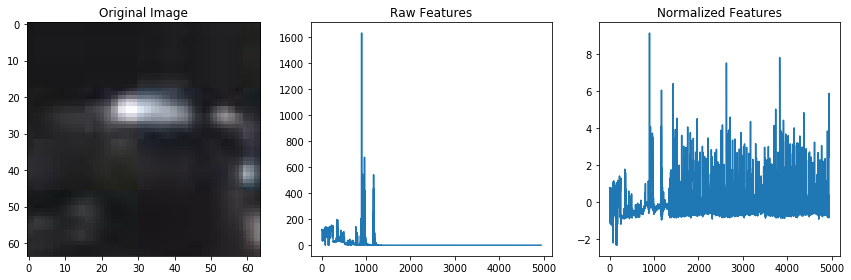

In [14]:
# Start Pipeline - Combine and Normalilze Features
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

# Seperately Extract Feature from Udacity Dataset
if APPEND_UDACITY_DATASET == False:
    udacity_car_features = extract_features(udacity_cars)
    udacity_notcar_features = extract_features(udacity_notcars)
    
# Create an array stack of feature vectors
X = np.vstack((np.array(car_features), np.array(notcar_features))).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using Spatial Binning of:',BIN_SPATIAL_SIZE[0],
    'and', HIST_NBINS,'histogram bins')

In [15]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [16]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=VALIDATION_PORTION, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 4944


### Train using  Support Vector Classifier

In [17]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = N_PREDICTIONS
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

401.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9363
SVC predicts:  [ 0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
For these 100 labels:  [ 0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.
  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.
  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
0.0208 Seconds to predict 100 labels with SVC


In [18]:
#Save Support Vector Classifier to Datacache
def save_to_datacache(support_vector_classifier, datacache_dir=DATACACHE_DIRECTORY, 
                      override_datacache=OVERWRITE_DATACACHE):
    os.makedirs(datacache_dir, exist_ok=True)
    svc_pickle = os.path.join(datacache_dir,"svc_pickle.p")
    if override_datacache or not os.path.exists(svc_pickle): 
        svc_hyperparameters = {'svc': svc,
                               'X_SCALER':X_scaler,
                               'SPATIAL': SPATIAL, 
                               'HIST_NBINS': HIST_NBINS,
                               'COLOR_SPACE': COLOR_SPACE,
                               'HOG_ORIENTATIONS': HOG_ORIENTATIONS,
                               'HOG_PIXELS_PER_CELL': HOG_PIXELS_PER_CELL,
                               'HOG_CELLS_PER_BLOCK': HOG_CELLS_PER_BLOCK,
                               'HOG_CHANNEL': HOG_CHANNEL,
                               'SW_SPATIAL_FEAT_FLAG': SW_SPATIAL_FEAT_FLAG,
                               'SW_HOG_FEAT_FLAG': SW_HOG_FEAT_FLAG,
                               'SW_COLOR_HIST_FEAT_FLAG': SW_COLOR_HIST_FEAT_FLAG
                              }

        pickle.dump(svc_hyperparameters, open(svc_pickle, "wb"))
    
# Save classifier and parameters to datacache directory  
save_to_datacache(svc)

# Vehicle Detection and Tracking

### Re-Initialize Imports

In [19]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

### Re-initialize Constants from Pickle File

In [57]:
## Directories ##
WORKING_DIRECTORY = 'data/'
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
svc_pickle = os.path.join(DATACACHE_DIRECTORY,"svc_pickle.p")
TESTING_DATASET_DIRECTORY = 'testing_dataset/'
TESTING_PIPELINE_SETUP_DIR= 'test_images/'
testset_path = "{}{}{}".format(WORKING_DIRECTORY, TESTING_PIPELINE_SETUP_DIR, '*.jpg')
with open(svc_pickle, mode='rb') as f:
    svc_hyperparameters = pickle.load(f)
    
## Feature Extraction Parameters ##
SVC = svc_hyperparameters['svc']
X_SCALER = svc_hyperparameters['X_SCALER']
# Spatial Binning
SW_SPATIAL_FEAT_FLAG = svc_hyperparameters['SW_SPATIAL_FEAT_FLAG'] 
SPATIAL = svc_hyperparameters['SPATIAL']
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
SW_COLOR_HIST_FEAT_FLAG = svc_hyperparameters['SW_COLOR_HIST_FEAT_FLAG']
HIST_NBINS = svc_hyperparameters['HIST_NBINS']
COLOR_SPACE = svc_hyperparameters['COLOR_SPACE']
# HOG Parameters
SW_HOG_FEAT_FLAG = svc_hyperparameters['SW_HOG_FEAT_FLAG']
HOG_ORIENTATIONS = svc_hyperparameters['HOG_ORIENTATIONS']
HOG_PIXELS_PER_CELL = svc_hyperparameters['HOG_PIXELS_PER_CELL']
HOG_CELLS_PER_BLOCK = svc_hyperparameters['HOG_CELLS_PER_BLOCK']
HOG_CHANNEL = svc_hyperparameters['HOG_CHANNEL']

## Sliding Windows Parameters ##
SW_XSTART_STOPS = [(None, None), (None, None)]
SW_YSTART_STOPS = [(384, 640), (384, None)]
SW_XY_WINDOWS = [(64, 64), (96,96),(128,128)]
SW_XY_OVERLAPS = [(0.50, 0.50),(.50,.50),(.50,.50)] 

## Vehicle Detection Parameters ##
BBOX_COLOR = (0, 255, 0)
BBOX_THICK = 5

## Explore Detection Technique (1) - Sliding Windows 

In [21]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=BBOX_COLOR, thick=BBOX_THICK):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [22]:
# Define a wrapper function for passing in a list of slidw_window parameters
def slide_windows(img, x_start_stops=[[None, None]],
                  y_start_stops=[[None, None]],
                  xy_windows=[(64, 64)],
                  xy_overlaps=[(0.5, 0.5)]):
    windows = []
    for i in range(len(x_start_stops)):
        if len(x_start_stops) == len(xy_windows) and len(x_start_stops) == len(xy_overlaps):
            windows = slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[i]), np.asarray(xy_overlaps[i]))
        else:
            windows = slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[0]), np.asarray(xy_overlaps[0]))
    return windows

In [23]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None],
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    window_list=[]
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None or x_start_stop[1] >= img.shape[1]:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None or y_start_stop[1] >= img.shape[0]:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [24]:
#Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [25]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space=COLOR_SPACE, 
                        spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS, 
                        orient=HOG_ORIENTATIONS, 
                        pix_per_cell=HOG_PIXELS_PER_CELL, 
                        cell_per_block=HOG_CELLS_PER_BLOCK,
                        hog_channel=HOG_CHANNEL, 
                        spatial_feat=SW_SPATIAL_FEAT_FLAG,
                        hist_feat=SW_COLOR_HIST_FEAT_FLAG, 
                        hog_feat=SW_HOG_FEAT_FLAG):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    # Scale Image for feature extraction?
    #feature_image = feature_image.astype(np.float64)
    #feature_image = np.float64(np.copy(feature_image))
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [26]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, svc=SVC, 
                   X_scaler=X_SCALER, 
                   color_space=COLOR_SPACE, 
                   spatial_size=BIN_SPATIAL_SIZE, 
                   hist_bins=HIST_NBINS, 
                   orient=HOG_ORIENTATIONS, 
                   pix_per_cell=HOG_PIXELS_PER_CELL, 
                   cell_per_block=HOG_CELLS_PER_BLOCK, 
                   hog_channel=HOG_CHANNEL, 
                   spatial_feat=SW_SPATIAL_FEAT_FLAG, 
                   hist_feat=SW_COLOR_HIST_FEAT_FLAG, 
                   hog_feat=SW_HOG_FEAT_FLAG):
            
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    heatmap = np.zeros_like(img[:,:,0])    
    #2) Iterate over all windows in the list
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], 
                              (DEFAULT_LENGTH, DEFAULT_WIDTH)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(list(np.array(features).reshape(1, -1)))
        #6) Predict using classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1: # Car detected
            on_windows.append(window)
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] +=1

    #8) Return windows for positive detections
    return on_windows, heatmap
    

In [27]:
# Try Scaling Windows on Test Images
image_paths = glob.glob(testset_path, recursive=True)
print('Found',len(image_paths),'images in directory:', testset_path)

Found 6 images in directory: data/test_images/*.jpg


In [28]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_single_frame_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for label in labels:
        for car_number in range(1, label[1] + 1):
            #Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            #Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            #Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], BBOX_COLOR, BBOX_THICK)
        # Return the image
    return img

BBoxes Found: 45
1.8002336025238037 seconds to process one image search 351 windows
BBoxes Found: 35
1.8194448947906494 seconds to process one image search 351 windows
BBoxes Found: 26
1.7953975200653076 seconds to process one image search 351 windows
BBoxes Found: 22
1.7994015216827393 seconds to process one image search 351 windows
BBoxes Found: 40
1.7951605319976807 seconds to process one image search 351 windows
BBoxes Found: 25
1.7789034843444824 seconds to process one image search 351 windows


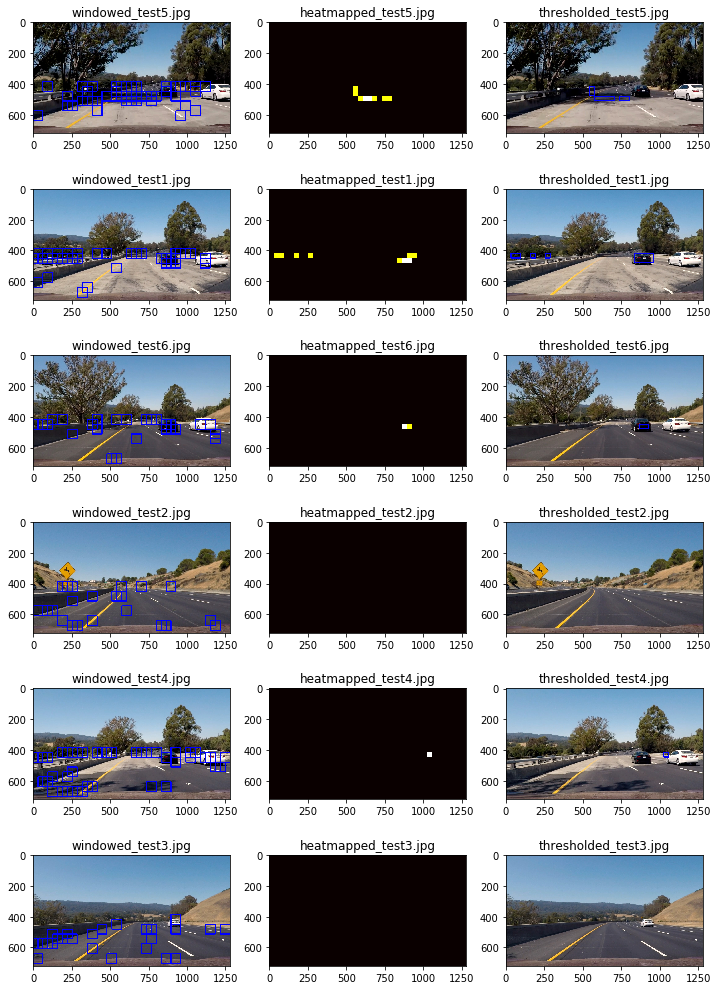

In [29]:
# Define a single function that can extract features using sliding windows and make predictions
carslist = []
out_images = []
out_titles = []

for img_path in image_paths:
    t1 = time.time()
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_shape = img.shape
    draw_img = np.copy(rgb_img)
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    threshold = 2
    filename = os.path.split(img_path)[-1]
    
    windows = slide_windows(rgb_img, x_start_stops=SW_XSTART_STOPS, 
                              y_start_stops=SW_YSTART_STOPS, 
                              xy_windows=SW_XY_WINDOWS, 
                              xy_overlaps=SW_XY_OVERLAPS)
    
    hot_windows, heatmap = search_windows(rgb_img, windows)
    print('BBoxes Found:', len(hot_windows))
    
    window_img = draw_boxes(rgb_img, hot_windows, color=BBOX_COLOR, thick=BBOX_THICK)
    labels = label(apply_threshold(heatmap, threshold))
    
    # Draw bounding boxes on a copy of the input image       
    window_img_thresh = draw_single_frame_labeled_bboxes(draw_img, [labels])

    out_images.append(window_img)
    out_titles.append('windowed_'+filename)
    out_images.append(heatmap)
    out_titles.append('heatmapped_'+filename)
    out_images.append(window_img_thresh)
    out_titles.append('thresholded_'+filename)
    
    print(time.time()-t1, 'seconds to process one image search', len(windows), 'windows')

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 3, out_images, out_titles)

## Explore Vehicle Dectection Technique (2) - HOG Sub-Sampling Window Search 

We want a more efficient way to detect vehicles. This approach will allow for only a single call to get HOG features. The pipeline will then find a sub sample

In [30]:
SW_CONVERT_COLOR = 'RGB2YCrCb'
def convert_color(img, conv=SW_CONVERT_COLOR):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

0.17902708053588867 seconds to run, total windows =  5
0.1855311393737793 seconds to run, total windows =  10
0.19152355194091797 seconds to run, total windows =  15
0.19762349128723145 seconds to run, total windows =  20
0.20352673530578613 seconds to run, total windows =  25
0.20944762229919434 seconds to run, total windows =  30
0.21535110473632812 seconds to run, total windows =  35
0.22123003005981445 seconds to run, total windows =  40
0.22709417343139648 seconds to run, total windows =  45
0.2330782413482666 seconds to run, total windows =  50
0.23897767066955566 seconds to run, total windows =  55
0.2448580265045166 seconds to run, total windows =  60
0.2507812976837158 seconds to run, total windows =  65
0.2567436695098877 seconds to run, total windows =  70
0.2626018524169922 seconds to run, total windows =  75
0.26848602294921875 seconds to run, total windows =  80
0.27440929412841797 seconds to run, total windows =  85
0.28034257888793945 seconds to run, total windows =  90

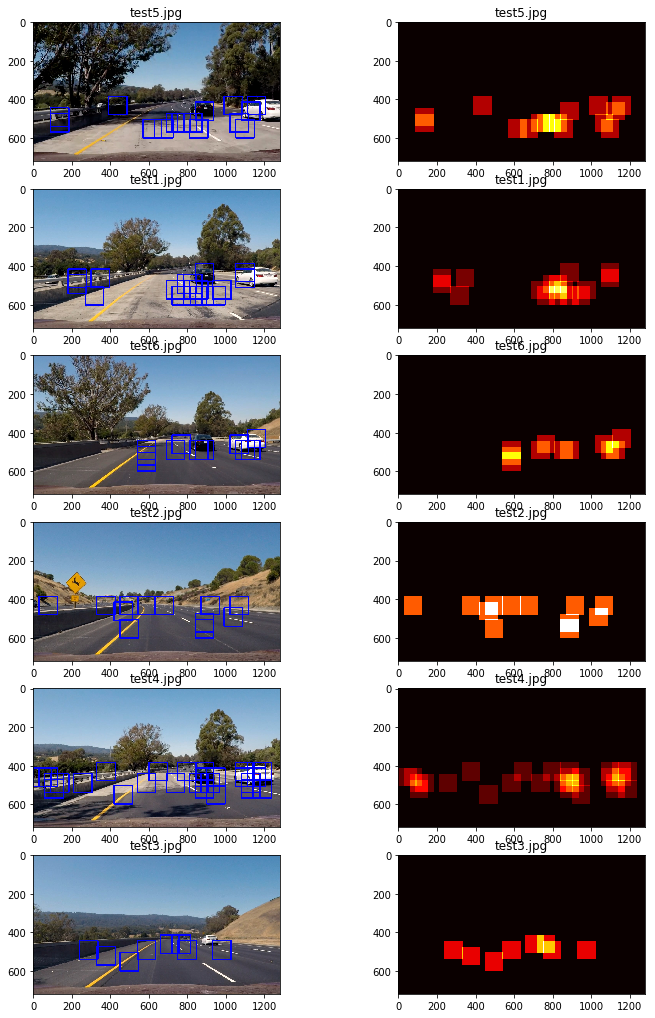

In [31]:
# Define a single function that can extract features using hog sub-sampling and make predictions
out_images = []
out_maps = []
out_titles = []
out_boxes = []

## Parameters - HOG Sub-Sampling ##
 

ystart = SW_YSTART
ystop = SW_YSTOP
scale = SW_SCALE
spatial_size=BIN_SPATIAL_SIZE
hist_bins=HIST_NBINS
orient=HOG_ORIENTATIONS
pix_per_cell=HOG_PIXELS_PER_CELL
cell_per_block=HOG_CELLS_PER_BLOCK
hog_channel=HOG_CHANNEL
spatial_feat=SW_SPATIAL_FEAT_FLAG
hog_feat=SW_HOG_FEAT_FLAG
hist_feat=SW_COLOR_HIST_FEAT_FLAG


#Iterate over the test images
for img_path in image_paths:
    img_boxes = []
    t1 = time.time()
    count = 0
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img_to_search = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64 # HOG_PIXELS_PER_CELL*HOG_PIXELS_PER_CELL # 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this particular patch
            if SW_HOG_FEAT_FLAG == True: # Should always be true
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

            # Get color features
            if SW_SPATIAL_FEAT_FLAG == True:
                spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
            if SW_COLOR_HIST_FEAT_FLAG == True:    
                hist_features = color_hist(subimg, nbins=HIST_NBINS)
            
                        
            # Append the new feature vector to the features list
            # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
            if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((spatial_features, hist_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((hist_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((spatial_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((spatial_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((spatial_features, hist_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((hist_features))
            else:
                test_feats = np.hstack((np.ravel(img)))
            
            
            # Scale features and make a prediction
            test_features = X_SCALER.transform(test_feats.reshape(1, -1))
            test_prediction = SVC.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))

                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
        print(time.time()-t1, 'seconds to run, total windows = ', count)

    out_images.append(draw_img)

    out_titles.append(os.path.split(img_path)[-1])
    out_titles.append(os.path.split(img_path)[-1])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [32]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=SW_YSTART,
              ystop=SW_YSTOP, 
              scale=SW_SCALE, 
              svc=SVC, 
              X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, 
              pix_per_cell=HOG_PIXELS_PER_CELL, 
              cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, 
              hist_bins=HIST_NBINS,
              spatial_feat=SW_SPATIAL_FEAT_FLAG,
              hog_feat=SW_HOG_FEAT_FLAG,
              hist_feat=SW_COLOR_HIST_FEAT_FLAG):
    
    # If y start/stop positions not defined, set to image size      
    if ystart == None or ystart < 0:
        ystart = 384
    if ystop == None or ystop > img.shape[0]:
        ystop = img.shape[0]
    draw_img = np.copy(img)

    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img_to_search = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64 # 10 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
    cells_per_step = 1 # HOG_CELLS_PER_BLOCK  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this particular patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

            # Get color features
            if SW_SPATIAL_FEAT_FLAG == True:
                spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
            if SW_COLOR_HIST_FEAT_FLAG == True:    
                hist_features = color_hist(subimg, nbins=HIST_NBINS)
            
                        
            # Append the new feature vector to the features list
            # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
            if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((spatial_features, hist_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((hist_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((spatial_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((spatial_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((spatial_features, hist_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((hist_features))
            else:
                test_feats = np.hstack((np.ravel(img)))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(test_feats.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,BBOX_THICK)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
    return draw_img, heatmap

In [153]:
# DEFINE A CLASS TO RECEIVE THE CHARACTERISTICS OF EACH VEHICLE DETECTION
# Objects defined as "Vehicles" will be where multiple overlaping detections exists in the heatmap
class Vehicle():
    def __init__(self, bbox):
        car_lens = [car.car_number for car in carslist]
        if len(car_lens) > 0: 
            self.car_number = np.max(car_lens) + 1
        else: self.car_number = 0
        self.prev_detected = False # Flag sets if the Vehicle was detected in the last iteration
        self.cur_detected = True # Flag sets if the Vehicle is detected in the current iteration
        self.n_detections = 1 # number of times this vehicle has been detected
        self.n_non_detections = 0 # number of consecutive times this vehicle has not been detected
        self.xpixels = np.arange(bbox[0][0], bbox[1][0]+1) # Pixel x values of last detection
        self.ypixels = np.arange(bbox[0][1], bbox[1][1]+1) # Pixel y values of last detection
        self.recent_xfitted = []
        self.recent_xfitted.append(bbox[0][0]) # x position of the last n fits of the bounding box
        self.bestx = bbox[0][0] # X position of the current fit
        self.recent_yfitted = []
        self.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
        self.besty = bbox[0][1] # Average y position of the current fit
        self.recent_wfitted = []
        self.recent_wfitted.append(bbox[1][0])
        self.bestw = bbox[1][0] # Average width of the last n fits
        self.recent_hfitted = []
        self.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
        self.besth = bbox[1][1] # Average height of the last n fits
        self.bounding_box = bbox


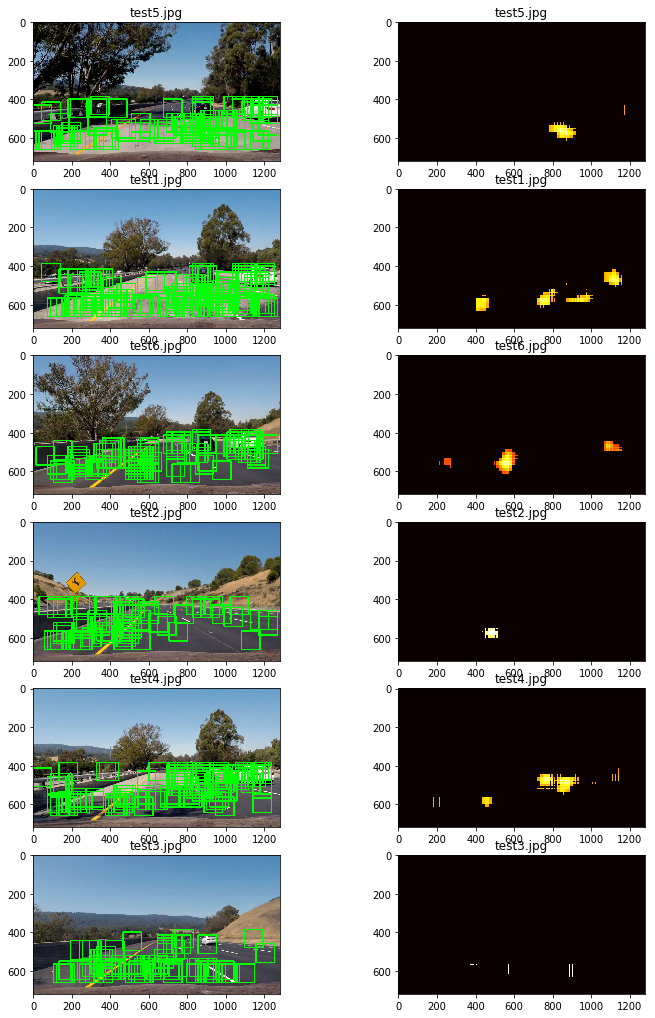

In [197]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
carslist = []
threshold = 10

## Parameters - HOG Sub-Sampling ##
SW_YSTART = 384
SW_YSTOP = 672
SW_SCALE = 1.5

#Iterate over the test images
for img_path in image_paths:
    img = mpimg.imread(img_path)
    out_img, heatmap = find_cars(img, ystart=SW_YSTART, 
                                 ystop=SW_YSTOP, 
                                 scale=SW_SCALE)
    labels = label(apply_threshold(heatmap, threshold))
    # Draw bounding boxes on a copy of the image       
    draw_img = draw_single_frame_labeled_bboxes(np.copy(out_img), [labels])
    out_images.append(draw_img)
    out_images.append(heatmap)
    filename = os.path.split(img_path)[-1]
    out_titles.append(filename)
    out_titles.append(filename)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [ ]:
# Define a function that Implements Smoothing Factor for Multi-Fram Object Tracking
def draw_multi_frame_labeled_bboxes(img, labels, smoothing_factor=1, keep_weight=15, remove_threshold = 5, debug=False):
    noisy_pix_thresh= 4e2
    img = np.copy(img)
    # Set all cur_detected values to false for current frame
    for car in carslist:
        car.cur_detected = False
    
    for label in labels:
        # Iterate through all detected labels
        for car_number in range(1, label[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

            # Check if bounding box appears in carslist
            found_match = False
            for car in carslist:               
                # Create comparison matrix
                bbox_flatten = []
                bbox_flatten.append(bbox[0])
                bbox_flatten.append(bbox[1])
                bbox_flatten = [x for xs in bbox_flatten for x in xs]
                
                car_bbox_flat = []
                car_bbox_flat.append(car.bounding_box[0])
                car_bbox_flat.append(car.bounding_box[1])
                car_bbox_flat = [x for xs in car_bbox_flat for x in xs]
                
                if(np.allclose(bbox_flatten, car_bbox_flat, atol=8)):
                    found_match = True
                    if debug:
                        print('Found a match. Car Bounding Box', car.bounding_box, '| length nonzerox:',len(nonzerox),
                             '| length nonzeroy:',len(nonzeroy))
                        print('Checked against Bounding box:',bbox)

                    car.n_detections += 1                
                    car.prev_detected = found_match
                    car.cur_detected = found_match
                    car.n_non_detections = 0 # Reset non_detections value
                    car.xpixels = nonzerox # Pixel x values of current detection
                    car.ypixels = nonzeroy # Pixel y values of current detection
                   
                    car.recent_xfitted.append(bbox[0][0])
                    car.bestx = int(np.mean(car.recent_xfitted)*.5 + bbox[0][0]*.5) # Average x position of the last n fits
                    car.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
                    car.besty = int(np.mean(car.recent_yfitted)*.5 + bbox[0][1]*.5) # Average y position of the current fit
                    car.recent_wfitted.append(bbox[1][0])
                    car.bestw = int(np.mean(car.recent_wfitted)*.5 + bbox[1][0]*.5) # Average width of the last n fits
                    car.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
                    car.besth = int(np.mean(car.recent_hfitted)*.5 + bbox[1][1]*.5) # Average height of the last n fits

                    car.bounding_box = ((car.bestx, car.besty),
                                            (car.bestw, car.besth))
                    break

            # After searching for existing car, add new Vehicle         
            if found_match == False and len(nonzerox) > noisy_pix_thresh and len(nonzeroy) < 1e5: 
                # Add New Vehicle
                car = Vehicle(bbox)
                car.xpixels = nonzerox
                car.ypixels = nonzeroy
                car.n_non_detections +=1 
                car.prev_detected = found_match
                car.cur_detected = True

                # Add car to carslist
                carslist.append(car)
            
        
    # After searching through labels and updating carslist, draw labels
    for car in carslist:
        # Set n_non_detections+=1 for each car in carslist that wasn't prev_detected
        if (car.prev_detected == True and car.cur_detected == False):
            if debug:
                print('Found possible false positive for car:', car.bounding_box, 'checking against smoothing factor')
                print( 'Car number:', car.car_number)
            if car.n_detections > smoothing_factor:
                cv2.rectangle(img, car.bounding_box[0], car.bounding_box[1], BBOX_COLOR, BBOX_THICK)
                car.prev_detected == False
                car.n_non_detections +=1
            else:
                car.prev_detected == False
                car.n_non_detections +=1
        
        ## Apply noise filtering to object detections
        #Process cars within the smoothing factor range
        if (car.n_detections > smoothing_factor \
            and car.n_detections > car.n_non_detections #prev had this as an or
            and len(car.xpixels) > noisy_pix_thresh
            and len(car.ypixels) < 1e5):
            cv2.rectangle(img, car.bounding_box[0], car.bounding_box[1], BBOX_COLOR, BBOX_THICK)
        elif (car.n_detections < smoothing_factor \
            and car.n_non_detections < car.n_detections
            and len(car.xpixels) > noisy_pix_thresh
            and len(car.ypixels) < 1e5):
            cv2.rectangle(img, car.bounding_box[0], car.bounding_box[1], (255,0,0), BBOX_THICK)
        
        ## Remove Stale cars ##
        car_lens = [car.car_number for car in carslist]
        if len(car_lens) > 0: 
            max_car_number = np.max(car_lens)
            min_car_number = np.min(car_lens)
        else: 
            max_car_number = 1
            min_car_number = 0
            
        if (car.n_non_detections >= remove_threshold \
            or len(car.xpixels) < noisy_pix_thresh
            or (np.abs(max_car_number - car.car_number) > keep_weight and \
                car.cur_detected == False and car.prev_detected == False) and 
                car.n_non_detections > 3):
            if debug: 
                print('Removing Car:', car.bounding_box)
                print('Carlist now has size:', len(carslist))
            carslist.remove(car)
        
    # Return the image
    return img

### Process Video

In [231]:
# Calibration Constants #
IMAGE_EXTENSION = '.jpg'
CALIBRATION_DIRECTORY = 'camera_cal/'
CALIBRATION_PREFIX = 'corners_found'
calibration_path = "{}{}{}".format(DATACACHE_DIRECTORY, CALIBRATION_DIRECTORY, '*'+IMAGE_EXTENSION)
dist_pickle_file = os.path.join(DATACACHE_DIRECTORY, "calibration_pickle.p")
CHESSBOARD_SIZE = (9,6)

### Camera Calibration

In [172]:
# Calibrate the camera using a 9x6 checkerboard
objp = np.zeros((CHESSBOARD_SIZE[1]*CHESSBOARD_SIZE[0], 3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3-Dim points in real-world space
imgpoints = [] # 2-Dim points in virtual image plane

# Load Calibration Images 
calibration_images = glob.glob(calibration_path, recursive=True)

# Walk through images and search for checkerboard corners
for idx, fname in enumerate(calibration_images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the checkerboard corners
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None)
    
    # If found, add object points, image points
    if ret == True:
        print('Calibrating image:', fname)
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display found corners
        cv2.drawChessboardCorners(img, CHESSBOARD_SIZE, corners, ret)
        output_img_path = "{}{}{}{}{}".format(DATACACHE_DIRECTORY, CALIBRATION_DIRECTORY, CALIBRATION_PREFIX
                                              ,str(idx), IMAGE_EXTENSION)
        print('Saving Calibrated image:', output_img_path)

        os.makedirs(os.path.join(DATACACHE_DIRECTORY, CALIBRATION_DIRECTORY), exist_ok=True)    
        cv2.imwrite(output_img_path, img)

Calibrating image: data/datacache/camera_cal/calibration10.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found0.jpg
Calibrating image: data/datacache/camera_cal/calibration6.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found1.jpg
Calibrating image: data/datacache/camera_cal/calibration9.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found2.jpg
Calibrating image: data/datacache/camera_cal/calibration7.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found3.jpg
Calibrating image: data/datacache/camera_cal/calibration19.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found4.jpg
Calibrating image: data/datacache/camera_cal/calibration20.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found5.jpg
Calibrating image: data/datacache/camera_cal/calibration16.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found6.jpg
Calibrating image: data/datacache/camera_cal/calibration17.jpg
Saving Ca

In [175]:
# Load image for reference
if os.path.exists(dist_pickle_file):
    dist_pickle = pickle.load( open(dist_pickle_file, "rb"))
else:
    dist_pickle = {}

img = cv2.imread(calibration_images[0])
img_size = (img.shape[1], img.shape[0])

# Perform calibration given object points and image points
if ("mtx" in dist_pickle and "dist" in dist_pickle):
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
else:
    ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save camera calibration result data
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

pickle.dump(dist_pickle, open(dist_pickle_file, "wb"))

In [176]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open(dist_pickle_file, "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [242]:
## Sliding Windows Parameters ##
SW_XSTART_STOPS = [(None, None), (200, 100), (256, None)]
SW_YSTART_STOPS = [(384, 640), (384, None),(384, None)]
SW_XY_WINDOWS = [(64, 64), (96,96),(128,128)]
SW_XY_OVERLAPS = [(0.85, 0.850),(.750,.750),(.750,.750)] 

## Parameters - HOG Sub-Sampling ##
SW_YSTART = 384
SW_YSTOP = 672
SW_SCALE = 1.5

def process_image(img):
    SMOOTHING_FACTOR = 6
    if (img is not None):
        img = cv2.undistort(img, mtx, dist, None, mtx)
        labels = []
        ## Search for cars from previous frame Gather previous bboxes from carslist
        heatmap_1 = np.zeros_like(img[:,:,2])
                
        ## Search for previously detected cars in current frame ##
        bboxes = [[(500, 505), (750, 755)]] #Start with window presumed to be in front of vehicle
        for car in carslist:
            if car.cur_detected == True or car.prev_detected == True or (car.n_detections > SMOOTHING_FACTOR and car.n_non_detections < SMOOTHING_FACTOR): 
                bboxes.append(list(car.bounding_box)) # Grab previous frames for feedback loop
            
        detected_cars_threshold = 0
        _, heatmap_1 = search_windows(img, bboxes)
        labels.append(label(apply_threshold(heatmap_1, detected_cars_threshold)))
        
        ## Detect with HOG subsampling ##
        hog_subsampling_threshold = 3
        _, heatmap_2 = find_cars(img, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALE)
        labels.append(label(apply_threshold(heatmap_2, hog_subsampling_threshold)))
        
        ## Detect with Sliding Windows ##
        sliding_windows_threshold = 5
        windows = slide_windows(img, x_start_stops=SW_XSTART_STOPS, 
                              y_start_stops=SW_YSTART_STOPS, 
                              xy_windows=SW_XY_WINDOWS, 
                              xy_overlaps=SW_XY_OVERLAPS)
        _, heatmap_3 = search_windows(img, windows)
        labels.append(label(apply_threshold(heatmap_3, sliding_windows_threshold)))
        draw_img = draw_multi_frame_labeled_bboxes(img, labels, smoothing_factor=SMOOTHING_FACTOR, debug=False)
        return draw_img
    else:
        return img

In [243]:
#Import packages to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_ouput = 'test_output.mp4'
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, test_ouput)

TEST_VIDEO = 'test_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, TEST_VIDEO)
clip = VideoFileClip(VIDEO_FILE_PATH)
carslist = []
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

HTML("""
<video width="960" height="540" controls>
 <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))

[MoviePy] >>>> Building video data/test_output.mp4
[MoviePy] Writing video data/test_output.mp4



 97%|█████████▋| 38/39 [01:42<00:02,  2.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/test_output.mp4 



### Process Project Video

In [239]:
project_ouput = 'project_output.mp4'
PROJECT_VIDEO = 'project_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, PROJECT_VIDEO)
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, project_ouput)

carslist = []
clip = VideoFileClip(VIDEO_FILE_PATH)
project_clip = clip.fl_image(process_image)
project_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

[MoviePy] >>>> Building video data/project_output.mp4
[MoviePy] Writing video data/project_output.mp4


  0%|          | 1/1261 [00:01<29:22,  1.40s/it]

Found a match. Car Bounding Box ((1015, 454), (1231, 617)) | length nonzerox: 35208 | length nonzeroy: 35208
Checked against Bounding box: ((1015, 454), (1230, 616))
Found a match. Car Bounding Box ((17, 384), (356, 652)) | length nonzerox: 73311 | length nonzeroy: 73311
Checked against Bounding box: ((17, 384), (356, 652))
Found a match. Car Bounding Box ((385, 419), (671, 652)) | length nonzerox: 48622 | length nonzeroy: 48622
Checked against Bounding box: ((385, 419), (671, 652))
Found a match. Car Bounding Box ((1015, 454), (1230, 616)) | length nonzerox: 29584 | length nonzeroy: 29584
Checked against Bounding box: ((1015, 454), (1231, 617))


  0%|          | 2/1261 [00:02<29:22,  1.40s/it]

Found possible false positive for car: ((17, 384), (356, 652)) checking against smoothing factor
Car number: 0
Found possible false positive for car: ((385, 419), (671, 652)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((1015, 454), (1230, 616)) checking against smoothing factor
Car number: 2


  0%|          | 3/1261 [00:04<29:21,  1.40s/it]

Found possible false positive for car: ((17, 384), (356, 652)) checking against smoothing factor
Car number: 0
Found possible false positive for car: ((385, 419), (671, 652)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((1015, 454), (1230, 616)) checking against smoothing factor
Car number: 2


  0%|          | 4/1261 [00:05<29:11,  1.39s/it]

Found a match. Car Bounding Box ((332, 384), (688, 652)) | length nonzerox: 95408 | length nonzeroy: 95408
Checked against Bounding box: ((332, 384), (687, 651))
Found possible false positive for car: ((17, 384), (356, 652)) checking against smoothing factor
Car number: 0
Found possible false positive for car: ((385, 419), (671, 652)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((1015, 454), (1230, 616)) checking against smoothing factor
Car number: 2


  0%|          | 5/1261 [00:06<28:56,  1.38s/it]

Found a match. Car Bounding Box ((332, 384), (687, 651)) | length nonzerox: 95071 | length nonzeroy: 95071
Checked against Bounding box: ((332, 384), (686, 651))
Found possible false positive for car: ((17, 384), (356, 652)) checking against smoothing factor
Car number: 0
Found possible false positive for car: ((385, 419), (671, 652)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((1015, 454), (1230, 616)) checking against smoothing factor
Car number: 2


  0%|          | 6/1261 [00:08<29:07,  1.39s/it]

Found a match. Car Bounding Box ((385, 419), (671, 652)) | length nonzerox: 66638 | length nonzeroy: 66638
Checked against Bounding box: ((385, 419), (670, 651))
Found possible false positive for car: ((17, 384), (356, 652)) checking against smoothing factor
Car number: 0
Removing Car: ((17, 384), (356, 652))
Carlist now has size: 20
Found possible false positive for car: ((1015, 454), (1230, 616)) checking against smoothing factor
Car number: 2
Removing Car: ((1015, 454), (1230, 616))
Carlist now has size: 19
Found possible false positive for car: ((332, 384), (686, 651)) checking against smoothing factor
Car number: 6


  1%|          | 7/1261 [00:09<29:21,  1.40s/it]

Found a match. Car Bounding Box ((332, 384), (686, 651)) | length nonzerox: 94518 | length nonzeroy: 94518
Checked against Bounding box: ((332, 384), (685, 650))
Found a match. Car Bounding Box ((717, 454), (916, 600)) | length nonzerox: 29054 | length nonzeroy: 29054
Checked against Bounding box: ((717, 454), (915, 599))
Found possible false positive for car: ((385, 419), (670, 651)) checking against smoothing factor
Car number: 1


  1%|          | 8/1261 [00:11<29:21,  1.41s/it]

Found a match. Car Bounding Box ((717, 454), (915, 599)) | length nonzerox: 28710 | length nonzeroy: 28710
Checked against Bounding box: ((717, 454), (914, 598))
Found possible false positive for car: ((385, 419), (670, 651)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((332, 384), (685, 650)) checking against smoothing factor
Car number: 6


  1%|          | 9/1261 [00:12<29:18,  1.40s/it]

Found a match. Car Bounding Box ((332, 384), (685, 650)) | length nonzerox: 93898 | length nonzeroy: 93898
Checked against Bounding box: ((332, 384), (684, 649))
Found possible false positive for car: ((385, 419), (670, 651)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((717, 454), (914, 598)) checking against smoothing factor
Car number: 16


  1%|          | 10/1261 [00:13<28:41,  1.38s/it]

Found possible false positive for car: ((385, 419), (670, 651)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((332, 384), (685, 649)) checking against smoothing factor
Car number: 6
Found possible false positive for car: ((717, 454), (914, 598)) checking against smoothing factor
Car number: 16


  1%|          | 11/1261 [00:15<28:52,  1.39s/it]

Found a match. Car Bounding Box ((385, 419), (670, 651)) | length nonzerox: 66120 | length nonzeroy: 66120
Checked against Bounding box: ((385, 419), (669, 650))
Found possible false positive for car: ((332, 384), (685, 649)) checking against smoothing factor
Car number: 6
Found possible false positive for car: ((717, 454), (914, 598)) checking against smoothing factor
Car number: 16


  1%|          | 12/1261 [00:16<29:02,  1.39s/it]

Found a match. Car Bounding Box ((385, 419), (669, 650)) | length nonzerox: 65604 | length nonzeroy: 65604
Checked against Bounding box: ((385, 419), (668, 649))
Found possible false positive for car: ((332, 384), (685, 649)) checking against smoothing factor
Car number: 6
Found possible false positive for car: ((717, 454), (914, 598)) checking against smoothing factor
Car number: 16


  1%|          | 13/1261 [00:18<29:00,  1.39s/it]

Found a match. Car Bounding Box ((385, 419), (668, 649)) | length nonzerox: 65090 | length nonzeroy: 65090
Checked against Bounding box: ((385, 419), (667, 648))
Found possible false positive for car: ((332, 384), (685, 649)) checking against smoothing factor
Car number: 6
Found possible false positive for car: ((717, 454), (914, 598)) checking against smoothing factor
Car number: 16
Removing Car: ((717, 454), (914, 598))
Carlist now has size: 34


  1%|          | 14/1261 [00:19<29:03,  1.40s/it]

Found a match. Car Bounding Box ((385, 419), (668, 649)) | length nonzerox: 65090 | length nonzeroy: 65090
Checked against Bounding box: ((385, 419), (667, 648))
Found possible false positive for car: ((332, 384), (685, 649)) checking against smoothing factor
Car number: 6
Removing Car: ((332, 384), (685, 649))
Carlist now has size: 39


  1%|          | 15/1261 [00:20<29:20,  1.41s/it]

Found a match. Car Bounding Box ((385, 419), (668, 649)) | length nonzerox: 65090 | length nonzeroy: 65090
Checked against Bounding box: ((385, 419), (667, 648))


  1%|▏         | 16/1261 [00:22<29:24,  1.42s/it]

Found a match. Car Bounding Box ((385, 419), (667, 648)) | length nonzerox: 64578 | length nonzeroy: 64578
Checked against Bounding box: ((385, 419), (666, 647))


  1%|▏         | 17/1261 [00:23<29:12,  1.41s/it]

Found a match. Car Bounding Box ((1032, 401), (1143, 512)) | length nonzerox: 12321 | length nonzeroy: 12321
Checked against Bounding box: ((1032, 401), (1142, 511))
Found possible false positive for car: ((385, 419), (667, 648)) checking against smoothing factor
Car number: 1


  1%|▏         | 18/1261 [00:25<29:29,  1.42s/it]

Found a match. Car Bounding Box ((1032, 401), (1142, 511)) | length nonzerox: 12100 | length nonzeroy: 12100
Checked against Bounding box: ((1032, 401), (1141, 510))
Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 94447 | length nonzeroy: 94447
Checked against Bounding box: ((385, 419), (749, 719))
Found possible false positive for car: ((385, 419), (667, 648)) checking against smoothing factor
Car number: 1


  2%|▏         | 19/1261 [00:26<29:13,  1.41s/it]

Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 109664 | length nonzeroy: 109664
Checked against Bounding box: ((385, 419), (749, 719))
Found a match. Car Bounding Box ((280, 384), (653, 652)) | length nonzerox: 70966 | length nonzeroy: 70966
Checked against Bounding box: ((280, 384), (653, 652))
Found possible false positive for car: ((385, 419), (667, 648)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((1032, 401), (1141, 510)) checking against smoothing factor
Car number: 47


  2%|▏         | 20/1261 [00:28<29:29,  1.43s/it]

Found possible false positive for car: ((385, 419), (667, 648)) checking against smoothing factor
Car number: 1
Found possible false positive for car: ((280, 384), (653, 652)) checking against smoothing factor
Car number: 44
Found possible false positive for car: ((1032, 401), (1141, 510)) checking against smoothing factor
Car number: 47
Found possible false positive for car: ((385, 419), (749, 719)) checking against smoothing factor
Car number: 49


  2%|▏         | 21/1261 [00:29<29:38,  1.43s/it]

Found a match. Car Bounding Box ((1102, 401), (1196, 495)) | length nonzerox: 8836 | length nonzeroy: 8836
Checked against Bounding box: ((1102, 401), (1195, 494))
Found possible false positive for car: ((385, 419), (667, 648)) checking against smoothing factor
Car number: 1
Removing Car: ((385, 419), (667, 648))
Carlist now has size: 70
Found possible false positive for car: ((280, 384), (653, 652)) checking against smoothing factor
Car number: 44
Found possible false positive for car: ((1032, 401), (1141, 510)) checking against smoothing factor
Car number: 47
Found possible false positive for car: ((385, 419), (749, 719)) checking against smoothing factor
Car number: 49


  2%|▏         | 22/1261 [00:31<29:47,  1.44s/it]

Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 109664 | length nonzeroy: 109664
Checked against Bounding box: ((385, 419), (749, 719))
Found possible false positive for car: ((280, 384), (653, 652)) checking against smoothing factor
Car number: 44
Found possible false positive for car: ((1032, 401), (1141, 510)) checking against smoothing factor
Car number: 47
Found possible false positive for car: ((1102, 401), (1195, 494)) checking against smoothing factor
Car number: 66


  2%|▏         | 23/1261 [00:32<29:45,  1.44s/it]

Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 109664 | length nonzeroy: 109664
Checked against Bounding box: ((385, 419), (749, 719))
Found possible false positive for car: ((280, 384), (653, 652)) checking against smoothing factor
Car number: 44
Found possible false positive for car: ((1032, 401), (1141, 510)) checking against smoothing factor
Car number: 47
Removing Car: ((1032, 401), (1141, 510))
Carlist now has size: 74
Found possible false positive for car: ((1102, 401), (1195, 494)) checking against smoothing factor
Car number: 66


  2%|▏         | 24/1261 [00:33<29:45,  1.44s/it]

Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 109664 | length nonzeroy: 109664
Checked against Bounding box: ((385, 419), (749, 719))
Found a match. Car Bounding Box ((822, 454), (1108, 652)) | length nonzerox: 56628 | length nonzeroy: 56628
Checked against Bounding box: ((822, 454), (1107, 651))
Found possible false positive for car: ((280, 384), (653, 652)) checking against smoothing factor
Car number: 44
Removing Car: ((280, 384), (653, 652))
Carlist now has size: 74
Found possible false positive for car: ((1102, 401), (1195, 494)) checking against smoothing factor
Car number: 66


  2%|▏         | 25/1261 [00:35<29:19,  1.42s/it]

Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 109664 | length nonzeroy: 109664
Checked against Bounding box: ((385, 419), (749, 719))
Found possible false positive for car: ((1102, 401), (1195, 494)) checking against smoothing factor
Car number: 66
Found possible false positive for car: ((822, 454), (1107, 651)) checking against smoothing factor
Car number: 76


  2%|▏         | 26/1261 [00:36<29:10,  1.42s/it]

Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 109664 | length nonzeroy: 109664
Checked against Bounding box: ((385, 419), (749, 719))
Found possible false positive for car: ((1102, 401), (1195, 494)) checking against smoothing factor
Car number: 66
Removing Car: ((1102, 401), (1195, 494))
Carlist now has size: 77
Found possible false positive for car: ((822, 454), (1107, 651)) checking against smoothing factor
Car number: 76


  2%|▏         | 27/1261 [00:38<28:59,  1.41s/it]

Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 109664 | length nonzeroy: 109664
Checked against Bounding box: ((385, 419), (749, 719))
Found possible false positive for car: ((822, 454), (1107, 651)) checking against smoothing factor
Car number: 76


  2%|▏         | 28/1261 [00:39<28:56,  1.41s/it]

Found a match. Car Bounding Box ((385, 419), (749, 719)) | length nonzerox: 109200 | length nonzeroy: 109200
Checked against Bounding box: ((385, 419), (748, 718))
Found possible false positive for car: ((822, 454), (1107, 651)) checking against smoothing factor
Car number: 76


  2%|▏         | 29/1261 [00:40<29:18,  1.43s/it]

Found a match. Car Bounding Box ((385, 419), (748, 718)) | length nonzerox: 108537 | length nonzeroy: 108537
Checked against Bounding box: ((385, 419), (747, 717))
Found possible false positive for car: ((822, 454), (1107, 651)) checking against smoothing factor
Car number: 76
Removing Car: ((822, 454), (1107, 651))
Carlist now has size: 86


  2%|▏         | 30/1261 [00:42<29:15,  1.43s/it]

Found a match. Car Bounding Box ((385, 419), (747, 717)) | length nonzerox: 107876 | length nonzeroy: 107876
Checked against Bounding box: ((385, 419), (746, 716))


  2%|▏         | 31/1261 [00:43<28:47,  1.40s/it]

Found a match. Car Bounding Box ((385, 419), (747, 717)) | length nonzerox: 109262 | length nonzeroy: 109262
Checked against Bounding box: ((385, 419), (749, 719))


  3%|▎         | 32/1261 [00:45<28:40,  1.40s/it]

Found a match. Car Bounding Box ((385, 419), (748, 718)) | length nonzerox: 109463 | length nonzeroy: 109463
Checked against Bounding box: ((385, 419), (749, 719))


  3%|▎         | 33/1261 [00:46<28:40,  1.40s/it]

Found a match. Car Bounding Box ((385, 419), (748, 718)) | length nonzerox: 108537 | length nonzeroy: 108537
Checked against Bounding box: ((385, 419), (747, 717))
Found a match. Car Bounding Box ((787, 506), (933, 635)) | length nonzerox: 18834 | length nonzeroy: 18834
Checked against Bounding box: ((787, 506), (932, 634))


  3%|▎         | 34/1261 [00:47<28:55,  1.41s/it]

Found a match. Car Bounding Box ((385, 419), (747, 717)) | length nonzerox: 107876 | length nonzeroy: 107876
Checked against Bounding box: ((385, 419), (746, 716))
Found possible false positive for car: ((787, 506), (932, 634)) checking against smoothing factor
Car number: 100


  3%|▎         | 35/1261 [00:49<29:22,  1.44s/it]

Found a match. Car Bounding Box ((385, 419), (747, 717)) | length nonzerox: 107876 | length nonzeroy: 107876
Checked against Bounding box: ((385, 419), (746, 716))
Found a match. Car Bounding Box ((770, 506), (811, 547)) | length nonzerox: 1764 | length nonzeroy: 1764
Checked against Bounding box: ((770, 506), (811, 547))
Found possible false positive for car: ((787, 506), (932, 634)) checking against smoothing factor
Car number: 100


  3%|▎         | 36/1261 [00:50<29:21,  1.44s/it]

Found a match. Car Bounding Box ((385, 419), (747, 717)) | length nonzerox: 107876 | length nonzeroy: 107876
Checked against Bounding box: ((385, 419), (746, 716))
Found a match. Car Bounding Box ((822, 489), (881, 547)) | length nonzerox: 3422 | length nonzeroy: 3422
Checked against Bounding box: ((822, 489), (880, 546))
Found possible false positive for car: ((770, 506), (811, 547)) checking against smoothing factor
Car number: 11
Found possible false positive for car: ((787, 506), (932, 634)) checking against smoothing factor
Car number: 100


  3%|▎         | 37/1261 [00:52<29:48,  1.46s/it]

Found a match. Car Bounding Box ((385, 419), (747, 717)) | length nonzerox: 107876 | length nonzeroy: 107876
Checked against Bounding box: ((385, 419), (746, 716))
Found possible false positive for car: ((770, 506), (811, 547)) checking against smoothing factor
Car number: 11
Found possible false positive for car: ((787, 506), (932, 634)) checking against smoothing factor
Car number: 100
Found possible false positive for car: ((822, 489), (880, 546)) checking against smoothing factor
Car number: 114


  3%|▎         | 38/1261 [00:53<29:48,  1.46s/it]

Found a match. Car Bounding Box ((385, 419), (746, 716)) | length nonzerox: 107217 | length nonzeroy: 107217
Checked against Bounding box: ((385, 419), (745, 715))
Found possible false positive for car: ((770, 506), (811, 547)) checking against smoothing factor
Car number: 11
Found possible false positive for car: ((787, 506), (932, 634)) checking against smoothing factor
Car number: 100
Removing Car: ((787, 506), (932, 634))
Carlist now has size: 117
Found possible false positive for car: ((822, 489), (880, 546)) checking against smoothing factor
Car number: 114


  3%|▎         | 39/1261 [00:55<30:04,  1.48s/it]

Found a match. Car Bounding Box ((385, 419), (746, 716)) | length nonzerox: 109061 | length nonzeroy: 109061
Checked against Bounding box: ((385, 419), (749, 719))
Found a match. Car Bounding Box ((1085, 454), (1091, 547)) | length nonzerox: 658 | length nonzeroy: 658
Checked against Bounding box: ((1085, 454), (1091, 547))
Found possible false positive for car: ((770, 506), (811, 547)) checking against smoothing factor
Car number: 11
Found possible false positive for car: ((822, 489), (880, 546)) checking against smoothing factor
Car number: 114


  3%|▎         | 40/1261 [00:56<30:18,  1.49s/it]

Found possible false positive for car: ((770, 506), (811, 547)) checking against smoothing factor
Car number: 11
Removing Car: ((770, 506), (811, 547))
Carlist now has size: 122
Found possible false positive for car: ((385, 419), (748, 718)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((822, 489), (880, 546)) checking against smoothing factor
Car number: 114
Found possible false positive for car: ((1085, 454), (1091, 547)) checking against smoothing factor
Car number: 122


  3%|▎         | 41/1261 [00:58<30:05,  1.48s/it]

Found a match. Car Bounding Box ((385, 419), (748, 718)) | length nonzerox: 108537 | length nonzeroy: 108537
Checked against Bounding box: ((385, 419), (747, 717))
Found a match. Car Bounding Box ((857, 524), (881, 600)) | length nonzerox: 1824 | length nonzeroy: 1824
Checked against Bounding box: ((857, 524), (880, 599))
Found possible false positive for car: ((822, 489), (880, 546)) checking against smoothing factor
Car number: 114
Removing Car: ((822, 489), (880, 546))
Carlist now has size: 125
Found possible false positive for car: ((1085, 454), (1091, 547)) checking against smoothing factor
Car number: 122


  3%|▎         | 42/1261 [00:59<29:46,  1.47s/it]

Found possible false positive for car: ((385, 419), (747, 717)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((1085, 454), (1091, 547)) checking against smoothing factor
Car number: 122
Found possible false positive for car: ((857, 524), (880, 599)) checking against smoothing factor
Car number: 130


  3%|▎         | 43/1261 [01:01<29:51,  1.47s/it]

Found a match. Car Bounding Box ((385, 419), (747, 717)) | length nonzerox: 107876 | length nonzeroy: 107876
Checked against Bounding box: ((385, 419), (746, 716))
Found possible false positive for car: ((1085, 454), (1091, 547)) checking against smoothing factor
Car number: 122
Found possible false positive for car: ((857, 524), (880, 599)) checking against smoothing factor
Car number: 130


  3%|▎         | 44/1261 [01:02<30:35,  1.51s/it]

Found possible false positive for car: ((385, 419), (746, 716)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((1085, 454), (1091, 547)) checking against smoothing factor
Car number: 122
Removing Car: ((1085, 454), (1091, 547))
Carlist now has size: 144
Found possible false positive for car: ((857, 524), (880, 599)) checking against smoothing factor
Car number: 130


  4%|▎         | 45/1261 [01:04<30:48,  1.52s/it]

Found a match. Car Bounding Box ((385, 419), (746, 716)) | length nonzerox: 107217 | length nonzeroy: 107217
Checked against Bounding box: ((385, 419), (745, 715))
Found possible false positive for car: ((857, 524), (880, 599)) checking against smoothing factor
Car number: 130


  4%|▎         | 46/1261 [01:05<30:37,  1.51s/it]

Found possible false positive for car: ((385, 419), (746, 716)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((857, 524), (880, 599)) checking against smoothing factor
Car number: 130
Removing Car: ((857, 524), (880, 599))
Carlist now has size: 154


  4%|▎         | 47/1261 [01:07<30:03,  1.49s/it]

Found a match. Car Bounding Box ((35, 419), (373, 652)) | length nonzerox: 78754 | length nonzeroy: 78754
Checked against Bounding box: ((35, 419), (372, 651))
Found a match. Car Bounding Box ((385, 419), (746, 716)) | length nonzerox: 107217 | length nonzeroy: 107217
Checked against Bounding box: ((385, 419), (745, 715))


  4%|▍         | 48/1261 [01:08<29:59,  1.48s/it]

Found a match. Car Bounding Box ((385, 419), (746, 716)) | length nonzerox: 107217 | length nonzeroy: 107217
Checked against Bounding box: ((385, 419), (745, 715))
Found possible false positive for car: ((35, 419), (372, 651)) checking against smoothing factor
Car number: 162


  4%|▍         | 49/1261 [01:10<30:08,  1.49s/it]

Found a match. Car Bounding Box ((385, 419), (746, 716)) | length nonzerox: 109061 | length nonzeroy: 109061
Checked against Bounding box: ((385, 419), (749, 719))
Found possible false positive for car: ((35, 419), (372, 651)) checking against smoothing factor
Car number: 162


  4%|▍         | 50/1261 [01:11<30:10,  1.50s/it]

Found possible false positive for car: ((385, 419), (748, 718)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((35, 419), (372, 651)) checking against smoothing factor
Car number: 162


  4%|▍         | 51/1261 [01:13<30:26,  1.51s/it]

Found a match. Car Bounding Box ((35, 419), (372, 651)) | length nonzerox: 78184 | length nonzeroy: 78184
Checked against Bounding box: ((35, 419), (371, 650))
Found a match. Car Bounding Box ((385, 419), (748, 718)) | length nonzerox: 108537 | length nonzeroy: 108537
Checked against Bounding box: ((385, 419), (747, 717))


  4%|▍         | 52/1261 [01:14<29:46,  1.48s/it]

Found a match. Car Bounding Box ((35, 419), (371, 650)) | length nonzerox: 77616 | length nonzeroy: 77616
Checked against Bounding box: ((35, 419), (370, 649))
Found possible false positive for car: ((385, 419), (747, 717)) checking against smoothing factor
Car number: 49


  4%|▍         | 53/1261 [01:16<29:37,  1.47s/it]

Found possible false positive for car: ((385, 419), (747, 717)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((35, 419), (370, 649)) checking against smoothing factor
Car number: 162


  4%|▍         | 54/1261 [01:17<29:44,  1.48s/it]

Found a match. Car Bounding Box ((35, 419), (370, 649)) | length nonzerox: 77050 | length nonzeroy: 77050
Checked against Bounding box: ((35, 419), (369, 648))
Found a match. Car Bounding Box ((35, 384), (723, 652)) | length nonzerox: 115897 | length nonzeroy: 115897
Checked against Bounding box: ((35, 384), (723, 652))
Found possible false positive for car: ((385, 419), (747, 717)) checking against smoothing factor
Car number: 49


  4%|▍         | 55/1261 [01:19<28:59,  1.44s/it]

Found a match. Car Bounding Box ((385, 419), (747, 717)) | length nonzerox: 109262 | length nonzeroy: 109262
Checked against Bounding box: ((385, 419), (749, 719))
Found possible false positive for car: ((35, 419), (370, 649)) checking against smoothing factor
Car number: 162
Found possible false positive for car: ((35, 384), (723, 652)) checking against smoothing factor
Car number: 167


  4%|▍         | 56/1261 [01:20<28:40,  1.43s/it]

Found a match. Car Bounding Box ((17, 401), (478, 652)) | length nonzerox: 115711 | length nonzeroy: 115711
Checked against Bounding box: ((17, 401), (477, 651))
Found possible false positive for car: ((385, 419), (748, 718)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((35, 419), (370, 649)) checking against smoothing factor
Car number: 162
Found possible false positive for car: ((35, 384), (723, 652)) checking against smoothing factor
Car number: 167


  5%|▍         | 57/1261 [01:21<28:45,  1.43s/it]

Found a match. Car Bounding Box ((17, 401), (477, 651)) | length nonzerox: 115408 | length nonzeroy: 115408
Checked against Bounding box: ((17, 401), (476, 651))
Found possible false positive for car: ((385, 419), (748, 718)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((35, 419), (370, 649)) checking against smoothing factor
Car number: 162
Found possible false positive for car: ((35, 384), (723, 652)) checking against smoothing factor
Car number: 167


  5%|▍         | 58/1261 [01:23<29:30,  1.47s/it]

Found a match. Car Bounding Box ((17, 401), (476, 651)) | length nonzerox: 114750 | length nonzeroy: 114750
Checked against Bounding box: ((17, 401), (475, 650))
Found possible false positive for car: ((385, 419), (748, 718)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((35, 419), (370, 649)) checking against smoothing factor
Car number: 162
Found possible false positive for car: ((35, 384), (723, 652)) checking against smoothing factor
Car number: 167


  5%|▍         | 59/1261 [01:24<29:19,  1.46s/it]

Found possible false positive for car: ((385, 419), (748, 718)) checking against smoothing factor
Car number: 49
Found possible false positive for car: ((35, 419), (370, 649)) checking against smoothing factor
Car number: 162
Removing Car: ((35, 419), (370, 649))
Carlist now has size: 204
Found possible false positive for car: ((35, 384), (723, 652)) checking against smoothing factor
Car number: 167
Removing Car: ((35, 384), (723, 652))
Carlist now has size: 203
Found possible false positive for car: ((17, 401), (475, 650)) checking against smoothing factor
Car number: 201


  5%|▍         | 60/1261 [01:26<29:10,  1.46s/it]

Found a match. Car Bounding Box ((17, 401), (475, 650)) | length nonzerox: 114394 | length nonzeroy: 114394
Checked against Bounding box: ((17, 401), (474, 650))
Found possible false positive for car: ((385, 419), (748, 718)) checking against smoothing factor
Car number: 49
Removing Car: ((385, 419), (748, 718))
Carlist now has size: 206


  5%|▍         | 61/1261 [01:27<28:50,  1.44s/it]

Found a match. Car Bounding Box ((17, 401), (475, 650)) | length nonzerox: 114042 | length nonzeroy: 114042
Checked against Bounding box: ((17, 401), (474, 649))


  5%|▍         | 62/1261 [01:29<28:54,  1.45s/it]

Found a match. Car Bounding Box ((17, 401), (474, 649)) | length nonzerox: 113336 | length nonzeroy: 113336
Checked against Bounding box: ((17, 401), (473, 648))
Found a match. Car Bounding Box ((17, 401), (474, 649)) | length nonzerox: 113336 | length nonzeroy: 113336
Checked against Bounding box: ((17, 401), (473, 648))


  5%|▌         | 64/1261 [01:32<29:05,  1.46s/it]

Found a match. Car Bounding Box ((17, 401), (474, 648)) | length nonzerox: 112879 | length nonzeroy: 112879
Checked against Bounding box: ((17, 401), (473, 647))


  5%|▌         | 65/1261 [01:33<28:38,  1.44s/it]

Found a match. Car Bounding Box ((17, 401), (473, 648)) | length nonzerox: 112632 | length nonzeroy: 112632
Checked against Bounding box: ((17, 401), (472, 647))
Found a match. Car Bounding Box ((17, 401), (473, 648)) | length nonzerox: 112632 | length nonzeroy: 112632
Checked against Bounding box: ((17, 401), (472, 647))


  5%|▌         | 67/1261 [01:36<28:56,  1.45s/it]

Found possible false positive for car: ((17, 401), (473, 648)) checking against smoothing factor
Car number: 201


  5%|▌         | 68/1261 [01:38<28:54,  1.45s/it]

Found a match. Car Bounding Box ((17, 401), (473, 648)) | length nonzerox: 112632 | length nonzeroy: 112632
Checked against Bounding box: ((17, 401), (472, 647))


  5%|▌         | 69/1261 [01:39<28:49,  1.45s/it]

Found possible false positive for car: ((17, 401), (473, 647)) checking against smoothing factor
Car number: 201


  6%|▌         | 70/1261 [01:40<28:59,  1.46s/it]

Found a match. Car Bounding Box ((17, 401), (473, 647)) | length nonzerox: 112176 | length nonzeroy: 112176
Checked against Bounding box: ((17, 401), (472, 646))


  6%|▌         | 71/1261 [01:42<28:48,  1.45s/it]

Found a match. Car Bounding Box ((17, 401), (472, 647)) | length nonzerox: 111930 | length nonzeroy: 111930
Checked against Bounding box: ((17, 401), (471, 646))
Found a match. Car Bounding Box ((822, 541), (846, 565)) | length nonzerox: 576 | length nonzeroy: 576
Checked against Bounding box: ((822, 541), (845, 564))


  6%|▌         | 72/1261 [01:43<29:10,  1.47s/it]

Found possible false positive for car: ((17, 401), (472, 647)) checking against smoothing factor
Car number: 201
Found possible false positive for car: ((822, 541), (845, 564)) checking against smoothing factor
Car number: 264
Found a match. Car Bounding Box ((350, 384), (898, 635)) | length nonzerox: 137548 | length nonzeroy: 137548
Checked against Bounding box: ((350, 384), (897, 634))
Found possible false positive for car: ((17, 401), (472, 647)) checking against smoothing factor
Car number: 

  6%|▌         | 73/1261 [01:45<29:45,  1.50s/it]

201
Found possible false positive for car: ((822, 541), (845, 564)) checking against smoothing factor
Car number: 264


  6%|▌         | 74/1261 [01:47<30:26,  1.54s/it]

Found a match. Car Bounding Box ((1067, 454), (1178, 565)) | length nonzerox: 8904 | length nonzeroy: 8904
Checked against Bounding box: ((1067, 454), (1178, 565))
Found possible false positive for car: ((17, 401), (472, 647)) checking against smoothing factor
Car number: 201
Found possible false positive for car: ((822, 541), (845, 564)) checking against smoothing factor
Car number: 264
Found possible false positive for car: ((350, 384), (897, 634)) checking against smoothing factor
Car number: 266
Found a match. Car Bounding Box ((17, 401), (472, 647)) | length nonzerox: 111930 | length nonzeroy: 111930
Checked against Bounding box: ((17, 401), (471, 646))
Found possible false positive for car: ((1067, 454), (1178, 565)) checking against smoothing factor
Car number: 168
Found possible false positive for car: ((822, 541), (845, 564)) checking against smoothing factor
Car number:

  6%|▌         | 75/1261 [01:48<30:47,  1.56s/it]

 264
Found possible false positive for car: ((350, 384), (897, 634)) checking against smoothing factor
Car number: 266
Found a match. Car Bounding Box ((332, 401), (706, 652)) | length nonzerox: 93874 | length nonzeroy: 93874
Checked against Bounding box: ((332, 401), (705, 651))
Found a match. Car Bounding Box ((1067, 454), (1178, 565)) | length nonzerox: 12321 | length nonzeroy: 12321
Checked against Bounding box: ((1067, 454), (1177, 564))
Found possible false positive for car: ((17, 401), (472, 647)) checking against smoothing factor
Car number: 201
Found possible false positive for car: ((822, 541), (845, 564)) checking against smoothing factor
Car number: 264
Removing Car: ((822, 541), (845, 564))
Carlist now has size: 271
Found possible false positive for car: ((350, 384), (897, 634)) 

  6%|▌         | 77/1261 [01:51<31:00,  1.57s/it]

checking against smoothing factor
Car number: 266
Found a match. Car Bounding Box ((17, 384), (233, 530)) | length nonzerox: 27578 | length nonzeroy: 27578
Checked against Bounding box: ((17, 384), (233, 530))
Found possible false positive for car: ((1067, 454), (1177, 564)) checking against smoothing factor
Car number: 168
Found possible false positive for car: ((17, 401), (472, 647)) checking against smoothing factor
Car number: 201
Found possible false positive for car: ((350, 384), (897, 634)) checking against smoothing factor
Car number: 266
Found possible false positive for car: ((332, 401), (705, 651)) checking against smoothing factor
Car number: 280


  6%|▌         | 78/1261 [01:53<31:05,  1.58s/it]

Found possible false positive for car: ((1067, 454), (1177, 564)) checking against smoothing factor
Car number: 168
Found possible false positive for car: ((17, 401), (472, 647)) checking against smoothing factor
Car number: 201
Found possible false positive for car: ((17, 384), (233, 530)) checking against smoothing factor
Car number: 265
Found possible false positive for car: ((350, 384), (897, 634)) checking against smoothing factor
Car number: 266
Removing Car: ((350, 384), (897, 634))
Carlist now has size: 277
Found possible false positive for car: ((332, 401), (705, 651)) checking against smoothing factor
Car number: 280


  6%|▋         | 79/1261 [01:55<31:11,  1.58s/it]

Found possible false positive for car: ((1067, 454), (1177, 564)) checking against smoothing factor
Car number: 168
Found possible false positive for car: ((17, 401), (472, 647)) checking against smoothing factor
Car number: 201
Found possible false positive for car: ((17, 384), (233, 530)) checking against smoothing factor
Car number: 265
Found possible false positive for car: ((332, 401), (705, 651)) checking against smoothing factor
Car number: 280


  6%|▋         | 80/1261 [01:56<31:00,  1.58s/it]

Found possible false positive for car: ((1067, 454), (1177, 564)) checking against smoothing factor
Car number: 168
Found possible false positive for car: ((17, 401), (472, 647)) checking against smoothing factor
Car number: 201
Removing Car: ((17, 401), (472, 647))
Carlist now has size: 280
Found possible false positive for car: ((17, 384), (233, 530)) checking against smoothing factor
Car number: 265
Found possible false positive for car: ((332, 401), (705, 651)) checking against smoothing factor
Car number: 280


  6%|▋         | 81/1261 [01:58<31:03,  1.58s/it]

Found a match. Car Bounding Box ((332, 401), (705, 651)) | length nonzerox: 93250 | length nonzeroy: 93250
Checked against Bounding box: ((332, 401), (704, 650))
Found possible false positive for car: ((1067, 454), (1177, 564)) checking against smoothing factor
Car number: 168
Removing Car: ((1067, 454), (1177, 564))
Carlist now has size: 284
Found possible false positive for car: ((17, 384), (233, 530)) checking against smoothing factor
Car number: 265


  7%|▋         | 82/1261 [01:59<30:53,  1.57s/it]

Found a match. Car Bounding Box ((332, 401), (704, 650)) | length nonzerox: 92628 | length nonzeroy: 92628
Checked against Bounding box: ((332, 401), (703, 649))
Found possible false positive for car: ((17, 384), (233, 530)) checking against smoothing factor
Car number: 265
Removing Car: ((17, 384), (233, 530))
Carlist now has size: 285
Found a match. Car Bounding Box ((332, 401), (703, 649)) | length nonzerox: 92008 | length nonzeroy: 92008
Checked against Bounding box: ((332, 401), (702, 648))


  7%|▋         | 84/1261 [02:02<30:55,  1.58s/it]

Found a match. Car Bounding Box ((332, 401), (703, 649)) | length nonzerox: 92008 | length nonzeroy: 92008
Checked against Bounding box: ((332, 401), (702, 648))
Found a match. Car Bounding Box ((332, 401), (702, 648)) | length nonzerox: 91390 | length nonzeroy: 91390
Checked against Bounding box: ((332, 401), (701, 647))


  7%|▋         | 86/1261 [02:05<30:26,  1.55s/it]

Found a match. Car Bounding Box ((332, 401), (702, 648)) | length nonzerox: 91390 | length nonzeroy: 91390
Checked against Bounding box: ((332, 401), (701, 647))
Found a match. Car Bounding Box ((437, 401), (671, 617)) | length nonzerox: 41602 | length nonzeroy: 41602
Checked against Bounding box: ((437, 401), (671, 617))
Found a match. Car Bounding Box ((332, 401), (702, 648)) | length nonzerox: 91390 | length nonzeroy: 91390
Checked against Bounding box: ((332, 401), (701, 647))
Found a match. Car Bounding Box ((717, 454), (951, 600)) | length nonzerox: 34164 | length nonzeroy: 34164
Checked against Bounding box: ((717, 454), (950, 599))


  7%|▋         | 87/1261 [02:07<30:58,  1.58s/it]

Found possible false positive for car: ((437, 401), (671, 617)) checking against smoothing factor
Car number: 320


  7%|▋         | 88/1261 [02:09<30:05,  1.54s/it]

Found a match. Car Bounding Box ((332, 401), (701, 647)) | length nonzerox: 90774 | length nonzeroy: 90774
Checked against Bounding box: ((332, 401), (700, 646))
Found possible false positive for car: ((437, 401), (671, 617)) checking against smoothing factor
Car number: 320
Found possible false positive for car: ((717, 454), (950, 599)) checking against smoothing factor
Car number: 325


  7%|▋         | 89/1261 [02:10<29:11,  1.49s/it]

Found a match. Car Bounding Box ((332, 401), (701, 647)) | length nonzerox: 90774 | length nonzeroy: 90774
Checked against Bounding box: ((332, 401), (700, 646))
Found possible false positive for car: ((437, 401), (671, 617)) checking against smoothing factor
Car number: 320
Found possible false positive for car: ((717, 454), (950, 599)) checking against smoothing factor
Car number: 325
Found a match. Car Bounding Box ((332, 401), (701, 647)) | length nonzerox: 90774 | length nonzeroy: 90774
Checked against Bounding box: ((332, 401), (700, 646))
Found possible false positive for car: ((437, 401), (671, 617)) checking against smoothing factor
Car number: 320
Found possible false positive for car: ((717, 454), (950, 599)) checking against smoothing factor
Car number: 325


  7%|▋         | 91/1261 [02:13<29:30,  1.51s/it]

Found a match. Car Bounding Box ((332, 401), (701, 647)) | length nonzerox: 90774 | length nonzeroy: 90774
Checked against Bounding box: ((332, 401), (700, 646))
Found possible false positive for car: ((437, 401), (671, 617)) checking against smoothing factor
Car number: 320
Removing Car: ((437, 401), (671, 617))
Carlist now has size: 320
Found possible false positive for car: ((717, 454), (950, 599)) checking against smoothing factor
Car number: 325
Found a match. Car Bounding Box ((332, 401), (700, 646)) | length nonzerox: 90160 | length nonzeroy: 90160
Checked against Bounding box: ((332, 401), (699, 645))


  7%|▋         | 92/1261 [02:15<29:59,  1.54s/it]

Found possible false positive for car: ((717, 454), (950, 599)) checking against smoothing factor
Car number: 325
Removing Car: ((717, 454), (950, 599))
Carlist now has size: 323
Found a match. Car Bounding Box ((332, 401), (700, 646)) | length nonzerox: 90160 | length nonzeroy: 90160
Checked against Bounding box: ((332, 401), (699, 645))


  7%|▋         | 93/1261 [02:16<30:11,  1.55s/it]

Found a match. Car Bounding Box ((612, 436), (618, 495)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((612, 436), (618, 495))


  7%|▋         | 94/1261 [02:18<31:29,  1.62s/it]

Found possible false positive for car: ((332, 401), (700, 646)) checking against smoothing factor
Car number: 280


  8%|▊         | 95/1261 [02:19<30:43,  1.58s/it]

Found a match. Car Bounding Box ((52, 524), (163, 635)) | length nonzerox: 12321 | length nonzeroy: 12321
Checked against Bounding box: ((52, 524), (162, 634))
Found possible false positive for car: ((612, 436), (618, 495)) checking against smoothing factor
Car number: 231
Found possible false positive for car: ((332, 401), (700, 646)) checking against smoothing factor
Car number: 280
Found a match. Car Bounding Box ((332, 401), (700, 646)) | length nonzerox: 90160 | length nonzeroy: 90160
Checked against Bounding box: ((332, 401), (699, 645))
Found a match. Car Bounding Box ((52, 524), (162, 634)) | length nonzerox: 12100 | length nonzeroy: 12100
Checked against Bounding box: ((52, 524), (161, 633))


  8%|▊         | 96/1261 [02:21<31:03,  1.60s/it]

Found possible false positive for car: ((612, 436), (618, 495)) checking against smoothing factor
Car number: 231


  8%|▊         | 97/1261 [02:23<30:32,  1.57s/it]

Found a match. Car Bounding Box ((332, 401), (700, 646)) | length nonzerox: 90160 | length nonzeroy: 90160
Checked against Bounding box: ((332, 401), (699, 645))
Found possible false positive for car: ((612, 436), (618, 495)) checking against smoothing factor
Car number: 231
Found possible false positive for car: ((52, 524), (161, 633)) checking against smoothing factor
Car number: 356
Found a match. Car Bounding Box ((332, 401), (700, 646)) | length nonzerox: 90160 | length nonzeroy: 90160
Checked against Bounding box: ((332, 401), (699, 645))


  8%|▊         | 98/1261 [02:24<30:19,  1.56s/it]

Found possible false positive for car: ((612, 436), (618, 495)) checking against smoothing factor
Car number: 231
Found possible false positive for car: ((52, 524), (161, 633)) checking against smoothing factor
Car number: 356
Found a match. Car Bounding Box ((332, 401), (700, 646)) | length nonzerox: 90160 | length nonzeroy: 90160
Checked against Bounding box: ((332, 401), (699, 645))


  8%|▊         | 99/1261 [02:26<30:47,  1.59s/it]

Found possible false positive for car: ((612, 436), (618, 495)) checking against smoothing factor
Car number: 231
Removing Car: ((612, 436), (618, 495))
Carlist now has size: 351
Found possible false positive for car: ((52, 524), (161, 633)) checking against smoothing factor
Car number: 356


  8%|▊         | 100/1261 [02:27<29:52,  1.54s/it]

Found a match. Car Bounding Box ((332, 401), (700, 646)) | length nonzerox: 90160 | length nonzeroy: 90160
Checked against Bounding box: ((332, 401), (699, 645))
Found possible false positive for car: ((52, 524), (161, 633)) checking against smoothing factor
Car number: 356


  8%|▊         | 101/1261 [02:29<30:38,  1.59s/it]

Found possible false positive for car: ((332, 401), (699, 645)) checking against smoothing factor
Car number: 280
Found possible false positive for car: ((52, 524), (161, 633)) checking against smoothing factor
Car number: 356
Removing Car: ((52, 524), (161, 633))
Carlist now has size: 356
Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))
Found a match. Car Bounding Box ((0, 506), (198, 652)) | length nonzerox: 28908 | length nonzeroy: 28908
Checked against Bounding box: ((0, 506), (197, 651))


  8%|▊         | 102/1261 [02:30<30:24,  1.57s/it]

Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))
Found possible false positive for car: ((0, 506), (197, 651)) checking against smoothing factor
Car number: 

  8%|▊         | 104/1261 [02:33<29:18,  1.52s/it]

377
Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))
Found a match. Car Bounding Box ((0, 506), (197, 651)) | length nonzerox: 28565 | length nonzeroy: 28565
Checked against Bounding box: ((0, 506), (196, 650))


  8%|▊         | 105/1261 [02:35<29:10,  1.51s/it]

Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))
Found possible false positive for car: ((0, 506), (196, 650)) checking against smoothing factor
Car number: 377
Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))


  8%|▊         | 106/1261 [02:37<29:32,  1.53s/it]

Found possible false positive for car: ((0, 506), (196, 650)) checking against smoothing factor
Car number: 377
Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))


  8%|▊         | 107/1261 [02:38<30:11,  1.57s/it]

Found possible false positive for car: ((0, 506), (196, 650)) checking against smoothing factor
Car number: 377
Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))
Found a match. Car Bounding Box ((962, 401), (1056, 495)) | length nonzerox: 8836 | length nonzeroy: 8836
Checked against Bounding box: ((962, 401), (1055, 494))
Found a match. Car Bounding Box ((0, 506), (196, 650)) | length nonzerox: 28224 | length nonzeroy: 28224
Checked against Bounding box: ((0, 506), (195, 649))


  9%|▊         | 108/1261 [02:40<31:03,  1.62s/it]

Found a match. Car Bounding Box ((420, 471), (443, 512)) | length nonzerox: 1008 | length nonzeroy: 1008
Checked against Bounding box: ((420, 471), (443, 512))


  9%|▊         | 109/1261 [02:41<30:31,  1.59s/it]

Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))
Found a match. Car Bounding Box ((962, 401), (1055, 494)) | length nonzerox: 8649 | length nonzeroy: 8649
Checked against Bounding box: ((962, 401), (1054, 493))
Found possible false positive for car: ((420, 471), (443, 512)) checking against smoothing factor
Car number: 330
Found possible false positive for car: ((0, 506), (195, 649)) checking against smoothing factor
Car number: 377


  9%|▊         | 110/1261 [02:43<29:52,  1.56s/it]

Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))
Found possible false positive for car: ((420, 471), (443, 512)) checking against smoothing factor
Car number: 330
Found possible false positive for car: ((0, 506), (195, 649)) checking against smoothing factor
Car number: 377
Found possible false positive for car: ((962, 401), (1054, 493)) checking against smoothing factor
Car number: 391


  9%|▉         | 111/1261 [02:44<29:43,  1.55s/it]

Found a match. Car Bounding Box ((332, 401), (699, 645)) | length nonzerox: 89548 | length nonzeroy: 89548
Checked against Bounding box: ((332, 401), (698, 644))
Found possible false positive for car: ((420, 471), (443, 512)) checking against smoothing factor
Car number: 330
Found possible false positive for car: ((0, 506), (195, 649)) checking against smoothing factor
Car number: 377
Found possible false positive for car: ((962, 401), (1054, 493)) checking against smoothing factor
Car number: 391
Found a match. Car Bounding Box ((332, 401), (698, 644)) | length nonzerox: 88938 | length nonzeroy: 88938
Checked against Bounding box: ((332, 401), (697, 643))


  9%|▉         | 112/1261 [02:46<30:38,  1.60s/it]

Found a match. Car Bounding Box ((70, 541), (111, 582)) | length nonzerox: 1764 | length nonzeroy: 1764
Checked against Bounding box: ((70, 541), (111, 582))
Found possible false positive for car: ((420, 471), (443, 512)) checking against smoothing factor
Car number: 330
Found possible false positive for car: ((0, 506), (195, 649)) checking against smoothing factor
Car number: 377
Found possible false positive for car: ((962, 401), (1054, 493)) checking against smoothing factor
Car number: 391
Found a match. Car Bounding Box ((962, 401), (1054, 493)) | length nonzerox: 8464 | length nonzeroy: 8464
Checked against Bounding box: ((962, 401), (1053, 492))
Found possible false positive for car: ((70, 541), (111, 582)) checking against smoothing factor
Car number: 

  9%|▉         | 113/1261 [02:48<30:59,  1.62s/it]

78
Found possible false positive for car: ((332, 401), (698, 644)) checking against smoothing factor
Car number: 280
Found possible false positive for car: ((420, 471), (443, 512)) checking against smoothing factor
Car number: 330
Removing Car: ((420, 471), (443, 512))
Carlist now has size: 386
Found possible false positive for car: ((0, 506), (195, 649)) checking against smoothing factor
Car number: 377
Removing Car: ((0, 506), (195, 649))
Carlist now has size: 385
Found a match. Car Bounding Box ((332, 401), (722, 643)) | length nonzerox: 94746 | length nonzeroy: 94746
Checked against Bounding box: ((332, 401), (721, 643))
Found a match. Car Bounding Box ((962, 401), (1053, 492)) | length nonzerox: 8281 | length nonzeroy: 8281
Checked against Bounding box: ((962, 401), (1052, 491))
Found a match. Car Bounding Box ((70, 541), (111, 582)) | length nonzerox: 1681 | length nonzeroy: 1681
Checked against Bounding box: ((70, 541), (110, 581))


  9%|▉         | 114/1261 [02:50<32:17,  1.69s/it]

Found possible false positive for car: ((332, 401), (698, 644)) checking against smoothing factor
Car number: 280
Found a match. Car Bounding Box ((962, 401), (1053, 492)) | length nonzerox: 8281 | length nonzeroy: 8281
Checked against Bounding box: ((962, 401), (1052, 491))
Found possible false positive for car: ((70, 541), (110, 581)) checking against smoothing factor
Car number: 78

  9%|▉         | 115/1261 [02:51<31:59,  1.68s/it]


Found possible false positive for car: ((332, 401), (698, 644)) checking against smoothing factor
Car number: 280
Found possible false positive for car: ((332, 401), (721, 643)) checking against smoothing factor
Car number: 410
Found a match. Car Bounding Box ((332, 401), (721, 643)) | length nonzerox: 94504 | length nonzeroy: 94504
Checked against Bounding box: ((332, 401), (720, 643))


  9%|▉         | 116/1261 [02:53<31:46,  1.67s/it]

Found possible false positive for car: ((70, 541), (110, 581)) checking against smoothing factor
Car number: 78
Found possible false positive for car: ((332, 401), (698, 644)) checking against smoothing factor
Car number: 280
Found possible false positive for car: ((962, 401), (1052, 491)) checking against smoothing factor
Car number: 391
Found a match. Car Bounding Box ((962, 401), (1052, 491)) | length nonzerox: 8100 | length nonzeroy: 8100
Checked against Bounding box: ((962, 401), (1051, 490))


  9%|▉         | 117/1261 [02:55<31:57,  1.68s/it]

Found possible false positive for car: ((70, 541), (110, 581)) checking against smoothing factor
Car number: 78
Found possible false positive for car: ((332, 401), (698, 644)) checking against smoothing factor
Car number: 280
Removing Car: ((332, 401), (698, 644))
Carlist now has size: 407
Found possible false positive for car: ((332, 401), (720, 643)) checking against smoothing factor
Car number: 410
Found a match. Car Bounding Box ((962, 401), (1052, 491)) | length nonzerox: 8100 | length nonzeroy: 8100
Checked against Bounding box: ((962, 401), (1051, 490))
Found possible false positive for car: ((70, 541), (110, 581)) checking against smoothing factor
Car number: 78
Found possible false positive for car: ((332, 401), (720, 643)) checking against smoothing factor
Car number: 410


  9%|▉         | 118/1261 [02:56<31:34,  1.66s/it]

Found a match. Car Bounding Box ((332, 401), (720, 643)) | length nonzerox: 93896 | length nonzeroy: 93896
Checked against Bounding box: ((332, 401), (719, 642))
Found a match. Car Bounding Box ((962, 401), (1052, 491)) | length nonzerox: 8100 | length nonzeroy: 8100
Checked against Bounding box: ((962, 401), (1051, 490))
Found possible false positive for car: ((70, 541), (110, 581)) checking against smoothing factor
Car number: 78
Removing Car: 

  9%|▉         | 119/1261 [02:58<31:05,  1.63s/it]

((70, 541), (110, 581))
Carlist now has size: 408
Found a match. Car Bounding Box ((332, 401), (719, 642)) | length nonzerox: 93267 | length nonzeroy: 93267
Checked against Bounding box: ((332, 401), (718, 641))


 10%|▉         | 120/1261 [03:00<31:24,  1.65s/it]

Found possible false positive for car: ((962, 401), (1051, 490)) checking against smoothing factor
Car number: 391
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))
Found a match. Car Bounding Box ((770, 506), (776, 565)) | length nonzerox: 354 | length nonzeroy: 354
Checked against Bounding box: ((770, 506), (775, 564))


 10%|▉         | 121/1261 [03:01<32:36,  1.72s/it]

Found possible false positive for car: ((962, 401), (1051, 490)) checking against smoothing factor
Car number: 391
Found possible false positive for car: ((332, 401), (719, 641)) checking against smoothing factor
Car number: 410
Removing Car: ((770, 506), (775, 564))
Carlist now has size: 420


 10%|▉         | 122/1261 [03:03<32:26,  1.71s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147
Found possible false positive for car: ((962, 401), (1051, 490)) checking against smoothing factor
Car number: 391
Found possible false positive for car: ((332, 401), (719, 641)) checking against smoothing factor
Car number: 410


 10%|▉         | 123/1261 [03:05<31:19,  1.65s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147
Found possible false positive for car: ((962, 401), (1051, 490)) checking against smoothing factor
Car number: 391
Found possible false positive for car: ((332, 401), (719, 641)) checking against smoothing factor
Car number: 410


 10%|▉         | 124/1261 [03:06<31:24,  1.66s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147
Found possible false positive for car: ((962, 401), (1051, 490)) checking against smoothing factor
Car number: 391
Removing Car: ((962, 401), (1051, 490))
Carlist now has size: 431
Found possible false positive for car: ((332, 401), (719, 641)) checking against smoothing factor
Car number: 410


 10%|▉         | 125/1261 [03:08<30:34,  1.62s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147
Found possible false positive for car: ((332, 401), (719, 641)) checking against smoothing factor
Car number: 410
Removing Car: ((332, 401), (719, 641))
Carlist now has size: 432
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 10%|▉         | 126/1261 [03:09<30:25,  1.61s/it]

Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 10%|█         | 127/1261 [03:11<30:20,  1.61s/it]

Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 10%|█         | 129/1261 [03:14<30:27,  1.61s/it]

Found a match. Car Bounding Box ((1137, 384), (1231, 495)) | length nonzerox: 8750 | length nonzeroy: 8750
Checked against Bounding box: ((1137, 384), (1231, 495))
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147


 10%|█         | 130/1261 [03:16<29:48,  1.58s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147
Found possible false positive for car: ((1137, 384), (1231, 495)) checking against smoothing factor
Car number: 404


 10%|█         | 131/1261 [03:17<29:42,  1.58s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147
Found possible false positive for car: ((1137, 384), (1231, 495)) checking against smoothing factor
Car number: 404


 10%|█         | 132/1261 [03:19<30:22,  1.61s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147
Found possible false positive for car: ((1137, 384), (1231, 495)) checking against smoothing factor
Car number: 404


 11%|█         | 133/1261 [03:21<29:49,  1.59s/it]

Found a match. Car Bounding Box ((1137, 471), (1266, 582)) | length nonzerox: 14319 | length nonzeroy: 14319
Checked against Bounding box: ((1137, 471), (1265, 581))
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 147
Removing Car: ((500, 505), (749, 719))
Carlist now has size: 452
Found possible false positive for car: ((1137, 384), (1231, 495)) checking against smoothing factor
Car number: 404


 11%|█         | 134/1261 [03:22<29:40,  1.58s/it]

Found possible false positive for car: ((1137, 384), (1231, 495)) checking against smoothing factor
Car number: 404
Removing Car: ((1137, 384), (1231, 495))
Carlist now has size: 455
Found possible false positive for car: ((1137, 471), (1265, 581)) checking against smoothing factor
Car number: 482


 11%|█         | 135/1261 [03:24<30:29,  1.63s/it]

Found possible false positive for car: ((1137, 471), (1265, 581)) checking against smoothing factor
Car number: 482


 11%|█         | 136/1261 [03:26<30:41,  1.64s/it]

Found possible false positive for car: ((1137, 471), (1265, 581)) checking against smoothing factor
Car number: 482


 11%|█         | 137/1261 [03:27<30:14,  1.61s/it]

Found possible false positive for car: ((1137, 471), (1265, 581)) checking against smoothing factor
Car number: 482


 11%|█         | 138/1261 [03:29<29:34,  1.58s/it]

Found possible false positive for car: ((1137, 471), (1265, 581)) checking against smoothing factor
Car number: 482
Removing Car: ((1137, 471), (1265, 581))
Carlist now has size: 466


 11%|█         | 139/1261 [03:30<30:30,  1.63s/it]

Found a match. Car Bounding Box ((52, 454), (338, 652)) | length nonzerox: 56628 | length nonzeroy: 56628
Checked against Bounding box: ((52, 454), (337, 651))


 11%|█         | 140/1261 [03:32<30:47,  1.65s/it]

Found a match. Car Bounding Box ((52, 454), (337, 651)) | length nonzerox: 56145 | length nonzeroy: 56145
Checked against Bounding box: ((52, 454), (336, 650))


 11%|█         | 141/1261 [03:34<30:41,  1.64s/it]

Found a match. Car Bounding Box ((52, 454), (336, 650)) | length nonzerox: 55664 | length nonzeroy: 55664
Checked against Bounding box: ((52, 454), (335, 649))


 11%|█▏        | 142/1261 [03:35<31:48,  1.71s/it]

Found a match. Car Bounding Box ((35, 541), (128, 635)) | length nonzerox: 8742 | length nonzeroy: 8742
Checked against Bounding box: ((35, 541), (127, 634))


 11%|█▏        | 143/1261 [03:37<31:21,  1.68s/it]

Found possible false positive for car: ((52, 454), (335, 649)) checking against smoothing factor
Car number: 502
Found a match. Car Bounding Box ((35, 541), (127, 634)) | length nonzerox: 8556 | length nonzeroy: 8556
Checked against Bounding box: ((35, 541), (126, 633))
Found a match. Car Bounding Box ((1050, 541), (1073, 617)) | length nonzerox: 1848 | length nonzeroy: 1848
Checked against Bounding box:

 11%|█▏        | 144/1261 [03:39<31:07,  1.67s/it]

 ((1050, 541), (1073, 617))
Found possible false positive for car: ((52, 454), (335, 649)) checking against smoothing factor
Car number: 502
Found a match. Car Bounding Box ((35, 541), (126, 633)) | length nonzerox: 8372 | length nonzeroy: 8372
Checked against Bounding box: ((35, 541), (125, 632))


 11%|█▏        | 145/1261 [03:40<31:04,  1.67s/it]

Found possible false positive for car: ((1050, 541), (1073, 617)) checking against smoothing factor
Car number: 478
Found possible false positive for car: ((52, 454), (335, 649)) checking against smoothing factor
Car number: 502
Found a match. Car Bounding Box ((35, 541), (125, 632)) | length nonzerox: 8190 | length nonzeroy: 8190
Checked against Bounding box: ((35, 541), (124, 631))


 12%|█▏        | 146/1261 [03:42<31:18,  1.69s/it]

Found possible false positive for car: ((1050, 541), (1073, 617)) checking against smoothing factor
Car number: 478
Found possible false positive for car: ((52, 454), (335, 649)) checking against smoothing factor
Car number: 502
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))
Found a match. Car Bounding Box ((875, 524), (898, 565)) | length nonzerox: 943 | length nonzeroy: 943
Checked against Bounding box: ((875, 524), (897, 564))
Found a match. Car Bounding Box ((35, 541), (125, 632)) | length nonzerox: 8190 | length nonzeroy: 8190
Checked against Bounding box: ((35, 541), (124, 631))


 12%|█▏        | 147/1261 [03:44<31:28,  1.70s/it]

Found possible false positive for car: ((1050, 541), (1073, 617)) checking against smoothing factor
Car number: 478
Found possible false positive for car: ((52, 454), (335, 649)) checking against smoothing factor
Car number: 502
Removing Car: ((52, 454), (335, 649))
Carlist now has size: 498
Found a match. Car Bounding Box ((140, 401), (251, 512)) | length nonzerox: 8939 | length nonzeroy: 8939
Checked against Bounding box: ((140, 401), (251, 512))


 12%|█▏        | 148/1261 [03:46<31:56,  1.72s/it]

Found possible false positive for car: ((1050, 541), (1073, 617)) checking against smoothing factor
Car number: 478
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 498
Found possible false positive for car: ((35, 541), (124, 631)) checking against smoothing factor
Car number: 514
Found possible false positive for car: ((875, 524), (897, 564)) checking against smoothing factor
Car number: 529
Found a match. Car Bounding Box ((315, 401), (811, 652)) | length nonzerox: 124496 | length nonzeroy: 124496
Checked against Bounding box: ((315, 401), (810, 651))
Found a match. Car Bounding Box ((35, 541), (124, 631)) | length nonzerox: 8010 | length nonzeroy: 8010
Checked against Bounding box: ((35, 541), (123, 630))


 12%|█▏        | 149/1261 [03:47<32:27,  1.75s/it]

Found possible false positive for car: ((1050, 541), (1073, 617)) checking against smoothing factor
Car number: 478
Removing Car: ((1050, 541), (1073, 617))
Carlist now has size: 506
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 498
Found possible false positive for car: ((140, 401), (251, 512)) checking against smoothing factor
Car number: 500
Found possible false positive for car: ((875, 524), (897, 564)) checking against smoothing factor
Car number: 529
Found a match. Car Bounding Box ((1137, 384), (1266, 512)) | length nonzerox: 16512 | length nonzeroy: 16512
Checked against Bounding box: ((1137, 384), (1265, 511))


 12%|█▏        | 150/1261 [03:49<32:34,  1.76s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 498
Found possible false positive for car: ((140, 401), (251, 512)) checking against smoothing factor
Car number: 500
Found possible false positive for car: ((35, 541), (124, 631)) checking against smoothing factor
Car number: 514
Found possible false positive for car: ((875, 524), (897, 564)) checking against smoothing factor
Car number: 529
Found possible false positive for car: ((315, 401), (810, 651)) checking against smoothing factor
Car number: 535
Found a match. Car Bounding Box ((1137, 384), (1265, 511)) | length nonzerox: 16256 | length nonzeroy: 16256
Checked against Bounding box: ((1137, 384), (1264, 510))
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53286 | length nonzeroy: 53286
Checked against Bounding box: ((500, 505), (748, 718))
Found a match. Car Bounding Box ((490, 401), (671, 617)) | length nonzerox: 32113 | length nonzeroy: 32

 12%|█▏        | 151/1261 [03:51<33:39,  1.82s/it]

Found possible false positive for car: ((140, 401), (251, 512)) checking against smoothing factor
Car number: 500
Found possible false positive for car: ((35, 541), (124, 631)) checking against smoothing factor
Car number: 514
Found possible false positive for car: ((875, 524), (897, 564)) checking against smoothing factor
Car number: 529
Found possible false positive for car: ((315, 401), (810, 651)) checking against smoothing factor
Car number: 535
Found a match. Car Bounding Box ((122, 384), (286, 512)) | length nonzerox: 20992 | length nonzeroy: 20992
Checked against Bounding box: ((122, 384), (285, 511))
Found a match. Car Bounding Box ((1137, 384), (1264, 510)) | length nonzerox: 16002 | length nonzeroy: 16002
Checked against Bounding box: ((1137, 384), (1263, 509))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 12%|█▏        | 152/1261 [03:53<32:59,  1.79s/it]

Found possible false positive for car: ((490, 401), (671, 617)) checking against smoothing factor
Car number: 102
Found possible false positive for car: ((140, 401), (251, 512)) checking against smoothing factor
Car number: 500
Found possible false positive for car: ((35, 541), (124, 631)) checking against smoothing factor
Car number: 514
Found possible false positive for car: ((875, 524), (897, 564)) checking against smoothing factor
Car number: 529
Removing Car: ((875, 524), (897, 564))
Carlist now has size: 517
Found possible false positive for car: ((315, 401), (810, 651)) checking against smoothing factor
Car number: 535
Found a match. Car Bounding Box ((122, 384), (285, 511)) | length nonzerox: 20701 | length nonzeroy: 20701
Checked against Bounding box: ((122, 384), (284, 510))
Found a match. Car Bounding Box ((1137, 384), (1263, 509)) | length nonzerox: 15750 | length nonzeroy: 15750
Checked against Bounding box: ((1137, 384), (1262, 508))
Found a match. Car Bounding Box ((500,

 12%|█▏        | 153/1261 [03:55<33:46,  1.83s/it]

Found possible false positive for car: ((490, 401), (671, 617)) checking against smoothing factor
Car number: 102
Found possible false positive for car: ((140, 401), (251, 512)) checking against smoothing factor
Car number: 500
Removing Car: ((140, 401), (251, 512))
Carlist now has size: 522
Found possible false positive for car: ((35, 541), (124, 631)) checking against smoothing factor
Car number: 514
Found possible false positive for car: ((315, 401), (810, 651)) checking against smoothing factor
Car number: 535


 12%|█▏        | 154/1261 [03:57<33:42,  1.83s/it]

Found possible false positive for car: ((490, 401), (671, 617)) checking against smoothing factor
Car number: 102
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 498
Found possible false positive for car: ((35, 541), (124, 631)) checking against smoothing factor
Car number: 514
Removing Car: ((35, 541), (124, 631))
Carlist now has size: 525
Found possible false positive for car: ((315, 401), (810, 651)) checking against smoothing factor
Car number: 535
Removing Car: ((315, 401), (810, 651))
Carlist now has size: 524
Found possible false positive for car: ((1137, 384), (1263, 509)) checking against smoothing factor
Car number: 538
Found possible false positive for car: ((122, 384), (284, 510)) checking against smoothing factor
Car number: 548
Found a match. Car Bounding Box ((17, 384), (338, 617)) | length nonzerox: 74793 | length nonzeroy: 74793
Checked against Bounding box: ((17, 384), (337, 616))
Found a match. Car Boundin

 12%|█▏        | 155/1261 [03:59<34:02,  1.85s/it]

Found a match. Car Bounding Box ((1032, 541), (1038, 635)) | length nonzerox: 665 | length nonzeroy: 665
Checked against Bounding box: ((1032, 541), (1038, 635))
Found possible false positive for car: ((490, 401), (671, 617)) checking against smoothing factor
Car number: 102
Found possible false positive for car: ((1137, 384), (1263, 509)) checking against smoothing factor
Car number: 538
Found possible false positive for car: ((122, 384), (284, 510)) checking against smoothing factor
Car number: 548
Found a match. Car Bounding Box ((1032, 541), (1038, 635)) | length nonzerox: 564 | length nonzeroy: 564
Checked against Bounding box: ((1032, 541), (1037, 634))
Found possible false positive for car: ((490, 401), (671, 617)) checking against smoothing factor
Car number: 102
Removing Car: ((490, 401), (671, 617))


 12%|█▏        | 156/1261 [04:00<32:48,  1.78s/it]

Carlist now has size: 528
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 498
Found possible false positive for car: ((1137, 384), (1263, 509)) checking against smoothing factor
Car number: 538
Found possible false positive for car: ((122, 384), (284, 510)) checking against smoothing factor
Car number: 548
Found possible false positive for car: ((17, 384), (337, 616)) checking against smoothing factor
Car number: 561
Found a match. Car Bounding Box ((17, 384), (337, 616)) | length nonzerox: 74240 | length nonzeroy: 74240
Checked against Bounding box: ((17, 384), (336, 615))


 12%|█▏        | 157/1261 [04:02<32:30,  1.77s/it]

Found possible false positive for car: ((1032, 541), (1037, 634)) checking against smoothing factor
Car number: 473
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 498
Found possible false positive for car: ((1137, 384), (1263, 509)) checking against smoothing factor
Car number: 538
Found possible false positive for car: ((122, 384), (284, 510)) checking against smoothing factor
Car number: 548
Found a match. Car Bounding Box ((17, 401), (618, 635)) | length nonzerox: 140634 | length nonzeroy: 140634
Checked against Bounding box: ((17, 401), (617, 634))


 13%|█▎        | 158/1261 [04:04<31:42,  1.73s/it]

Found possible false positive for car: ((1032, 541), (1037, 634)) checking against smoothing factor
Car number: 473
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 498
Found possible false positive for car: ((1137, 384), (1263, 509)) checking against smoothing factor
Car number: 538
Removing Car: ((1137, 384), (1263, 509))
Carlist now has size: 533
Found possible false positive for car: ((122, 384), (284, 510)) checking against smoothing factor
Car number: 548
Removing Car: ((122, 384), (284, 510))
Carlist now has size: 532
Found possible false positive for car: ((17, 384), (336, 615)) checking against smoothing factor
Car number: 561
Found a match. Car Bounding Box ((17, 384), (336, 615)) | length nonzerox: 73689 | length nonzeroy: 73689
Checked against Bounding box: ((17, 384), (335, 614))
Found a match. Car Bounding Box ((455, 401), (671, 635)) | length nonzerox: 36191 | length nonzeroy: 36191
Checked against Bounding box

 13%|█▎        | 159/1261 [04:05<31:59,  1.74s/it]

Found possible false positive for car: ((1032, 541), (1037, 634)) checking against smoothing factor
Car number: 473
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 498
Found possible false positive for car: ((17, 401), (617, 634)) checking against smoothing factor
Car number: 570


 13%|█▎        | 160/1261 [04:07<31:56,  1.74s/it]

Found possible false positive for car: ((1032, 541), (1037, 634)) checking against smoothing factor
Car number: 473
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 498
Removing Car: ((500, 505), (747, 717))
Carlist now has size: 538
Found possible false positive for car: ((455, 401), (671, 635)) checking against smoothing factor
Car number: 557
Found possible false positive for car: ((17, 384), (335, 614)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((17, 401), (617, 634)) checking against smoothing factor
Car number: 570
Found a match. Car Bounding Box ((1032, 541), (1037, 634)) | length nonzerox: 465 | length nonzeroy: 465
Checked against Bounding box: ((1032, 541), (1036, 633))


 13%|█▎        | 161/1261 [04:09<31:35,  1.72s/it]

Found possible false positive for car: ((455, 401), (671, 635)) checking against smoothing factor
Car number: 557
Found possible false positive for car: ((17, 384), (335, 614)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((17, 401), (617, 634)) checking against smoothing factor
Car number: 570
Found a match. Car Bounding Box ((17, 384), (408, 600)) | length nonzerox: 84456 | length nonzeroy: 84456
Checked against Bounding box: ((17, 384), (407, 599))


 13%|█▎        | 162/1261 [04:11<32:23,  1.77s/it]

Found possible false positive for car: ((1032, 541), (1036, 633)) checking against smoothing factor
Car number: 473
Found possible false positive for car: ((455, 401), (671, 635)) checking against smoothing factor
Car number: 557
Found possible false positive for car: ((17, 384), (335, 614)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((17, 401), (617, 634)) checking against smoothing factor
Car number: 570
Found a match. Car Bounding Box ((17, 384), (335, 614)) | length nonzerox: 73140 | length nonzeroy: 73140
Checked against Bounding box: ((17, 384), (334, 613))
Found a match. Car Bounding Box ((507, 419), (846, 652)) | length nonzerox: 78987 | length nonzeroy: 78987
Checked against Bounding box: ((507, 419), (845, 651))


 13%|█▎        | 163/1261 [04:12<32:52,  1.80s/it]

Found possible false positive for car: ((1032, 541), (1036, 633)) checking against smoothing factor
Car number: 473
Found possible false positive for car: ((455, 401), (671, 635)) checking against smoothing factor
Car number: 557
Found possible false positive for car: ((17, 401), (617, 634)) checking against smoothing factor
Car number: 570
Removing Car: ((17, 401), (617, 634))
Carlist now has size: 549
Found possible false positive for car: ((17, 384), (407, 599)) checking against smoothing factor
Car number: 583


 13%|█▎        | 164/1261 [04:14<32:48,  1.79s/it]

Found possible false positive for car: ((1032, 541), (1036, 633)) checking against smoothing factor
Car number: 473
Found possible false positive for car: ((455, 401), (671, 635)) checking against smoothing factor
Car number: 557
Removing Car: ((455, 401), (671, 635))
Carlist now has size: 551
Found possible false positive for car: ((17, 384), (335, 614)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((17, 384), (407, 599)) checking against smoothing factor
Car number: 583
Found possible false positive for car: ((507, 419), (845, 651)) checking against smoothing factor
Car number: 587
Found a match. Car Bounding Box ((52, 384), (391, 652)) | length nonzerox: 69253 | length nonzeroy: 69253
Checked against Bounding box: ((52, 384), (391, 652))


 13%|█▎        | 165/1261 [04:16<32:21,  1.77s/it]

Found possible false positive for car: ((1032, 541), (1036, 633)) checking against smoothing factor
Car number: 473
Found possible false positive for car: ((17, 384), (335, 614)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((17, 384), (407, 599)) checking against smoothing factor
Car number: 583
Found possible false positive for car: ((507, 419), (845, 651)) checking against smoothing factor
Car number: 587
Found a match. Car Bounding Box ((17, 384), (335, 614)) | length nonzerox: 73140 | length nonzeroy: 73140
Checked against Bounding box: ((17, 384), (334, 613))
Found a match. Car Bounding Box ((1085, 401), (1266, 512)) | length nonzerox: 20091 | length nonzeroy: 20091
Checked against Bounding box: ((1085, 401), (1265, 511))
Found a match. Car Bounding Box ((1032, 541), (1036, 633)) | length nonzerox: 368 | length nonzeroy: 368
Checked against Bounding box: ((1032, 541), (1035, 632))


 13%|█▎        | 166/1261 [04:18<32:43,  1.79s/it]

Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 346
Removing Car: ((1032, 541), (1035, 632))
Carlist now has size: 558
Found possible false positive for car: ((17, 384), (407, 599)) checking against smoothing factor
Car number: 583
Found possible false positive for car: ((507, 419), (845, 651)) checking against smoothing factor
Car number: 587
Found a match. Car Bounding Box ((17, 384), (334, 613)) | length nonzerox: 72593 | length nonzeroy: 72593
Checked against Bounding box: ((17, 384), (333, 612))
Found a match. Car Bounding Box ((1085, 401), (1265, 511)) | length nonzerox: 19800 | length nonzeroy: 19800
Checked against Bounding box: ((1085, 401), (1264, 510))
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 13%|█▎        | 167/1261 [04:20<33:00,  1.81s/it]

Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 346
Found possible false positive for car: ((17, 384), (407, 599)) checking against smoothing factor
Car number: 583
Removing Car: ((17, 384), (407, 599))
Carlist now has size: 562
Found possible false positive for car: ((507, 419), (845, 651)) checking against smoothing factor
Car number: 587
Found a match. Car Bounding Box ((1085, 401), (1264, 510)) | length nonzerox: 19511 | length nonzeroy: 19511
Checked against Bounding box: ((1085, 401), (1263, 509))
Found a match. Car Bounding Box ((927, 524), (1003, 617)) | length nonzerox: 7068 | length nonzeroy: 7068
Checked against Bounding box: ((927, 524), (1002, 616))


 13%|█▎        | 168/1261 [04:22<33:03,  1.81s/it]

Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 346
Found possible false positive for car: ((17, 384), (334, 613)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((507, 419), (845, 651)) checking against smoothing factor
Car number: 587
Removing Car: ((507, 419), (845, 651))
Carlist now has size: 564
Found a match. Car Bounding Box ((17, 384), (334, 613)) | length nonzerox: 72593 | length nonzeroy: 72593
Checked against Bounding box: ((17, 384), (333, 612))
Found a match. Car Bounding Box ((1085, 401), (1263, 509)) | length nonzerox: 19224 | length nonzeroy: 19224
Checked against Bounding box: ((1085, 401), (1262, 508))
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749,

 13%|█▎        | 169/1261 [04:24<34:47,  1.91s/it]

Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 346
Found a match. Car Bounding Box ((437, 401), (793, 617)) | length nonzerox: 76896 | length nonzeroy: 76896
Checked against Bounding box: ((437, 401), (792, 616))
Found a match. Car Bounding Box ((1137, 436), (1161, 495)) | length nonzerox: 1416 | length nonzeroy: 1416
Checked against Bounding box: ((1137, 436), (1160, 494))
Found a match. Car Bounding Box ((857, 489), (863, 565)) | length nonzerox: 456 | length nonzeroy: 456
Checked against Bounding box: ((857, 489), (862, 564))


 13%|█▎        | 170/1261 [04:26<34:46,  1.91s/it]

Found possible false positive for car: ((875, 489), (1056, 652)) checking against smoothing factor
Car number: 8
Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 346
Removing Car: ((52, 384), (391, 652))
Carlist now has size: 575
Found possible false positive for car: ((17, 384), (334, 613)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((1085, 401), (1263, 509)) checking against smoothing factor
Car number: 600
Found possible false positive for car: ((927, 524), (1001, 615)) checking against smoothing factor
Car number: 610
Found a match. Car Bounding Box ((437, 401), (792, 616)) | length nonzerox: 76325 | length nonzeroy: 76325
Checked against Bounding box: ((437, 401), (791, 615))
Found a match. Car Bounding Box ((1137, 436), (1160, 494)) | length nonzerox: 1334 | lengt

 14%|█▎        | 171/1261 [04:28<35:47,  1.97s/it]

Found possible false positive for car: ((875, 489), (1056, 652)) checking against smoothing factor
Car number: 8
Found possible false positive for car: ((17, 384), (334, 613)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((1085, 401), (1263, 509)) checking against smoothing factor
Car number: 600
Found possible false positive for car: ((857, 489), (862, 564)) checking against smoothing factor
Car number: 620
Found a match. Car Bounding Box ((17, 384), (321, 635)) | length nonzerox: 75805 | length nonzeroy: 75805
Checked against Bounding box: ((17, 384), (333, 634))
Found a match. Car Bounding Box ((1137, 401), (1231, 495)) | length nonzerox: 8836 | length nonzeroy: 8836
Checked against Bounding box: ((1137, 401), (1230, 494))


 14%|█▎        | 172/1261 [04:30<35:50,  1.97s/it]

Found possible false positive for car: ((875, 489), (1056, 652)) checking against smoothing factor
Car number: 8
Found possible false positive for car: ((17, 384), (334, 613)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((1085, 401), (1263, 509)) checking against smoothing factor
Car number: 600
Found possible false positive for car: ((927, 524), (1000, 614)) checking against smoothing factor
Car number: 610
Found possible false positive for car: ((437, 401), (791, 615)) checking against smoothing factor
Car number: 615
Found possible false positive for car: ((1137, 436), (1159, 493)) checking against smoothing factor
Car number: 617
Found possible false positive for car: ((857, 489), (862, 564)) checking against smoothing factor
Car number: 620
Found a match. Car Bounding Box ((17, 384), (334, 613)) | length nonzerox: 72593 | le

 14%|█▎        | 173/1261 [04:32<36:12,  2.00s/it]

Found possible false positive for car: ((17, 384), (330, 634)) checking against smoothing factor
Car number: 5
Found possible false positive for car: ((875, 489), (1056, 652)) checking against smoothing factor
Car number: 8
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((1085, 401), (1263, 509)) checking against smoothing factor
Car number: 600
Found possible false positive for car: ((927, 524), (1000, 614)) checking against smoothing factor
Car number: 610
Found possible false positive for car: ((437, 401), (791, 615)) checking against smoothing factor
Car number: 615
Found possible false positive for car: ((857, 489), (862, 564)) checking against smoothing factor
Car number: 620
Found possible false positive for car: ((1137, 401), (1230, 494)) checking against smoothing factor
Car number: 628
Found a match. Car Bounding Box ((1137, 401), (1266, 530)) | length nonzerox: 16641 | l

 14%|█▍        | 174/1261 [04:34<35:57,  1.98s/it]

Found possible false positive for car: ((17, 384), (330, 634)) checking against smoothing factor
Car number: 5
Found possible false positive for car: ((875, 489), (1056, 652)) checking against smoothing factor
Car number: 8
Removing Car: ((875, 489), (1056, 652))
Carlist now has size: 596
Found possible false positive for car: ((17, 384), (333, 612)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((1085, 401), (1263, 509)) checking against smoothing factor
Car number: 600
Removing Car: ((1085, 401), (1263, 509))
Carlist now has size: 595
Found possible false positive for car: ((927, 524), (1000, 614)) checking against smoothing factor
Car number: 610
Found possible false positive for car: ((437, 401), (791, 615)) checking against smoothing factor
Car number: 615
Found possible false positive for car: ((1137, 436), (1158, 492)) checking against smoothing factor
Car number: 617
Found possible false positive for car: ((857, 489), (862, 564)) check

 14%|█▍        | 175/1261 [04:36<35:11,  1.94s/it]

Found possible false positive for car: ((17, 384), (330, 634)) checking against smoothing factor
Car number: 5
Found possible false positive for car: ((17, 384), (333, 612)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((500, 505), (748, 718)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((927, 524), (1000, 614)) checking against smoothing factor
Car number: 610
Found possible false positive for car: ((437, 401), (791, 615)) checking against smoothing factor
Car number: 615
Found possible false positive for car: ((1137, 436), (1158, 492)) checking against smoothing factor
Car number: 617
Found possible false positive for car: ((857, 489), (862, 564)) checking against smoothing factor
Car number: 620
Removing Car: ((857, 489), (862, 564))
Carlist now has size: 598
Found possible false positive for car: ((1137, 401), (1230, 494)) checking against smoothing factor
Car number: 628
Found a match. Car Bou

 14%|█▍        | 176/1261 [04:37<34:54,  1.93s/it]

Found possible false positive for car: ((17, 384), (330, 634)) checking against smoothing factor
Car number: 5
Found possible false positive for car: ((17, 384), (333, 612)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((500, 505), (748, 718)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((927, 524), (1000, 614)) checking against smoothing factor
Car number: 610
Removing Car: ((927, 524), (1000, 614))
Carlist now has size: 602
Found possible false positive for car: ((437, 401), (791, 615)) checking against smoothing factor
Car number: 615
Removing Car: ((437, 401), (791, 615))
Carlist now has size: 601
Found possible false positive for car: ((1137, 436), (1158, 492)) checking against smoothing factor
Car number: 617
Found possible false positive for car: ((1137, 401), (1230, 494)) checking against smoothing factor
Car number: 628
Found possible false positive for car: ((1137, 401), (1264, 528)) chec

 14%|█▍        | 177/1261 [04:40<36:53,  2.04s/it]

Found possible false positive for car: ((17, 384), (330, 634)) checking against smoothing factor
Car number: 5
Removing Car: ((17, 384), (330, 634))
Carlist now has size: 610
Found possible false positive for car: ((17, 384), (333, 612)) checking against smoothing factor
Car number: 561
Found possible false positive for car: ((1137, 436), (1158, 492)) checking against smoothing factor
Car number: 617
Found possible false positive for car: ((1137, 401), (1230, 494)) checking against smoothing factor
Car number: 628
Removing Car: ((1137, 401), (1230, 494))
Carlist now has size: 609
Found possible false positive for car: ((1137, 401), (1264, 528)) checking against smoothing factor
Car number: 639
Found possible false positive for car: ((17, 384), (338, 652)) checking against smoothing factor
Car number: 643
Found possible false positive for car: ((787, 489), (985, 634)) checking against smoothing factor
Car number: 650
Found a match. Car Bounding Box ((1102, 401), (1263, 527)) | length no

 14%|█▍        | 178/1261 [04:42<35:33,  1.97s/it]

Found possible false positive for car: ((490, 401), (706, 635)) checking against smoothing factor
Car number: 133
Found possible false positive for car: ((17, 384), (333, 612)) checking against smoothing factor
Car number: 561
Removing Car: ((17, 384), (333, 612))
Carlist now has size: 610
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((1137, 436), (1158, 492)) checking against smoothing factor
Car number: 617
Removing Car: ((1137, 436), (1158, 492))
Carlist now has size: 609
Found possible false positive for car: ((1137, 401), (1264, 528)) checking against smoothing factor
Car number: 639
Found possible false positive for car: ((17, 384), (338, 652)) checking against smoothing factor
Car number: 643
Found possible false positive for car: ((787, 489), (985, 634)) checking against smoothing factor
Car number: 650
Found a match. Car Bounding Box ((1102, 401), (1263, 527)) | length n

 14%|█▍        | 179/1261 [04:43<34:56,  1.94s/it]

Found possible false positive for car: ((490, 401), (706, 635)) checking against smoothing factor
Car number: 133
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((1137, 401), (1264, 528)) checking against smoothing factor
Car number: 639
Found possible false positive for car: ((17, 384), (338, 652)) checking against smoothing factor
Car number: 643
Found possible false positive for car: ((787, 489), (985, 634)) checking against smoothing factor
Car number: 650
Found a match. Car Bounding Box ((1137, 401), (1264, 528)) | length nonzerox: 16129 | length nonzeroy: 16129
Checked against Bounding box: ((1137, 401), (1263, 527))
Found a match. Car Bounding Box ((262, 454), (706, 652)) | length nonzerox: 87912 | length nonzeroy: 87912
Checked against Bounding box: ((262, 454), (705, 651))


 14%|█▍        | 180/1261 [04:45<34:49,  1.93s/it]

Found possible false positive for car: ((490, 401), (706, 635)) checking against smoothing factor
Car number: 133
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((17, 384), (338, 652)) checking against smoothing factor
Car number: 643
Removing Car: ((17, 384), (338, 652))
Carlist now has size: 618
Found possible false positive for car: ((787, 489), (985, 634)) checking against smoothing factor
Car number: 650
Found possible false positive for car: ((1102, 401), (1263, 527)) checking against smoothing factor
Car number: 652
Found a match. Car Bounding Box ((1137, 401), (1263, 527)) | length nonzerox: 15876 | length nonzeroy: 15876
Checked against Bounding box: ((1137, 401), (1262, 526))


 14%|█▍        | 181/1261 [04:47<34:04,  1.89s/it]

Found possible false positive for car: ((490, 401), (706, 635)) checking against smoothing factor
Car number: 133
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 585
Found possible false positive for car: ((787, 489), (985, 634)) checking against smoothing factor
Car number: 650
Removing Car: ((787, 489), (985, 634))
Carlist now has size: 620
Found possible false positive for car: ((1102, 401), (1263, 527)) checking against smoothing factor
Car number: 652
Found possible false positive for car: ((262, 454), (705, 651)) checking against smoothing factor
Car number: 672
Found a match. Car Bounding Box ((1137, 401), (1263, 527)) | length nonzerox: 15876 | length nonzeroy: 15876
Checked against Bounding box: ((1137, 401), (1262, 526))
Found a match. Car Bounding Box ((0, 436), (233, 652)) | length nonzerox: 50328 | length nonzeroy: 50328
Checked against Bounding box: ((0, 436), (232, 651))


 14%|█▍        | 182/1261 [04:49<33:50,  1.88s/it]

Found a match. Car Bounding Box ((1137, 401), (1262, 526)) | length nonzerox: 15622 | length nonzeroy: 15622
Checked against Bounding box: ((1137, 401), (1266, 530))
Found possible false positive for car: ((490, 401), (706, 635)) checking against smoothing factor
Car number: 133
Removing Car: ((490, 401), (706, 635))
Carlist now has size: 621
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 585
Removing Car: ((500, 505), (747, 717))
Carlist now has size: 620
Found possible false positive for car: ((1102, 401), (1263, 527)) checking against smoothing factor
Car number: 652
Found possible false positive for car: ((262, 454), (705, 651)) checking against smoothing factor
Car number: 672
Found a match. Car Bounding Box ((1137, 401), (1265, 529)) | length nonzerox: 16384 | length nonzeroy: 16384
Checked against Bounding box: ((1137, 401), (1264, 528))


 15%|█▍        | 183/1261 [04:51<33:02,  1.84s/it]

Found possible false positive for car: ((1102, 401), (1263, 527)) checking against smoothing factor
Car number: 652
Found possible false positive for car: ((262, 454), (705, 651)) checking against smoothing factor
Car number: 672
Found possible false positive for car: ((0, 436), (232, 651)) checking against smoothing factor
Car number: 681
Found a match. Car Bounding Box ((1102, 401), (1263, 527)) | length nonzerox: 20539 | length nonzeroy: 20539
Checked against Bounding box: ((1102, 401), (1263, 527))
Found a match. Car Bounding Box ((262, 454), (705, 651)) | length nonzerox: 87271 | length nonzeroy: 87271
Checked against Bounding box: ((262, 454), (704, 650))


 15%|█▍        | 184/1261 [04:53<33:21,  1.86s/it]

Found possible false positive for car: ((1137, 401), (1264, 528)) checking against smoothing factor
Car number: 639
Found possible false positive for car: ((0, 436), (232, 651)) checking against smoothing factor
Car number: 681
Found a match. Car Bounding Box ((1102, 401), (1263, 527)) | length nonzerox: 20539 | length nonzeroy: 20539
Checked against Bounding box: ((1102, 401), (1263, 527))
Found a match. Car Bounding Box ((105, 436), (618, 652)) | length nonzerox: 110808 | length nonzeroy: 110808
Checked against Bounding box: ((105, 436), (617, 651))


 15%|█▍        | 185/1261 [04:55<34:11,  1.91s/it]

Found possible false positive for car: ((1137, 401), (1264, 528)) checking against smoothing factor
Car number: 639
Found possible false positive for car: ((262, 454), (704, 650)) checking against smoothing factor
Car number: 672
Found possible false positive for car: ((0, 436), (232, 651)) checking against smoothing factor
Car number: 681
Found a match. Car Bounding Box ((1102, 401), (1263, 527)) | length nonzerox: 20761 | length nonzeroy: 20761
Checked against Bounding box: ((1102, 401), (1265, 527))
Found a match. Car Bounding Box ((52, 384), (391, 652)) | length nonzerox: 60148 | length nonzeroy: 60148
Checked against Bounding box: ((52, 384), (391, 652))


 15%|█▍        | 186/1261 [04:57<34:59,  1.95s/it]

Found a match. Car Bounding Box ((402, 541), (408, 635)) | length nonzerox: 665 | length nonzeroy: 665
Checked against Bounding box: ((402, 541), (408, 635))
Found possible false positive for car: ((1137, 401), (1264, 528)) checking against smoothing factor
Car number: 639
Found possible false positive for car: ((262, 454), (704, 650)) checking against smoothing factor
Car number: 672
Found possible false positive for car: ((0, 436), (232, 651)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((105, 436), (617, 651)) checking against smoothing factor
Car number: 687
Found a match. Car Bounding Box ((1102, 401), (1264, 527)) | length nonzerox: 20539 | length nonzeroy: 20539
Checked against Bounding box: ((1102, 401), (1263, 527))
Found a match. Car Bounding Box ((0, 436), (232, 651)) | length nonzerox: 49880 | length nonzeroy: 49880
Checked against Bounding box: ((0, 436), (231, 650))


 15%|█▍        | 187/1261 [04:59<35:45,  2.00s/it]

Found possible false positive for car: ((402, 541), (408, 635)) checking against smoothing factor
Car number: 135
Found possible false positive for car: ((1137, 401), (1264, 528)) checking against smoothing factor
Car number: 639
Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 653
Found possible false positive for car: ((262, 454), (704, 650)) checking against smoothing factor
Car number: 672
Found possible false positive for car: ((105, 436), (617, 651)) checking against smoothing factor
Car number: 687
Found a match. Car Bounding Box ((1102, 401), (1263, 527)) | length nonzerox: 20539 | length nonzeroy: 20539
Checked against Bounding box: ((1102, 401), (1263, 527))
Found a match. Car Bounding Box ((105, 541), (111, 652)) | length nonzerox: 666 | length nonzeroy: 666
Checked against Bounding box: ((105, 541), (110, 651))


 15%|█▍        | 188/1261 [05:01<36:29,  2.04s/it]

Found possible false positive for car: ((402, 541), (408, 635)) checking against smoothing factor
Car number: 135
Found possible false positive for car: ((1137, 401), (1264, 528)) checking against smoothing factor
Car number: 639
Removing Car: ((1137, 401), (1264, 528))
Carlist now has size: 648
Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 653
Found possible false positive for car: ((262, 454), (704, 650)) checking against smoothing factor
Car number: 672
Found possible false positive for car: ((0, 436), (231, 650)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((105, 436), (617, 651)) checking against smoothing factor
Car number: 687
Found a match. Car Bounding Box ((1102, 401), (1263, 527)) | length nonzerox: 20286 | length nonzeroy: 20286
Checked against Bounding box: ((1102, 401), (1262, 526))
Found a match. Car Bounding Box ((0, 436), (231, 650)) | length nonzerox: 49434 | le

 15%|█▍        | 189/1261 [05:03<38:16,  2.14s/it]

Found possible false positive for car: ((402, 541), (408, 635)) checking against smoothing factor
Car number: 135
Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 653
Found possible false positive for car: ((262, 454), (704, 650)) checking against smoothing factor
Car number: 672
Removing Car: ((262, 454), (704, 650))
Carlist now has size: 656
Found possible false positive for car: ((105, 436), (617, 651)) checking against smoothing factor
Car number: 687
Found possible false positive for car: ((105, 541), (110, 651)) checking against smoothing factor
Car number: 706
Found a match. Car Bounding Box ((1102, 401), (1262, 526)) | length nonzerox: 20000 | length nonzeroy: 20000
Checked against Bounding box: ((1102, 401), (1261, 525))
Found a match. Car Bounding Box ((437, 419), (653, 617)) | length nonzerox: 42768 | length nonzeroy: 42768
Checked against Bounding box: ((437, 419), (652, 616))
Found a match. Car Bounding Box ((0, 4

 15%|█▌        | 190/1261 [05:05<38:27,  2.15s/it]

Found possible false positive for car: ((402, 541), (408, 635)) checking against smoothing factor
Car number: 135
Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 653
Found possible false positive for car: ((105, 436), (617, 651)) checking against smoothing factor
Car number: 687
Removing Car: ((105, 436), (617, 651))
Carlist now has size: 661
Found possible false positive for car: ((105, 541), (110, 651)) checking against smoothing factor
Car number: 706
Found a match. Car Bounding Box ((1102, 401), (1261, 525)) | length nonzerox: 19716 | length nonzeroy: 19716
Checked against Bounding box: ((1102, 401), (1260, 524))
Found a match. Car Bounding Box ((437, 419), (652, 616)) | length nonzerox: 42355 | length nonzeroy: 42355
Checked against Bounding box: ((437, 419), (651, 615))
Found a match. Car Bounding Box ((0, 436), (230, 649)) | length nonzerox: 49000 | length nonzeroy: 49000
Checked against Bounding box: ((0, 436), (229, 

 15%|█▌        | 191/1261 [05:07<36:59,  2.07s/it]

Found possible false positive for car: ((402, 541), (408, 635)) checking against smoothing factor
Car number: 135
Removing Car: ((402, 541), (408, 635))
Carlist now has size: 662
Found possible false positive for car: ((52, 384), (391, 652)) checking against smoothing factor
Car number: 653
Removing Car: ((52, 384), (391, 652))
Carlist now has size: 661
Found possible false positive for car: ((105, 541), (110, 651)) checking against smoothing factor
Car number: 706
Found a match. Car Bounding Box ((1102, 401), (1261, 525)) | length nonzerox: 19716 | length nonzeroy: 19716
Checked against Bounding box: ((1102, 401), (1260, 524))
Found a match. Car Bounding Box ((437, 419), (651, 615)) | length nonzerox: 41944 | length nonzeroy: 41944
Checked against Bounding box: ((437, 419), (650, 614))
Found a match. Car Bounding Box ((0, 436), (229, 650)) | length nonzerox: 49011 | length nonzeroy: 49011
Checked against Bounding box: ((0, 436), (228, 650))


 15%|█▌        | 192/1261 [05:09<36:38,  2.06s/it]

Found possible false positive for car: ((105, 541), (110, 651)) checking against smoothing factor
Car number: 706
Found a match. Car Bounding Box ((1102, 401), (1261, 525)) | length nonzerox: 19716 | length nonzeroy: 19716
Checked against Bounding box: ((1102, 401), (1260, 524))
Found a match. Car Bounding Box ((105, 541), (110, 651)) | length nonzerox: 550 | length nonzeroy: 550
Checked against Bounding box: ((105, 541), (109, 650))


 15%|█▌        | 193/1261 [05:12<37:20,  2.10s/it]

Found possible false positive for car: ((0, 436), (229, 650)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((437, 419), (650, 614)) checking against smoothing factor
Car number: 715
Found a match. Car Bounding Box ((1102, 401), (1261, 525)) | length nonzerox: 19716 | length nonzeroy: 19716
Checked against Bounding box: ((1102, 401), (1260, 524))
Found a match. Car Bounding Box ((157, 541), (181, 582)) | length nonzerox: 984 | length nonzeroy: 984
Checked against Bounding box: ((157, 541), (180, 581))


 15%|█▌        | 194/1261 [05:13<36:08,  2.03s/it]

Found possible false positive for car: ((0, 436), (229, 650)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((105, 541), (109, 650)) checking against smoothing factor
Car number: 706
Found possible false positive for car: ((437, 419), (650, 614)) checking against smoothing factor
Car number: 715
Found a match. Car Bounding Box ((1102, 401), (1261, 525)) | length nonzerox: 19716 | length nonzeroy: 19716
Checked against Bounding box: ((1102, 401), (1260, 524))
Found a match. Car Bounding Box ((437, 419), (650, 614)) | length nonzerox: 41535 | length nonzeroy: 41535
Checked against Bounding box: ((437, 419), (649, 613))
Found a match. Car Bounding Box ((157, 541), (180, 581)) | length nonzerox: 920 | length nonzeroy: 920
Checked against Bounding box: ((157, 541), (179, 580))


 15%|█▌        | 195/1261 [05:15<35:45,  2.01s/it]

Found possible false positive for car: ((0, 436), (229, 650)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((105, 541), (109, 650)) checking against smoothing factor
Car number: 706
Found a match. Car Bounding Box ((1102, 384), (1266, 547)) | length nonzerox: 26732 | length nonzeroy: 26732
Checked against Bounding box: ((1102, 384), (1265, 546))
Found a match. Car Bounding Box ((437, 419), (650, 614)) | length nonzerox: 41535 | length nonzeroy: 41535
Checked against Bounding box: ((437, 419), (649, 613))
Found a match. Car Bounding Box ((0, 436), (229, 650)) | length nonzerox: 49006 | length nonzeroy: 49006
Checked against Bounding box: ((0, 436), (228, 649))


 16%|█▌        | 196/1261 [05:17<35:00,  1.97s/it]

Found possible false positive for car: ((1102, 401), (1261, 524)) checking against smoothing factor
Car number: 652
Found possible false positive for car: ((105, 541), (109, 650)) checking against smoothing factor
Car number: 706
Found possible false positive for car: ((157, 541), (179, 580)) checking against smoothing factor
Car number: 738
Found a match. Car Bounding Box ((1102, 384), (1265, 546)) | length nonzerox: 26406 | length nonzeroy: 26406
Checked against Bounding box: ((1102, 384), (1264, 545))
Found a match. Car Bounding Box ((437, 419), (649, 613)) | length nonzerox: 41128 | length nonzeroy: 41128
Checked against Bounding box: ((437, 419), (648, 612))
Found a match. Car Bounding Box ((0, 436), (229, 649)) | length nonzerox: 48777 | length nonzeroy: 48777
Checked against Bounding box: ((0, 436), (228, 648))


 16%|█▌        | 197/1261 [05:19<36:00,  2.03s/it]

Found possible false positive for car: ((1102, 401), (1261, 524)) checking against smoothing factor
Car number: 652
Found possible false positive for car: ((105, 541), (109, 650)) checking against smoothing factor
Car number: 706
Found possible false positive for car: ((157, 541), (179, 580)) checking against smoothing factor
Car number: 738
Found a match. Car Bounding Box ((1102, 384), (1264, 545)) | length nonzerox: 26082 | length nonzeroy: 26082
Checked against Bounding box: ((1102, 384), (1263, 544))
Found a match. Car Bounding Box ((437, 419), (649, 613)) | length nonzerox: 41128 | length nonzeroy: 41128
Checked against Bounding box: ((437, 419), (648, 612))
Found a match. Car Bounding Box ((157, 541), (179, 580)) | length nonzerox: 858 | length nonzeroy: 858
Checked against Bounding box: ((157, 541), (178, 579))


 16%|█▌        | 198/1261 [05:22<36:31,  2.06s/it]

Found possible false positive for car: ((1102, 401), (1261, 524)) checking against smoothing factor
Car number: 652
Found possible false positive for car: ((0, 436), (228, 648)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((105, 541), (109, 650)) checking against smoothing factor
Car number: 706
Removing Car: ((105, 541), (109, 650))
Carlist now has size: 687
Found a match. Car Bounding Box ((1050, 384), (1266, 530)) | length nonzerox: 33790 | length nonzeroy: 33790
Checked against Bounding box: ((1050, 384), (1265, 543))
Found a match. Car Bounding Box ((350, 506), (356, 600)) | length nonzerox: 665 | length nonzeroy: 665
Checked against Bounding box: ((350, 506), (356, 600))


 16%|█▌        | 199/1261 [05:24<36:46,  2.08s/it]

Found possible false positive for car: ((1102, 401), (1261, 524)) checking against smoothing factor
Car number: 652
Found possible false positive for car: ((0, 436), (228, 648)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((437, 419), (649, 613)) checking against smoothing factor
Car number: 715
Found possible false positive for car: ((157, 541), (178, 579)) checking against smoothing factor
Car number: 738
Found possible false positive for car: ((1102, 384), (1263, 544)) checking against smoothing factor
Car number: 743
Found a match. Car Bounding Box ((385, 384), (671, 617)) | length nonzerox: 66638 | length nonzeroy: 66638
Checked against Bounding box: ((385, 384), (670, 616))
Found a match. Car Bounding Box ((1050, 384), (1265, 539)) | length nonzerox: 34130 | length nonzeroy: 34130
Checked against Bounding box: ((1050, 384), (1264, 543))
Found a match. Car Bounding Box ((0, 436), (228, 648)) | length nonzerox: 48336 | length nonzeroy: 4

 16%|█▌        | 200/1261 [05:26<36:25,  2.06s/it]

Found possible false positive for car: ((350, 506), (356, 600)) checking against smoothing factor
Car number: 564
Found possible false positive for car: ((1102, 401), (1261, 524)) checking against smoothing factor
Car number: 652
Removing Car: ((1102, 401), (1261, 524))
Carlist now has size: 695
Found possible false positive for car: ((437, 419), (649, 613)) checking against smoothing factor
Car number: 715
Found possible false positive for car: ((157, 541), (178, 579)) checking against smoothing factor
Car number: 738
Found possible false positive for car: ((1102, 384), (1263, 544)) checking against smoothing factor
Car number: 743
Found a match. Car Bounding Box ((1050, 384), (1264, 540)) | length nonzerox: 34028 | length nonzeroy: 34028
Checked against Bounding box: ((1050, 384), (1263, 543))
Found a match. Car Bounding Box ((0, 436), (228, 648)) | length nonzerox: 48336 | length nonzeroy: 48336
Checked against Bounding box: ((0, 436), (227, 647))
Found a match. Car Bounding Box ((7

 16%|█▌        | 201/1261 [05:28<36:24,  2.06s/it]

Found possible false positive for car: ((350, 506), (356, 600)) checking against smoothing factor
Car number: 564
Found possible false positive for car: ((437, 419), (649, 613)) checking against smoothing factor
Car number: 715
Found possible false positive for car: ((157, 541), (178, 579)) checking against smoothing factor
Car number: 738
Found possible false positive for car: ((1102, 384), (1263, 544)) checking against smoothing factor
Car number: 743
Found possible false positive for car: ((385, 384), (670, 616)) checking against smoothing factor
Car number: 758
Found a match. Car Bounding Box ((1050, 384), (1248, 530)) | length nonzerox: 33924 | length nonzeroy: 33924
Checked against Bounding box: ((1050, 384), (1262, 543))
Found a match. Car Bounding Box ((17, 541), (128, 652)) | length nonzerox: 12321 | length nonzeroy: 12321
Checked against Bounding box: ((17, 541), (127, 651))
Found a match. Car Bounding Box ((17, 541), (127, 651)) | length nonzerox: 10759 | length nonzeroy: 10

 16%|█▌        | 202/1261 [05:30<36:27,  2.07s/it]


Car number: 743
Found possible false positive for car: ((1050, 384), (1263, 541)) checking against smoothing factor
Car number: 754
Found possible false positive for car: ((385, 384), (670, 616)) checking against smoothing factor
Car number: 758
Found a match. Car Bounding Box ((367, 384), (722, 634)) | length nonzerox: 88750 | length nonzeroy: 88750
Checked against Bounding box: ((367, 384), (721, 633))
Found a match. Car Bounding Box ((1032, 384), (1266, 565)) | length nonzerox: 41496 | length nonzeroy: 41496
Checked against Bounding box: ((1032, 384), (1262, 564))
Found a match. Car Bounding Box ((0, 436), (228, 648)) | length nonzerox: 48666 | length nonzeroy: 48666
Checked against Bounding box: ((0, 436), (227, 650))


 16%|█▌        | 203/1261 [05:32<35:19,  2.00s/it]

Found possible false positive for car: ((700, 524), (706, 582)) checking against smoothing factor
Car number: 199
Found possible false positive for car: ((350, 506), (356, 600)) checking against smoothing factor
Car number: 564
Found possible false positive for car: ((437, 419), (649, 613)) checking against smoothing factor
Car number: 715
Removing Car: ((437, 419), (649, 613))
Carlist now has size: 705
Found possible false positive for car: ((1050, 384), (1258, 539)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((157, 541), (178, 579)) checking against smoothing factor
Car number: 738
Removing Car: ((157, 541), (178, 579))
Carlist now has size: 704
Found possible false positive for car: ((1102, 384), (1263, 544)) checking against smoothing factor
Car number: 743
Removing Car: ((1102, 384), (1263, 544))
Carlist now has size: 703
Found possible false positive for car: ((1050, 384), (1263, 541)) checking against smoothing factor
Car number: 754

 16%|█▌        | 204/1261 [05:34<37:07,  2.11s/it]

Found possible false positive for car: ((700, 524), (706, 582)) checking against smoothing factor
Car number: 199
Found possible false positive for car: ((350, 506), (356, 600)) checking against smoothing factor
Car number: 564
Removing Car: ((350, 506), (356, 600))
Carlist now has size: 708
Found possible false positive for car: ((0, 436), (228, 649)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((1050, 384), (1258, 539)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((1050, 384), (1263, 541)) checking against smoothing factor
Car number: 754
Found possible false positive for car: ((385, 384), (670, 616)) checking against smoothing factor
Car number: 758
Found possible false positive for car: ((1032, 384), (1263, 564)) checking against smoothing factor
Car number: 767
Found a match. Car Bounding Box ((367, 384), (720, 632)) | length nonzerox: 87544 | length nonzeroy: 87544
Checked against Bounding b

 16%|█▋        | 205/1261 [05:36<38:10,  2.17s/it]

Found possible false positive for car: ((0, 436), (228, 649)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((1050, 384), (1258, 539)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((1050, 384), (1263, 541)) checking against smoothing factor
Car number: 754
Found possible false positive for car: ((385, 384), (670, 616)) checking against smoothing factor
Car number: 758
Removing Car: ((385, 384), (670, 616))
Carlist now has size: 712
Found possible false positive for car: ((875, 384), (1258, 651)) checking against smoothing factor
Car number: 775
Found a match. Car Bounding Box ((1050, 384), (1258, 539)) | length nonzerox: 33441 | length nonzeroy: 33441
Checked against Bounding box: ((1050, 384), (1262, 540))


 16%|█▋        | 206/1261 [05:38<37:20,  2.12s/it]

Found possible false positive for car: ((700, 524), (706, 582)) checking against smoothing factor
Car number: 199
Removing Car: ((700, 524), (706, 582))
Carlist now has size: 716
Found possible false positive for car: ((420, 506), (426, 582)) checking against smoothing factor
Car number: 660
Found possible false positive for car: ((437, 506), (443, 582)) checking against smoothing factor
Car number: 661
Found possible false positive for car: ((0, 436), (228, 649)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((1050, 384), (1263, 541)) checking against smoothing factor
Car number: 754
Removing Car: ((1050, 384), (1263, 541))
Carlist now has size: 715
Found possible false positive for car: ((1032, 384), (1262, 563)) checking against smoothing factor
Car number: 767
Found possible false positive for car: ((17, 541), (125, 649)) checking against smoothing factor
Car number: 770
Found possible false positive for car: ((367, 384), (719, 631)) check

 16%|█▋        | 207/1261 [05:40<36:35,  2.08s/it]

Found possible false positive for car: ((420, 506), (426, 582)) checking against smoothing factor
Car number: 660
Found possible false positive for car: ((437, 506), (443, 582)) checking against smoothing factor
Car number: 661
Found possible false positive for car: ((0, 436), (228, 649)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((1050, 384), (1259, 538)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((1032, 384), (1262, 563)) checking against smoothing factor
Car number: 767
Found a match. Car Bounding Box ((367, 384), (719, 631)) | length nonzerox: 86944 | length nonzeroy: 86944
Checked against Bounding box: ((367, 384), (718, 630))
Found a match. Car Bounding Box ((875, 384), (1257, 650)) | length nonzerox: 101920 | length nonzeroy: 101920
Checked against Bounding box: ((875, 384), (1258, 649))
Found a match. Car Bounding Box ((0, 436), (228, 649)) | length nonzerox: 48564 | length nonzeroy: 4

 16%|█▋        | 208/1261 [05:42<36:14,  2.07s/it]

Found possible false positive for car: ((420, 506), (426, 582)) checking against smoothing factor
Car number: 660
Found possible false positive for car: ((437, 506), (443, 582)) checking against smoothing factor
Car number: 661
Found possible false positive for car: ((1050, 384), (1259, 538)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((1032, 384), (1262, 563)) checking against smoothing factor
Car number: 767
Found possible false positive for car: ((17, 541), (125, 649)) checking against smoothing factor
Car number: 770
Found a match. Car Bounding Box ((1050, 384), (1259, 538)) | length nonzerox: 32186 | length nonzeroy: 32186
Checked against Bounding box: ((1050, 384), (1258, 537))
Found a match. Car Bounding Box ((0, 436), (227, 648)) | length nonzerox: 48232 | length nonzeroy: 48232
Checked against Bounding box: ((0, 436), (226, 648))


 17%|█▋        | 209/1261 [05:44<35:20,  2.02s/it]

Found possible false positive for car: ((420, 506), (426, 582)) checking against smoothing factor
Car number: 660
Found possible false positive for car: ((437, 506), (443, 582)) checking against smoothing factor
Car number: 661
Found possible false positive for car: ((1032, 384), (1262, 563)) checking against smoothing factor
Car number: 767
Found possible false positive for car: ((17, 541), (125, 649)) checking against smoothing factor
Car number: 770
Found possible false positive for car: ((367, 384), (718, 630)) checking against smoothing factor
Car number: 771
Found possible false positive for car: ((875, 384), (1251, 651)) checking against smoothing factor
Car number: 775
Found a match. Car Bounding Box ((1050, 384), (1257, 537)) | length nonzerox: 31671 | length nonzeroy: 31671
Checked against Bounding box: ((1050, 384), (1256, 536))
Found a match. Car Bounding Box ((0, 436), (227, 648)) | length nonzerox: 48232 | length nonzeroy: 48232
Checked against Bounding box: ((0, 436), (2

 17%|█▋        | 210/1261 [05:46<35:43,  2.04s/it]

Found possible false positive for car: ((420, 506), (426, 582)) checking against smoothing factor
Car number: 660
Removing Car: ((420, 506), (426, 582))
Carlist now has size: 723
Found possible false positive for car: ((1032, 384), (1262, 563)) checking against smoothing factor
Car number: 767
Removing Car: ((1032, 384), (1262, 563))
Carlist now has size: 722
Found possible false positive for car: ((17, 541), (125, 649)) checking against smoothing factor
Car number: 770
Found possible false positive for car: ((367, 384), (718, 630)) checking against smoothing factor
Car number: 771
Found possible false positive for car: ((875, 384), (1251, 651)) checking against smoothing factor
Car number: 775
Found a match. Car Bounding Box ((367, 384), (718, 630)) | length nonzerox: 86346 | length nonzeroy: 86346
Checked against Bounding box: ((367, 384), (717, 629))
Found a match. Car Bounding Box ((1050, 384), (1251, 542)) | length nonzerox: 31758 | length nonzeroy: 31758
Checked against Bounding 

 17%|█▋        | 211/1261 [05:48<35:41,  2.04s/it]

Found possible false positive for car: ((437, 506), (443, 582)) checking against smoothing factor
Car number: 661
Removing Car: ((437, 506), (443, 582))
Carlist now has size: 725
Found possible false positive for car: ((17, 541), (125, 649)) checking against smoothing factor
Car number: 770
Found possible false positive for car: ((875, 384), (1251, 651)) checking against smoothing factor
Car number: 775
Found a match. Car Bounding Box ((367, 384), (718, 630)) | length nonzerox: 86346 | length nonzeroy: 86346
Checked against Bounding box: ((367, 384), (717, 629))
Found a match. Car Bounding Box ((1050, 384), (1252, 540)) | length nonzerox: 31512 | length nonzeroy: 31512
Checked against Bounding box: ((1050, 384), (1251, 539))
Found a match. Car Bounding Box ((0, 436), (227, 647)) | length nonzerox: 47897 | length nonzeroy: 47897
Checked against Bounding box: ((0, 436), (226, 646))


 17%|█▋        | 212/1261 [05:50<35:27,  2.03s/it]

Found possible false positive for car: ((17, 541), (125, 649)) checking against smoothing factor
Car number: 770
Removing Car: ((17, 541), (125, 649))
Carlist now has size: 728
Found possible false positive for car: ((875, 384), (1251, 651)) checking against smoothing factor
Car number: 775
Found a match. Car Bounding Box ((367, 384), (718, 630)) | length nonzerox: 86346 | length nonzeroy: 86346
Checked against Bounding box: ((367, 384), (717, 629))
Found a match. Car Bounding Box ((1050, 384), (1252, 539)) | length nonzerox: 31310 | length nonzeroy: 31310
Checked against Bounding box: ((1050, 384), (1251, 538))


 17%|█▋        | 213/1261 [05:52<35:06,  2.01s/it]

Found possible false positive for car: ((0, 436), (227, 647)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((875, 384), (1251, 651)) checking against smoothing factor
Car number: 775
Removing Car: ((875, 384), (1251, 651))
Carlist now has size: 730
Found a match. Car Bounding Box ((367, 384), (717, 629)) | length nonzerox: 87154 | length nonzeroy: 87154
Checked against Bounding box: ((367, 384), (716, 634))
Found a match. Car Bounding Box ((1050, 384), (1252, 538)) | length nonzerox: 31108 | length nonzeroy: 31108
Checked against Bounding box: ((1050, 384), (1251, 537))


 17%|█▋        | 214/1261 [05:55<35:28,  2.03s/it]

Found possible false positive for car: ((0, 436), (227, 647)) checking against smoothing factor
Car number: 681
Found a match. Car Bounding Box ((1032, 384), (1266, 565)) | length nonzerox: 42354 | length nonzeroy: 42354
Checked against Bounding box: ((1032, 384), (1265, 564))
Found a match. Car Bounding Box ((0, 436), (227, 647)) | length nonzerox: 47897 | length nonzeroy: 47897
Checked against Bounding box: ((0, 436), (226, 646))


 17%|█▋        | 215/1261 [05:57<35:39,  2.05s/it]

Found possible false positive for car: ((1050, 384), (1252, 537)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((367, 384), (717, 632)) checking against smoothing factor
Car number: 771
Found a match. Car Bounding Box ((1032, 384), (1265, 564)) | length nonzerox: 42086 | length nonzeroy: 42086
Checked against Bounding box: ((1032, 384), (1265, 563))
Found a match. Car Bounding Box ((0, 436), (227, 647)) | length nonzerox: 47897 | length nonzeroy: 47897
Checked against Bounding box: ((0, 436), (226, 646))
Found a match. Car Bounding Box ((945, 401), (1266, 652)) | length nonzerox: 45154 | length nonzeroy: 45154
Checked against Bounding box: ((945, 401), (1266, 652))
Found a match. Car Bounding Box ((140, 419), (146, 495)) | length nonzerox: 539 | length nonzeroy: 539
Checked against Bounding box: ((140, 419), (146, 495))


 17%|█▋        | 216/1261 [05:59<35:57,  2.06s/it]

Found possible false positive for car: ((1050, 384), (1252, 537)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((367, 384), (717, 632)) checking against smoothing factor
Car number: 771
Found a match. Car Bounding Box ((367, 384), (717, 632)) | length nonzerox: 86800 | length nonzeroy: 86800
Checked against Bounding box: ((367, 384), (716, 631))
Found a match. Car Bounding Box ((1032, 384), (1265, 563)) | length nonzerox: 41707 | length nonzeroy: 41707
Checked against Bounding box: ((1032, 384), (1264, 562))
Found a match. Car Bounding Box ((0, 436), (227, 647)) | length nonzerox: 47897 | length nonzeroy: 47897
Checked against Bounding box: ((0, 436), (226, 646))
Found possible false positive for car: ((140, 419), (146, 495)) checking against smoothing factor
Car number: 3
Found possible false positive for car: ((945, 401), (1266, 652)) checking against smoothing factor
Car number: 674
Found possible false positive for car: ((1050, 384), (125

 17%|█▋        | 217/1261 [06:01<37:25,  2.15s/it]

 checking against smoothing factor
Car number: 734
Found a match. Car Bounding Box ((1050, 384), (1252, 537)) | length nonzerox: 32712 | length nonzeroy: 32712
Checked against Bounding box: ((1050, 384), (1265, 536))


 17%|█▋        | 218/1261 [06:03<36:10,  2.08s/it]

Found possible false positive for car: ((140, 419), (146, 495)) checking against smoothing factor
Car number: 3
Found possible false positive for car: ((945, 401), (1266, 652)) checking against smoothing factor
Car number: 674
Found possible false positive for car: ((0, 436), (226, 647)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((367, 384), (717, 631)) checking against smoothing factor
Car number: 771
Found possible false positive for car: ((1032, 384), (1264, 562)) checking against smoothing factor
Car number: 813
Found a match. Car Bounding Box ((1050, 384), (1259, 537)) | length nonzerox: 31977 | length nonzeroy: 31977
Checked against Bounding box: ((1050, 384), (1258, 536))
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))
Found a match. Car Bounding Box ((1050, 384), (1256, 537)) | length nonzerox: 27398 | length nonzeroy: 

 17%|█▋        | 219/1261 [06:05<35:51,  2.06s/it]

Found possible false positive for car: ((945, 401), (1266, 652)) checking against smoothing factor
Car number: 674
Found possible false positive for car: ((0, 436), (226, 647)) checking against smoothing factor
Car number: 681
Found possible false positive for car: ((367, 384), (717, 631)) checking against smoothing factor
Car number: 771
Found possible false positive for car: ((1032, 384), (1264, 562)) checking against smoothing factor
Car number: 813
Found a match. Car Bounding Box ((367, 384), (717, 631)) | length nonzerox: 86450 | length nonzeroy: 86450
Checked against Bounding box: ((367, 384), (716, 630))
Found a match. Car Bounding Box ((1050, 384), (1260, 533)) | length nonzerox: 31290 | length nonzeroy: 31290
Checked against Bounding box: ((1050, 384), (1259, 532))
Found possible false positive for car: ((140, 419), (146, 495)) checking against smoothing factor
Car number: 3
Found possible false positive for car: ((997, 541), (1126, 652)) checking against smoothing factor
Car 

 17%|█▋        | 220/1261 [06:07<36:54,  2.13s/it]

Found possible false positive for car: ((1032, 384), (1264, 562)) checking against smoothing factor
Car number: 813
Found a match. Car Bounding Box ((1050, 384), (1257, 534)) | length nonzerox: 31050 | length nonzeroy: 31050
Checked against Bounding box: ((1050, 384), (1256, 533))
Found a match. Car Bounding Box ((997, 541), (1126, 652)) | length nonzerox: 14319 | length nonzeroy: 14319
Checked against Bounding box: ((997, 541), (1125, 651))
Found possible false positive for car: ((140, 419), (146, 495)) checking against smoothing factor
Car number: 3
Removing Car: ((140, 419), (146, 495))
Carlist now has size: 759
Found possible false positive for car: ((945, 401), (1266, 652)) checking against smoothing factor
Car number: 674
Removing Car: ((945, 401), (1266, 652))
Carlist now has size: 758
Found possible false positive for car: ((0, 436), (226, 647)) checking against smoothing factor
Car number: 

 18%|█▊        | 221/1261 [06:09<36:42,  2.12s/it]

681
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((367, 384), (717, 630)) checking against smoothing factor
Car number: 771
Found possible false positive for car: ((1032, 384), (1264, 562)) checking against smoothing factor
Car number: 813
Found a match. Car Bounding Box ((1050, 384), (1256, 535)) | length nonzerox: 31106 | length nonzeroy: 31106
Checked against Bounding box: ((1050, 384), (1255, 534))
Found a match. Car Bounding Box ((1137, 541), (1213, 652)) | length nonzerox: 8624 | length nonzeroy: 8624
Checked against Bounding box: ((1137, 541), (1213, 652))
Found possible false positive for car: ((997, 541), (1125, 651)) checking against smoothing factor
Car number: 524
Found possible false positive for car: ((0, 436), (226, 647)) checking against smoothing factor
Car number: 681

 18%|█▊        | 222/1261 [06:11<36:09,  2.09s/it]


Removing Car: ((0, 436), (226, 647))
Carlist now has size: 759
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((367, 384), (717, 630)) checking against smoothing factor
Car number: 771
Found possible false positive for car: ((1032, 384), (1264, 562)) checking against smoothing factor
Car number: 813
Removing Car: ((1032, 384), (1264, 562))
Carlist now has size: 758
Found a match. Car Bounding Box ((1050, 384), (1255, 535)) | length nonzerox: 30955 | length nonzeroy: 30955
Checked against Bounding box: ((1050, 384), (1254, 534))
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 18%|█▊        | 223/1261 [06:13<35:44,  2.07s/it]

Found possible false positive for car: ((1137, 541), (1213, 652)) checking against smoothing factor
Car number: 429
Found possible false positive for car: ((997, 541), (1125, 651)) checking against smoothing factor
Car number: 524
Found possible false positive for car: ((367, 384), (717, 630)) checking against smoothing factor
Car number: 771
Found a match. Car Bounding Box ((1050, 384), (1254, 535)) | length nonzerox: 30804 | length nonzeroy: 30804
Checked against Bounding box: ((1050, 384), (1253, 534))
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 18%|█▊        | 224/1261 [06:15<35:39,  2.06s/it]

Found possible false positive for car: ((1137, 541), (1213, 652)) checking against smoothing factor
Car number: 429
Found possible false positive for car: ((997, 541), (1125, 651)) checking against smoothing factor
Car number: 524
Found possible false positive for car: ((367, 384), (717, 630)) checking against smoothing factor
Car number: 771
Found a match. Car Bounding Box ((1050, 384), (1254, 535)) | length nonzerox: 30804 | length nonzeroy: 30804
Checked against Bounding box: ((1050, 384), (1253, 534))


 18%|█▊        | 225/1261 [06:17<35:12,  2.04s/it]

Found possible false positive for car: ((1137, 541), (1213, 652)) checking against smoothing factor
Car number: 429
Found possible false positive for car: ((997, 541), (1125, 651)) checking against smoothing factor
Car number: 524
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((367, 384), (717, 630)) checking against smoothing factor
Car number: 771
Removing Car: ((367, 384), (717, 630))
Carlist now has size: 768
Found a match. Car Bounding Box ((1050, 384), (1254, 535)) | length nonzerox: 30804 | length nonzeroy: 30804
Checked against Bounding box: ((1050, 384), (1253, 534))
Found a match. Car Bounding Box ((157, 401), (373, 635)) | length nonzerox: 50544 | length nonzeroy: 50544
Checked against Bounding box: ((157, 401), (372, 634))
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505)

 18%|█▊        | 226/1261 [06:19<34:36,  2.01s/it]

Found possible false positive for car: ((1137, 541), (1213, 652)) checking against smoothing factor
Car number: 429
Found possible false positive for car: ((997, 541), (1125, 651)) checking against smoothing factor
Car number: 524
Removing Car: ((997, 541), (1125, 651))
Carlist now has size: 768
Found a match. Car Bounding Box ((1050, 384), (1254, 535)) | length nonzerox: 30804 | length nonzeroy: 30804
Checked against Bounding box: ((1050, 384), (1253, 534))
Found a match. Car Bounding Box ((500, 505), (749, 719)) | length nonzerox: 53286 | length nonzeroy: 53286
Checked against Bounding box: ((500, 505), (748, 718))


 18%|█▊        | 227/1261 [06:21<34:23,  2.00s/it]

Found possible false positive for car: ((1137, 541), (1213, 652)) checking against smoothing factor
Car number: 429
Removing Car: ((1137, 541), (1213, 652))
Carlist now has size: 769
Found possible false positive for car: ((17, 401), (111, 512)) checking against smoothing factor
Car number: 735
Found possible false positive for car: ((157, 401), (372, 634)) checking against smoothing factor
Car number: 855
Found a match. Car Bounding Box ((1050, 384), (1254, 535)) | length nonzerox: 30804 | length nonzeroy: 30804
Checked against Bounding box: ((1050, 384), (1253, 534))
Found a match. Car Bounding Box ((157, 401), (372, 634)) | length nonzerox: 50095 | length nonzeroy: 50095
Checked against Bounding box: ((157, 401), (371, 633))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))
Found a match. Car Bounding Box ((52, 384), (373, 652)) | length nonzerox: 53545 | length nonzeroy: 

 18%|█▊        | 228/1261 [06:24<35:35,  2.07s/it]

Found possible false positive for car: ((17, 401), (111, 512)) checking against smoothing factor
Car number: 735
Found a match. Car Bounding Box ((52, 384), (373, 652)) | length nonzerox: 86028 | length nonzeroy: 86028
Checked against Bounding box: ((52, 384), (372, 651))
Found a match. Car Bounding Box ((1050, 384), (1254, 535)) | length nonzerox: 30804 | length nonzeroy: 30804
Checked against Bounding box: ((1050, 384), (1253, 534))
Found a match. Car Bounding Box ((857, 419), (916, 495)) | length nonzerox: 4484 | length nonzeroy: 4484
Checked against Bounding box: ((857, 419), (915, 494))


 18%|█▊        | 229/1261 [06:26<36:52,  2.14s/it]

Found possible false positive for car: ((500, 505), (748, 718)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((17, 401), (111, 512)) checking against smoothing factor
Car number: 735
Found possible false positive for car: ((157, 401), (371, 633)) checking against smoothing factor
Car number: 855
Found a match. Car Bounding Box ((17, 384), (373, 652)) | length nonzerox: 89325 | length nonzeroy: 89325
Checked against Bounding box: ((17, 384), (371, 650))
Found a match. Car Bounding Box ((1050, 384), (1254, 534)) | length nonzerox: 30600 | length nonzeroy: 30600
Checked against Bounding box: ((1050, 384), (1253, 533))
Found a match. Car Bounding Box ((857, 419), (915, 494)) | length nonzerox: 4350 | length nonzeroy: 4350
Checked against Bounding box: ((857, 419), (914, 493))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 18%|█▊        | 230/1261 [06:28<36:01,  2.10s/it]

Found possible false positive for car: ((17, 401), (111, 512)) checking against smoothing factor
Car number: 735
Found possible false positive for car: ((52, 384), (372, 651)) checking against smoothing factor
Car number: 831
Found possible false positive for car: ((157, 401), (371, 633)) checking against smoothing factor
Car number: 855
Found a match. Car Bounding Box ((17, 384), (390, 651)) | length nonzerox: 93106 | length nonzeroy: 93106
Checked against Bounding box: ((17, 384), (390, 650))
Found a match. Car Bounding Box ((1050, 384), (1254, 534)) | length nonzerox: 30600 | length nonzeroy: 30600
Checked against Bounding box: ((1050, 384), (1253, 533))
Found a match. Car Bounding Box ((857, 419), (914, 493)) | length nonzerox: 4218 | length nonzeroy: 4218
Checked against Bounding box: ((857, 419), (913, 492))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))
Found a matc

 18%|█▊        | 231/1261 [06:30<35:54,  2.09s/it]

Found possible false positive for car: ((17, 401), (111, 512)) checking against smoothing factor
Car number: 735
Removing Car: ((17, 401), (111, 512))
Carlist now has size: 782
Found possible false positive for car: ((52, 384), (372, 651)) checking against smoothing factor
Car number: 831
Found possible false positive for car: ((157, 401), (371, 633)) checking against smoothing factor
Car number: 855
Found a match. Car Bounding Box ((17, 384), (390, 650)) | length nonzerox: 99538 | length nonzeroy: 99538
Checked against Bounding box: ((17, 384), (389, 650))
Found a match. Car Bounding Box ((1050, 384), (1253, 534)) | length nonzerox: 30450 | length nonzeroy: 30450
Checked against Bounding box: ((1050, 384), (1252, 533))
Found a match. Car Bounding Box ((857, 419), (913, 492)) | length nonzerox: 4088 | length nonzeroy: 4088
Checked against Bounding box: ((857, 419), (912, 491))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Che

 18%|█▊        | 232/1261 [06:32<36:00,  2.10s/it]


Found possible false positive for car: ((157, 401), (371, 633)) checking against smoothing factor
Car number: 855
Found a match. Car Bounding Box ((17, 384), (389, 650)) | length nonzerox: 99738 | length nonzeroy: 99738
Checked against Bounding box: ((17, 384), (390, 650))
Found a match. Car Bounding Box ((1050, 384), (1253, 534)) | length nonzerox: 30450 | length nonzeroy: 30450
Checked against Bounding box: ((1050, 384), (1252, 533))
Found a match. Car Bounding Box ((857, 419), (913, 492)) | length nonzerox: 4088 | length nonzeroy: 4088
Checked against Bounding box: ((857, 419), (912, 491))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))
Found possible false positive for car: ((17, 384), (371, 650)) checking against smoothing factor
Car number: 132
Found possible false positive for car: ((1050, 384), (1248, 635)) checking against smoothing factor
Car number: 808
Found po

 18%|█▊        | 233/1261 [06:34<35:44,  2.09s/it]


Car number: 831
Found possible false positive for car: ((157, 401), (371, 633)) checking against smoothing factor
Car number: 855
Removing Car: ((157, 401), (371, 633))
Carlist now has size: 784
Found a match. Car Bounding Box ((17, 384), (389, 650)) | length nonzerox: 99272 | length nonzeroy: 99272
Checked against Bounding box: ((17, 384), (388, 650))
Found a match. Car Bounding Box ((1050, 384), (1253, 534)) | length nonzerox: 30450 | length nonzeroy: 30450
Checked against Bounding box: ((1050, 384), (1252, 533))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))
Found a match. Car Bounding Box ((35, 384), (321, 652)) | length nonzerox: 58206 | length nonzeroy: 58206
Checked against Bounding box: ((35, 384), (321, 652))
Found possible false positive for car: ((17, 384), (371, 650)) checking against smoothing factor
Car number: 132
Found possible false positive for car: ((10

 19%|█▊        | 234/1261 [06:36<35:17,  2.06s/it]

 831
Removing Car: ((52, 384), (372, 651))
Carlist now has size: 785
Found possible false positive for car: ((857, 419), (912, 491)) checking against smoothing factor
Car number: 861
Found a match. Car Bounding Box ((17, 384), (388, 650)) | length nonzerox: 99258 | length nonzeroy: 99258
Checked against Bounding box: ((17, 384), (387, 651))
Found a match. Car Bounding Box ((1050, 384), (1253, 534)) | length nonzerox: 30450 | length nonzeroy: 30450
Checked against Bounding box: ((1050, 384), (1252, 533))
Found a match. Car Bounding Box ((857, 419), (912, 491)) | length nonzerox: 3960 | length nonzeroy: 3960
Checked against Bounding box: ((857, 419), (911, 490))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))
Found possible false positive for car: ((17, 384), (371, 650)) checking against smoothing factor
Car number: 132
Removing Car: ((17, 384), (371, 650))
Carlist now has si

 19%|█▊        | 235/1261 [06:38<35:47,  2.09s/it]

Car number: 808
Found possible false positive for car: ((35, 384), (321, 652)) checking against smoothing factor
Car number: 834
Found a match. Car Bounding Box ((17, 384), (388, 650)) | length nonzerox: 98686 | length nonzeroy: 98686
Checked against Bounding box: ((17, 384), (387, 649))
Found a match. Car Bounding Box ((1050, 384), (1253, 534)) | length nonzerox: 30450 | length nonzeroy: 30450
Checked against Bounding box: ((1050, 384), (1252, 533))


 19%|█▊        | 236/1261 [06:41<36:14,  2.12s/it]

Found possible false positive for car: ((500, 505), (748, 718)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((1050, 384), (1248, 635)) checking against smoothing factor
Car number: 808
Removing Car: ((1050, 384), (1248, 635))
Carlist now has size: 793
Found possible false positive for car: ((35, 384), (321, 652)) checking against smoothing factor
Car number: 834
Found possible false positive for car: ((857, 419), (912, 491)) checking against smoothing factor
Car number: 861
Found a match. Car Bounding Box ((17, 384), (387, 649)) | length nonzerox: 98050 | length nonzeroy: 98050
Checked against Bounding box: ((17, 384), (386, 648))
Found a match. Car Bounding Box ((997, 384), (1266, 530)) | length nonzerox: 40086 | length nonzeroy: 40086
Checked against Bounding box: ((997, 384), (1265, 533))
Found a match. Car Bounding Box ((857, 419), (912, 491)) | length nonzerox: 3960 | length nonzeroy: 3960
Checked against Bounding box: ((857, 419), (911

 19%|█▉        | 237/1261 [06:43<37:34,  2.20s/it]

Found possible false positive for car: ((1050, 384), (1253, 534)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((35, 384), (321, 652)) checking against smoothing factor
Car number: 834
Found a match. Car Bounding Box ((17, 384), (387, 648)) | length nonzerox: 97680 | length nonzeroy: 97680
Checked against Bounding box: ((17, 384), (386, 647))
Found a match. Car Bounding Box ((997, 384), (1265, 532)) | length nonzerox: 40070 | length nonzeroy: 40070
Checked against Bounding box: ((997, 384), (1264, 533))
Found a match. Car Bounding Box ((857, 419), (912, 491)) | length nonzerox: 3960 | length nonzeroy: 3960
Checked against Bounding box: ((857, 419), (911, 490))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 53750 | length nonzeroy: 53750
Checked against Bounding box: ((500, 505), (749, 719))


 19%|█▉        | 238/1261 [06:45<37:13,  2.18s/it]

Found possible false positive for car: ((35, 524), (216, 652)) checking against smoothing factor
Car number: 483
Found possible false positive for car: ((1050, 384), (1253, 534)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((35, 384), (321, 652)) checking against smoothing factor
Car number: 834
Found a match. Car Bounding Box ((17, 384), (387, 648)) | length nonzerox: 98824 | length nonzeroy: 98824
Checked against Bounding box: ((17, 384), (386, 651))
Found a match. Car Bounding Box ((997, 384), (1264, 532)) | length nonzerox: 39922 | length nonzeroy: 39922
Checked against Bounding box: ((997, 384), (1263, 533))
Found a match. Car Bounding Box ((857, 419), (911, 490)) | length nonzerox: 3834 | length nonzeroy: 3834
Checked against Bounding box: ((857, 419), (910, 489))
Found a match. Car Bounding Box ((500, 505), (748, 718)) | length nonzerox: 52824 | length nonzeroy: 52824
Checked against Bounding box: ((500, 505), (747, 717))


 19%|█▉        | 239/1261 [06:47<36:58,  2.17s/it]

Found possible false positive for car: ((35, 524), (216, 652)) checking against smoothing factor
Car number: 483
Found possible false positive for car: ((1050, 384), (1253, 534)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((35, 384), (321, 652)) checking against smoothing factor
Car number: 834
Removing Car: ((35, 384), (321, 652))
Carlist now has size: 801
Found a match. Car Bounding Box ((857, 419), (911, 490)) | length nonzerox: 3834 | length nonzeroy: 3834
Checked against Bounding box: ((857, 419), (910, 489))
Found a match. Car Bounding Box ((500, 505), (747, 717)) | length nonzerox: 52364 | length nonzeroy: 52364
Checked against Bounding box: ((500, 505), (746, 716))


 19%|█▉        | 240/1261 [06:49<37:15,  2.19s/it]

Found possible false positive for car: ((35, 524), (216, 652)) checking against smoothing factor
Car number: 483
Found possible false positive for car: ((17, 384), (386, 650)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((1050, 384), (1253, 534)) checking against smoothing factor
Car number: 734
Found possible false positive for car: ((997, 384), (1263, 532)) checking against smoothing factor
Car number: 882
Found a match. Car Bounding Box ((997, 384), (1265, 599)) | length nonzerox: 57620 | length nonzeroy: 57620
Checked against Bounding box: ((997, 384), (1264, 598))
Found a match. Car Bounding Box ((857, 419), (911, 490)) | length nonzerox: 3834 | length nonzeroy: 3834
Checked against Bounding box: ((857, 419), (910, 489))


 19%|█▉        | 241/1261 [06:52<37:51,  2.23s/it]

Found possible false positive for car: ((35, 524), (216, 652)) checking against smoothing factor
Car number: 483
Found possible false positive for car: ((17, 384), (386, 650)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((1050, 384), (1253, 534)) checking against smoothing factor
Car number: 734
Removing Car: ((1050, 384), (1253, 534))
Carlist now has size: 811
Found possible false positive for car: ((997, 384), (1263, 532)) checking against smoothing factor
Car number: 882
Found a match. Car Bounding Box ((997, 384), (1263, 532)) | length nonzerox: 39368 | length nonzeroy: 39368
Checked against Bounding box: ((997, 384), (1262, 531))
Found a match. Car Bounding Box ((857, 419), (911, 490)) | length nonzerox: 3834 | length nonzeroy: 3834
Checked against Bounding box: ((857, 419), (910, 489))


 19%|█▉        | 242/1261 [06:54<36:19,  2.14s/it]

Found possible false positive for car: ((35, 524), (216, 652)) checking against smoothing factor
Car number: 483
Removing Car: ((35, 524), (216, 652))
Carlist now has size: 811
Found possible false positive for car: ((17, 384), (386, 650)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((997, 384), (1264, 598)) checking against smoothing factor
Car number: 897
Found a match. Car Bounding Box ((997, 384), (1264, 598)) | length nonzerox: 57138 | length nonzeroy: 57138
Checked against Bounding box: ((997, 384), (1263, 597))
Found a match. Car Bounding Box ((500, 401), (810, 719)) | length nonzerox: 98830 | length nonzeroy: 98830
Checked against Bounding box: ((500, 401), (809, 719))
Found a match. Car Bounding Box ((857, 419), (910, 489)) | length nonzerox: 3710 | length nonzeroy: 3710
Checked against Bounding box: ((857, 419), (909, 4

 19%|█▉        | 243/1261 [06:56<38:12,  2.25s/it]

Found possible false positive for car: ((17, 384), (386, 650)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((997, 384), (1263, 531)) checking against smoothing factor
Car number: 882
Found a match. Car Bounding Box ((17, 384), (386, 650)) | length nonzerox: 98154 | length nonzeroy: 98154
Checked against Bounding box: ((17, 384), (385, 649))
Found a match. Car Bounding Box ((997, 384), (1263, 597)) | length nonzerox: 56658 | length nonzeroy: 56658
Checked against Bounding box: ((997, 384), (1262, 596))
Found a match. Car Bounding Box ((500, 401), (809, 719)) | length nonzerox: 98262 | length nonzeroy: 98262
Checked against Bounding box: ((500, 401), (808, 718))
Found a match. Car Bounding Box ((857, 419), (910, 489)) | length nonzerox: 3710 | length nonzeroy: 3710
Checked against Bounding box: ((857, 419), (909, 488))
Found a matc

 19%|█▉        | 244/1261 [06:59<39:14,  2.31s/it]

Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 700
Found possible false positive for car: ((997, 384), (1263, 531)) checking against smoothing factor
Car number: 882
Found a match. Car Bounding Box ((997, 384), (1262, 596)) | length nonzerox: 56180 | length nonzeroy: 56180
Checked against Bounding box: ((997, 384), (1261, 595))


 19%|█▉        | 245/1261 [07:01<37:55,  2.24s/it]

Found possible false positive for car: ((17, 384), (386, 649)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((500, 505), (747, 717)) checking against smoothing factor
Car number: 700
Removing Car: ((500, 505), (747, 717))
Carlist now has size: 825
Found possible false positive for car: ((857, 419), (910, 489)) checking against smoothing factor
Car number: 861
Found possible false positive for car: ((997, 384), (1263, 531)) checking against smoothing factor
Car number: 882
Found possible false positive for car: ((500, 401), (808, 718)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((1032, 419), (1038, 495)) checking against smoothing factor
Car number: 911
Found a match. Car Bounding Box ((997, 384), (1262, 596)) | length nonzerox: 56180 | length nonzeroy: 56180
Checked against Bounding box: ((997, 384), (1261, 595))
Found a match. Car Bounding Box ((70, 401), (338, 635)) | length nonzerox: 62712 | le

 20%|█▉        | 246/1261 [07:03<38:37,  2.28s/it]

Found possible false positive for car: ((17, 384), (386, 649)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((997, 384), (1263, 531)) checking against smoothing factor
Car number: 882
Found possible false positive for car: ((1032, 419), (1038, 495)) checking against smoothing factor
Car number: 911
Found a match. Car Bounding Box ((17, 384), (386, 649)) | length nonzerox: 97785 | length nonzeroy: 97785
Checked against Bounding box: ((17, 384), (385, 648))
Found a match. Car Bounding Box ((997, 384), (1261, 595)) | length nonzerox: 55998 | length nonzeroy: 55998
Checked against Bounding box: ((997, 384), (1262, 594))
Found a match. Car Bounding Box ((500, 401), (807, 717)) | length nonzerox: 97012 | length nonzeroy: 97012
Checked against Bounding box: ((500, 401), (806, 716))
Found a match. Car Bounding Box ((857, 419), (910, 489)) | length nonzerox: 3710 | length nonzeroy: 3710
Checked against Bounding box: ((857, 419), (909, 488))


 20%|█▉        | 247/1261 [07:05<38:01,  2.25s/it]

Found possible false positive for car: ((997, 384), (1263, 531)) checking against smoothing factor
Car number: 882
Removing Car: ((997, 384), (1263, 531))
Carlist now has size: 832
Found possible false positive for car: ((1032, 419), (1038, 495)) checking against smoothing factor
Car number: 911
Found possible false positive for car: ((70, 401), (337, 634)) checking against smoothing factor
Car number: 921
Found a match. Car Bounding Box ((17, 384), (386, 648)) | length nonzerox: 98420 | length nonzeroy: 98420
Checked against Bounding box: ((17, 384), (385, 651))
Found a match. Car Bounding Box ((997, 384), (1262, 595)) | length nonzerox: 55915 | length nonzeroy: 55915
Checked against Bounding box: ((997, 384), (1261, 594))
Found a match. Car Bounding Box ((500, 401), (807, 716)) | length nonzerox: 96705 | length nonzeroy: 96705
Checked against Bounding box: ((500, 401), (806, 715))


 20%|█▉        | 248/1261 [07:07<37:04,  2.20s/it]

Found possible false positive for car: ((857, 419), (910, 489)) checking against smoothing factor
Car number: 861
Found possible false positive for car: ((1032, 419), (1038, 495)) checking against smoothing factor
Car number: 911
Found possible false positive for car: ((70, 401), (337, 634)) checking against smoothing factor
Car number: 921
Found a match. Car Bounding Box ((17, 384), (386, 650)) | length nonzerox: 98154 | length nonzeroy: 98154
Checked against Bounding box: ((17, 384), (385, 649))
Found a match. Car Bounding Box ((997, 384), (1261, 595)) | length nonzerox: 55704 | length nonzeroy: 55704
Checked against Bounding box: ((997, 384), (1260, 594))
Found a match. Car Bounding Box ((500, 401), (806, 716)) | length nonzerox: 96390 | length nonzeroy: 96390
Checked against Bounding box: ((500, 401), (805, 715))
Found a match. Car Bounding Box ((857, 419), (910, 489)) | length nonzerox: 3710 | length nonzeroy: 3710
Checked against Bounding box: ((857, 419), (909, 488))


 20%|█▉        | 249/1261 [07:09<36:56,  2.19s/it]

Found possible false positive for car: ((1032, 419), (1038, 495)) checking against smoothing factor
Car number: 911
Removing Car: ((1032, 419), (1038, 495))
Carlist now has size: 839
Found possible false positive for car: ((70, 401), (337, 634)) checking against smoothing factor
Car number: 921
Found a match. Car Bounding Box ((997, 384), (1261, 594)) | length nonzerox: 55440 | length nonzeroy: 55440
Checked against Bounding box: ((997, 384), (1260, 593))
Found a match. Car Bounding Box ((857, 419), (910, 489)) | length nonzerox: 3710 | length nonzeroy: 3710
Checked against Bounding box: ((857, 419), (909, 488))
Found a match. Car Bounding Box ((1050, 384), (1231, 530)) | length nonzerox: 21828 | length nonzeroy: 21828
Checked against Bounding box: ((1050, 384), (1231, 530))


 20%|█▉        | 250/1261 [07:12<37:57,  2.25s/it]

Found possible false positive for car: ((17, 384), (386, 649)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((500, 401), (806, 716)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((70, 401), (337, 634)) checking against smoothing factor
Car number: 921
Found a match. Car Bounding Box ((52, 384), (373, 652)) | length nonzerox: 86028 | length nonzeroy: 86028
Checked against Bounding box: ((52, 384), (372, 651))
Found a match. Car Bounding Box ((892, 384), (1248, 652)) | length nonzerox: 82102 | length nonzeroy: 82102
Checked against Bounding box: ((892, 384), (1259, 651))
Found a match. Car Bounding Box ((500, 401), (806, 716)) | length nonzerox: 96390 | length nonzeroy: 96390
Checked against Bounding box: ((500, 401), (805, 715))
Found a match. Car Bounding Box ((857, 419), (910, 489)) | length nonzerox: 3710 | length nonzeroy: 3710
Checked against Bounding box: ((857, 419), (909, 488))


 20%|█▉        | 251/1261 [07:14<38:08,  2.27s/it]

Found possible false positive for car: ((17, 384), (386, 649)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((997, 384), (1260, 594)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((1050, 384), (1231, 530)) checking against smoothing factor
Car number: 916
Found possible false positive for car: ((70, 401), (337, 634)) checking against smoothing factor
Car number: 921
Removing Car: ((70, 401), (337, 634))
Carlist now has size: 847
Found a match. Car Bounding Box ((52, 384), (372, 651)) | length nonzerox: 85440 | length nonzeroy: 85440
Checked against Bounding box: ((52, 384), (371, 650))
Found a match. Car Bounding Box ((997, 384), (1260, 594)) | length nonzerox: 55230 | length nonzeroy: 55230
Checked against Bounding box: ((997, 384), (1259, 593))
Found a match. Car Bounding Box ((500, 401), (806, 715)) | length nonzerox: 96084 | length nonzeroy: 96084
Checked against Bounding box: ((500, 401), (805,

 20%|█▉        | 252/1261 [07:16<37:50,  2.25s/it]

Found possible false positive for car: ((17, 384), (386, 649)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((892, 384), (1256, 651)) checking against smoothing factor
Car number: 731
Found possible false positive for car: ((1050, 384), (1231, 530)) checking against smoothing factor
Car number: 916
Found a match. Car Bounding Box ((997, 384), (1260, 594)) | length nonzerox: 55230 | length nonzeroy: 55230
Checked against Bounding box: ((997, 384), (1259, 593))
Found a match. Car Bounding Box ((500, 401), (805, 715)) | length nonzerox: 95770 | length nonzeroy: 95770
Checked against Bounding box: ((500, 401), (804, 714))
Found a match. Car Bounding Box ((857, 419), (909, 488)) | length nonzerox: 3588 | length nonzeroy: 3588
Checked against Bounding box: ((857, 419), (908, 487))


 20%|██        | 253/1261 [07:18<36:48,  2.19s/it]

Found possible false positive for car: ((17, 384), (386, 649)) checking against smoothing factor
Car number: 598
Found possible false positive for car: ((892, 384), (1256, 651)) checking against smoothing factor
Car number: 731
Found possible false positive for car: ((1050, 384), (1231, 530)) checking against smoothing factor
Car number: 916
Found possible false positive for car: ((52, 384), (371, 650)) checking against smoothing factor
Car number: 940
Found a match. Car Bounding Box ((997, 384), (1260, 594)) | length nonzerox: 55230 | length nonzeroy: 55230
Checked against Bounding box: ((997, 384), (1259, 593))
Found a match. Car Bounding Box ((500, 401), (805, 715)) | length nonzerox: 95770 | length nonzeroy: 95770
Checked against Bounding box: ((500, 401), (804, 714))
Found a match. Car Bounding Box ((857, 419), (909, 488)) | length nonzerox: 3588 | length nonzeroy: 3588
Checked against Bounding box: ((857, 419), (908, 487))


 20%|██        | 254/1261 [07:21<36:46,  2.19s/it]

Found possible false positive for car: ((17, 384), (386, 649)) checking against smoothing factor
Car number: 598
Removing Car: ((17, 384), (386, 649))
Carlist now has size: 853
Found possible false positive for car: ((892, 384), (1256, 651)) checking against smoothing factor
Car number: 731
Found possible false positive for car: ((1050, 384), (1231, 530)) checking against smoothing factor
Car number: 916
Found possible false positive for car: ((52, 384), (371, 650)) checking against smoothing factor
Car number: 940
Found a match. Car Bounding Box ((980, 384), (1248, 582)) | length nonzerox: 58333 | length nonzeroy: 58333
Checked against Bounding box: ((980, 384), (1259, 592))
Found a match. Car Bounding Box ((500, 401), (805, 715)) | length nonzerox: 95770 | length nonzeroy: 95770
Checked against Bounding box: ((500, 401), (804, 714))


 20%|██        | 255/1261 [07:23<37:18,  2.23s/it]

Found possible false positive for car: ((892, 384), (1256, 651)) checking against smoothing factor
Car number: 731
Found possible false positive for car: ((857, 419), (909, 488)) checking against smoothing factor
Car number: 861
Found possible false positive for car: ((997, 384), (1260, 593)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((1050, 384), (1231, 530)) checking against smoothing factor
Car number: 916
Removing Car: ((1050, 384), (1231, 530))
Carlist now has size: 856
Found possible false positive for car: ((52, 384), (371, 650)) checking against smoothing factor
Car number: 940
Found a match. Car Bounding Box ((980, 384), (1256, 589)) | length nonzerox: 58452 | length nonzeroy: 58452
Checked against Bounding box: ((980, 384), (1259, 592))
Found a match. Car Bounding Box ((500, 401), (805, 714)) | length nonzerox: 95465 | length nonzeroy: 95465
Checked against Bounding box: ((500, 401), (804, 713))
Found a match. Car Bounding Box ((

 20%|██        | 256/1261 [07:25<35:34,  2.12s/it]

Found possible false positive for car: ((892, 384), (1256, 651)) checking against smoothing factor
Car number: 731
Removing Car: ((892, 384), (1256, 651))
Carlist now has size: 855
Found possible false positive for car: ((997, 384), (1260, 593)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((52, 384), (371, 650)) checking against smoothing factor
Car number: 940
Found a match. Car Bounding Box ((980, 384), (1257, 590)) | length nonzerox: 58469 | length nonzeroy: 58469
Checked against Bounding box: ((980, 384), (1259, 592))
Found a match. Car Bounding Box ((500, 401), (804, 714)) | length nonzerox: 95152 | length nonzeroy: 95152
Checked against Bounding box: ((500, 401), (803, 713))
Found a match. Car Bounding Box ((857, 419), (909, 488)) | length nonzerox: 3588 | length nonzeroy: 3588
Checked against Bounding box: ((857, 419), (908, 487))


 20%|██        | 257/1261 [07:27<35:20,  2.11s/it]

Found a match. Car Bounding Box ((0, 384), (321, 652)) | length nonzerox: 55197 | length nonzeroy: 55197
Checked against Bounding box: ((0, 384), (321, 652))
Found possible false positive for car: ((997, 384), (1260, 593)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((52, 384), (371, 650)) checking against smoothing factor
Car number: 940
Removing Car: ((52, 384), (371, 650))
Carlist now has size: 856
Found a match. Car Bounding Box ((0, 384), (321, 652)) | length nonzerox: 86028 | length nonzeroy: 86028
Checked against Bounding box: ((0, 384), (320, 651))
Found a match. Car Bounding Box ((997, 384), (1260, 593)) | length nonzerox: 54967 | length nonzeroy: 54967
Checked against Bounding box: ((997, 384), (1259, 592))
Found a match. Car Bounding Box ((1050, 384), (1248, 530)) | length nonzerox: 25937 | length nonzeroy: 25937
Checked against Bounding box: ((1050, 384), (1248, 530))


 20%|██        | 258/1261 [07:29<34:45,  2.08s/it]

Found possible false positive for car: ((857, 419), (909, 488)) checking against smoothing factor
Car number: 861
Found possible false positive for car: ((500, 401), (804, 714)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((980, 384), (1257, 590)) checking against smoothing factor
Car number: 953
Found a match. Car Bounding Box ((980, 384), (1257, 590)) | length nonzerox: 58469 | length nonzeroy: 58469
Checked against Bounding box: ((980, 384), (1259, 592))
Found a match. Car Bounding Box ((500, 401), (804, 714)) | length nonzerox: 95152 | length nonzeroy: 95152
Checked against Bounding box: ((500, 401), (803, 713))


 21%|██        | 259/1261 [07:31<35:07,  2.10s/it]

Found possible false positive for car: ((857, 419), (909, 488)) checking against smoothing factor
Car number: 861
Found possible false positive for car: ((997, 384), (1260, 593)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((1050, 384), (1248, 530)) checking against smoothing factor
Car number: 909
Found possible false positive for car: ((0, 384), (320, 651)) checking against smoothing factor
Car number: 952
Found a match. Car Bounding Box ((997, 384), (1260, 593)) | length nonzerox: 54967 | length nonzeroy: 54967
Checked against Bounding box: ((997, 384), (1259, 592))
Found a match. Car Bounding Box ((500, 401), (804, 714)) | length nonzerox: 95152 | length nonzeroy: 95152
Checked against Bounding box: ((500, 401), (803, 713))


 21%|██        | 260/1261 [07:33<35:22,  2.12s/it]

Found possible false positive for car: ((857, 419), (909, 488)) checking against smoothing factor
Car number: 861
Found possible false positive for car: ((1050, 384), (1248, 530)) checking against smoothing factor
Car number: 909
Found possible false positive for car: ((0, 384), (320, 651)) checking against smoothing factor
Car number: 952
Found possible false positive for car: ((980, 384), (1257, 591)) checking against smoothing factor
Car number: 953
Found a match. Car Bounding Box ((980, 384), (1257, 591)) | length nonzerox: 58277 | length nonzeroy: 58277
Checked against Bounding box: ((980, 384), (1258, 592))
Found a match. Car Bounding Box ((500, 401), (804, 714)) | length nonzerox: 95152 | length nonzeroy: 95152
Checked against Bounding box: ((500, 401), (803, 713))


 21%|██        | 261/1261 [07:35<34:26,  2.07s/it]

Found possible false positive for car: ((857, 419), (909, 488)) checking against smoothing factor
Car number: 861
Found possible false positive for car: ((997, 384), (1259, 593)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((1050, 384), (1248, 530)) checking against smoothing factor
Car number: 909
Found possible false positive for car: ((0, 384), (320, 651)) checking against smoothing factor
Car number: 952
Found a match. Car Bounding Box ((980, 384), (1257, 591)) | length nonzerox: 58277 | length nonzeroy: 58277
Checked against Bounding box: ((980, 384), (1258, 592))
Found a match. Car Bounding Box ((500, 401), (804, 714)) | length nonzerox: 95152 | length nonzeroy: 95152
Checked against Bounding box: ((500, 401), (803, 713))


 21%|██        | 262/1261 [07:37<35:10,  2.11s/it]

Found possible false positive for car: ((857, 419), (909, 488)) checking against smoothing factor
Car number: 861
Removing Car: ((857, 419), (909, 488))
Carlist now has size: 871
Found possible false positive for car: ((997, 384), (1259, 593)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((1050, 384), (1248, 530)) checking against smoothing factor
Car number: 909
Found possible false positive for car: ((0, 384), (320, 651)) checking against smoothing factor
Car number: 952
Found a match. Car Bounding Box ((500, 401), (804, 713)) | length nonzerox: 96598 | length nonzeroy: 96598
Checked against Bounding box: ((500, 401), (803, 719))
Found a match. Car Bounding Box ((52, 454), (338, 635)) | length nonzerox: 51766 | length nonzeroy: 51766
Checked against Bounding box: ((52, 454), (337, 634))
Found a match. Car Bounding Box ((1032, 384), (1266, 635)) | length nonzerox: 41008 | length nonzeroy: 41008
Checked against Bounding box: ((1032, 384), (12

 21%|██        | 263/1261 [07:40<35:12,  2.12s/it]

Found possible false positive for car: ((997, 384), (1259, 593)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((1050, 384), (1248, 530)) checking against smoothing factor
Car number: 909
Removing Car: ((1050, 384), (1248, 530))
Carlist now has size: 873
Found possible false positive for car: ((0, 384), (320, 651)) checking against smoothing factor
Car number: 952
Removing Car: ((0, 384), (320, 651))
Carlist now has size: 872
Found a match. Car Bounding Box ((980, 384), (1257, 591)) | length nonzerox: 58277 | length nonzeroy: 58277
Checked against Bounding box: ((980, 384), (1258, 592))
Found a match. Car Bounding Box ((500, 401), (804, 717)) | length nonzerox: 96064 | length nonzeroy: 96064
Checked against Bounding box: ((500, 401), (803, 716))
Found a match. Car Bounding Box ((52, 454), (337, 634)) | length nonzerox: 51300 | length nonzeroy: 51300
Checked against Bounding box: ((52, 454), (336, 633))


 21%|██        | 264/1261 [07:42<35:23,  2.13s/it]

Found possible false positive for car: ((997, 384), (1259, 593)) checking against smoothing factor
Car number: 897
Found possible false positive for car: ((1032, 384), (1266, 635)) checking against smoothing factor
Car number: 949
Found a match. Car Bounding Box ((980, 384), (1257, 591)) | length nonzerox: 58277 | length nonzeroy: 58277
Checked against Bounding box: ((980, 384), (1258, 592))
Found a match. Car Bounding Box ((500, 401), (803, 715)) | length nonzerox: 95142 | length nonzeroy: 95142
Checked against Bounding box: ((500, 401), (802, 714))
Found a match. Car Bounding Box ((52, 454), (336, 633)) | length nonzerox: 50836 | length nonzeroy: 50836
Checked against Bounding box: ((52, 454), (335, 632))
Found a match. Car Bounding Box ((1032, 384), (1266, 635)) | length nonzerox: 36733 | length nonzeroy: 36733
Checked against Bounding box: ((1032, 384), (1266, 635))


 21%|██        | 265/1261 [07:44<35:48,  2.16s/it]

Found possible false positive for car: ((997, 384), (1259, 593)) checking against smoothing factor
Car number: 897
Removing Car: ((997, 384), (1259, 593))
Carlist now has size: 875
Found a match. Car Bounding Box ((500, 401), (803, 714)) | length nonzerox: 94839 | length nonzeroy: 94839
Checked against Bounding box: ((500, 401), (802, 713))
Found a match. Car Bounding Box ((52, 454), (335, 632)) | length nonzerox: 50374 | length nonzeroy: 50374
Checked against Bounding box: ((52, 454), (334, 631))
Found a match. Car Bounding Box ((682, 401), (688, 495)) | length nonzerox: 665 | length nonzeroy: 665
Checked against Bounding box: ((682, 401), (688, 495))


 21%|██        | 266/1261 [07:46<36:34,  2.21s/it]

Found possible false positive for car: ((1032, 384), (1266, 635)) checking against smoothing factor
Car number: 949
Found possible false positive for car: ((980, 384), (1257, 591)) checking against smoothing factor
Car number: 953
Found a match. Car Bounding Box ((980, 384), (1257, 591)) | length nonzerox: 57339 | length nonzeroy: 57339
Checked against Bounding box: ((980, 384), (1256, 590))
Found a match. Car Bounding Box ((500, 401), (803, 714)) | length nonzerox: 94839 | length nonzeroy: 94839
Checked against Bounding box: ((500, 401), (802, 713))
Found a match. Car Bounding Box ((52, 454), (335, 632)) | length nonzerox: 50374 | length nonzeroy: 50374
Checked against Bounding box: ((52, 454), (334, 631))
Found a match. Car Bounding Box ((1015, 384), (1266, 635)) | length nonzerox: 45983 | length nonzeroy: 45983
Checked against Bounding box: ((1015, 384), (1266, 635))
Found possible false positive for car: ((682, 401), (688, 495)) checking against smoothing factor
Car number:

 21%|██        | 267/1261 [07:48<35:46,  2.16s/it]

 161
Found possible false positive for car: ((1032, 384), (1266, 635)) checking against smoothing factor
Car number: 949
Found a match. Car Bounding Box ((980, 384), (1256, 590)) | length nonzerox: 56856 | length nonzeroy: 56856
Checked against Bounding box: ((980, 384), (1255, 589))
Found a match. Car Bounding Box ((52, 454), (334, 631)) | length nonzerox: 49914 | length nonzeroy: 49914
Checked against Bounding box: ((52, 454), (333, 630))
Found a match. Car Bounding Box ((0, 401), (320, 651)) | length nonzerox: 56989 | length nonzeroy: 56989
Checked against Bounding box: ((0, 401), (321, 652))
Found possible false positive for car: ((682, 401), (688, 495)) checking against smoothing factor
Car number: 161
Found possible false positive for car: ((1015, 384), (1266, 635)) checking against smoothing factor
Car number: 828


 21%|██▏       | 268/1261 [07:51<36:09,  2.19s/it]

Found possible false positive for car: ((500, 401), (803, 713)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((1032, 384), (1266, 635)) checking against smoothing factor
Car number: 949
Found a match. Car Bounding Box ((980, 384), (1256, 589)) | length nonzerox: 56580 | length nonzeroy: 56580
Checked against Bounding box: ((980, 384), (1255, 588))
Found a match. Car Bounding Box ((500, 401), (803, 713)) | length nonzerox: 94536 | length nonzeroy: 94536
Checked against Bounding box: ((500, 401), (802, 712))
Found a match. Car Bounding Box ((52, 454), (334, 631)) | length nonzerox: 49914 | length nonzeroy: 49914
Checked against Bounding box: ((52, 454), (333, 630))
Found a match. Car Bounding Box ((1155, 541), (1213, 565)) | length nonzerox: 1475 | length nonzeroy: 1475
Checked against Bounding box: ((1155, 541), (1213, 565))
Found possible false positive for car: ((682, 401), (688, 495)) checking against smoothing factor
Car number: 161


 21%|██▏       | 269/1261 [07:53<36:06,  2.18s/it]

Found possible false positive for car: ((1015, 384), (1266, 635)) checking against smoothing factor
Car number: 828
Found possible false positive for car: ((0, 401), (320, 651)) checking against smoothing factor
Car number: 902
Found possible false positive for car: ((1032, 384), (1266, 635)) checking against smoothing factor
Car number: 949
Found a match. Car Bounding Box ((980, 384), (1255, 589)) | length nonzerox: 56375 | length nonzeroy: 56375
Checked against Bounding box: ((980, 384), (1254, 588))
Found a match. Car Bounding Box ((500, 401), (803, 713)) | length nonzerox: 94536 | length nonzeroy: 94536
Checked against Bounding box: ((500, 401), (802, 712))
Found a match. Car Bounding Box ((52, 454), (334, 631)) | length nonzerox: 49914 | length nonzeroy: 49914
Checked against Bounding box: ((52, 454), (333, 630))
Found possible false positive for car: ((682, 401), (688, 495)) checking against smoothing factor
Car number: 161


 21%|██▏       | 270/1261 [07:55<36:48,  2.23s/it]

Found possible false positive for car: ((1015, 384), (1266, 635)) checking against smoothing factor
Car number: 828
Found possible false positive for car: ((0, 401), (320, 651)) checking against smoothing factor
Car number: 902
Found possible false positive for car: ((1155, 541), (1213, 565)) checking against smoothing factor
Car number: 923
Found possible false positive for car: ((1032, 384), (1266, 635)) checking against smoothing factor
Car number: 949
Removing Car: ((1032, 384), (1266, 635))
Carlist now has size: 889
Found a match. Car Bounding Box ((980, 384), (1255, 589)) | length nonzerox: 56375 | length nonzeroy: 56375
Checked against Bounding box: ((980, 384), (1254, 588))
Found a match. Car Bounding Box ((52, 454), (333, 630)) | length nonzerox: 49456 | length nonzeroy: 49456
Checked against Bounding box: ((52, 454), (332, 629))
Found possible false positive for car: ((682, 401), (688, 495)) checking against smoothing factor
Car number: 161
Removing Car: ((682, 401), (688, 49

 21%|██▏       | 271/1261 [07:57<36:47,  2.23s/it]


Found possible false positive for car: ((0, 401), (320, 651)) checking against smoothing factor
Car number: 902
Found possible false positive for car: ((500, 401), (803, 713)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((1155, 541), (1213, 565)) checking against smoothing factor
Car number: 923
Found a match. Car Bounding Box ((500, 401), (803, 713)) | length nonzerox: 94536 | length nonzeroy: 94536
Checked against Bounding box: ((500, 401), (802, 712))
Found a match. Car Bounding Box ((52, 454), (333, 630)) | length nonzerox: 49456 | length nonzeroy: 49456
Checked against Bounding box: ((52, 454), (332, 629))
Found a match. Car Bounding Box ((0, 401), (128, 547)) | length nonzerox: 15801 | length nonzeroy: 15801
Checked against Bounding box: ((0, 401), (128, 547))


 22%|██▏       | 272/1261 [07:59<36:01,  2.19s/it]

Found possible false positive for car: ((1015, 384), (1266, 635)) checking against smoothing factor
Car number: 828
Removing Car: ((1015, 384), (1266, 635))
Carlist now has size: 895
Found possible false positive for car: ((0, 401), (320, 651)) checking against smoothing factor
Car number: 902
Found possible false positive for car: ((1155, 541), (1213, 565)) checking against smoothing factor
Car number: 923
Found possible false positive for car: ((980, 384), (1255, 589)) checking against smoothing factor
Car number: 953
Found a match. Car Bounding Box ((52, 454), (333, 630)) | length nonzerox: 49456 | length nonzeroy: 49456
Checked against Bounding box: ((52, 454), (332, 629))


 22%|██▏       | 273/1261 [08:01<35:30,  2.16s/it]

Found possible false positive for car: ((0, 401), (320, 651)) checking against smoothing factor
Car number: 902
Removing Car: ((0, 401), (320, 651))
Carlist now has size: 898
Found possible false positive for car: ((500, 401), (803, 713)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((1155, 541), (1213, 565)) checking against smoothing factor
Car number: 923
Found possible false positive for car: ((980, 384), (1255, 589)) checking against smoothing factor
Car number: 953
Found possible false positive for car: ((0, 401), (128, 547)) checking against smoothing factor
Car number: 957
Found a match. Car Bounding Box ((962, 384), (1254, 588)) | length nonzerox: 60047 | length nonzeroy: 60047
Checked against Bounding box: ((962, 384), (1254, 588))
Found a match. Car Bounding Box ((500, 401), (803, 713)) | length nonzerox: 94536 | length nonzeroy: 94536
Checked against Bounding box: ((500, 401), (802, 712))
Found a match. Car Bounding Box ((52, 454)

 22%|██▏       | 274/1261 [08:04<36:29,  2.22s/it]

Found possible false positive for car: ((1155, 541), (1213, 565)) checking against smoothing factor
Car number: 923
Removing Car: ((1155, 541), (1213, 565))
Carlist now has size: 902
Found possible false positive for car: ((980, 384), (1255, 589)) checking against smoothing factor
Car number: 953
Found possible false positive for car: ((0, 401), (128, 547)) checking against smoothing factor
Car number: 957
Found a match. Car Bounding Box ((962, 384), (1254, 588)) | length nonzerox: 59568 | length nonzeroy: 59568
Checked against Bounding box: ((962, 384), (1253, 587))
Found a match. Car Bounding Box ((500, 401), (803, 713)) | length nonzerox: 94536 | length nonzeroy: 94536
Checked against Bounding box: ((500, 401), (802, 712))
Found a match. Car Bounding Box ((52, 454), (332, 629)) | length nonzerox: 49000 | length nonzeroy: 49000
Checked against Bounding box: ((52, 454), (331, 628))


 22%|██▏       | 275/1261 [08:06<36:15,  2.21s/it]

Found possible false positive for car: ((980, 384), (1255, 589)) checking against smoothing factor
Car number: 953
Found possible false positive for car: ((0, 401), (128, 547)) checking against smoothing factor
Car number: 957
Found a match. Car Bounding Box ((500, 401), (803, 713)) | length nonzerox: 94536 | length nonzeroy: 94536
Checked against Bounding box: ((500, 401), (802, 712))
Found a match. Car Bounding Box ((52, 454), (332, 629)) | length nonzerox: 49000 | length nonzeroy: 49000
Checked against Bounding box: ((52, 454), (331, 628))


 22%|██▏       | 276/1261 [08:08<35:34,  2.17s/it]

Found possible false positive for car: ((980, 384), (1255, 589)) checking against smoothing factor
Car number: 953
Removing Car: ((980, 384), (1255, 589))
Carlist now has size: 905
Found possible false positive for car: ((0, 401), (128, 547)) checking against smoothing factor
Car number: 957
Found possible false positive for car: ((962, 384), (1253, 587)) checking against smoothing factor
Car number: 1008
Found a match. Car Bounding Box ((500, 401), (803, 713)) | length nonzerox: 94536 | length nonzeroy: 94536
Checked against Bounding box: ((500, 401), (802, 712))
Found a match. Car Bounding Box ((52, 454), (332, 629)) | length nonzerox: 49000 | length nonzeroy: 49000
Checked against Bounding box: ((52, 454), (331, 628))


 22%|██▏       | 277/1261 [08:10<35:06,  2.14s/it]

Found possible false positive for car: ((0, 401), (128, 547)) checking against smoothing factor
Car number: 957
Removing Car: ((0, 401), (128, 547))
Carlist now has size: 907
Found possible false positive for car: ((962, 384), (1253, 587)) checking against smoothing factor
Car number: 1008
Found a match. Car Bounding Box ((500, 401), (802, 713)) | length nonzerox: 94224 | length nonzeroy: 94224
Checked against Bounding box: ((500, 401), (801, 712))
Found a match. Car Bounding Box ((52, 454), (332, 629)) | length nonzerox: 49000 | length nonzeroy: 49000
Checked against Bounding box: ((52, 454), (331, 628))


 22%|██▏       | 278/1261 [08:12<35:59,  2.20s/it]

Found possible false positive for car: ((962, 384), (1253, 587)) checking against smoothing factor
Car number: 1008
Found a match. Car Bounding Box ((500, 401), (802, 713)) | length nonzerox: 94224 | length nonzeroy: 94224
Checked against Bounding box: ((500, 401), (801, 712))
Found a match. Car Bounding Box ((52, 454), (332, 629)) | length nonzerox: 49000 | length nonzeroy: 49000
Checked against Bounding box: ((52, 454), (331, 628))


 22%|██▏       | 279/1261 [08:15<36:38,  2.24s/it]

Found possible false positive for car: ((962, 384), (1253, 587)) checking against smoothing factor
Car number: 1008
Found a match. Car Bounding Box ((1015, 384), (1248, 565)) | length nonzerox: 42173 | length nonzeroy: 42173
Checked against Bounding box: ((1015, 384), (1247, 564))
Found a match. Car Bounding Box ((500, 401), (802, 713)) | length nonzerox: 94224 | length nonzeroy: 94224
Checked against Bounding box: ((500, 401), (801, 712))
Found a match. Car Bounding Box ((52, 454), (332, 629)) | length nonzerox: 49000 | length nonzeroy: 49000
Checked against Bounding box: ((52, 454), (331, 628))


 22%|██▏       | 280/1261 [08:17<37:01,  2.26s/it]

Found possible false positive for car: ((962, 384), (1253, 587)) checking against smoothing factor
Car number: 1008
Removing Car: ((962, 384), (1253, 587))
Carlist now has size: 918
Found a match. Car Bounding Box ((500, 401), (802, 713)) | length nonzerox: 94224 | length nonzeroy: 94224
Checked against Bounding box: ((500, 401), (801, 712))
Found a match. Car Bounding Box ((52, 454), (332, 629)) | length nonzerox: 49978 | length nonzeroy: 49978
Checked against Bounding box: ((52, 454), (337, 628))


 22%|██▏       | 281/1261 [08:19<36:30,  2.24s/it]

Found possible false positive for car: ((1015, 384), (1247, 564)) checking against smoothing factor
Car number: 1028
Found a match. Car Bounding Box ((997, 384), (1265, 563)) | length nonzerox: 48204 | length nonzeroy: 48204
Checked against Bounding box: ((997, 384), (1264, 563))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (335, 628)) | length nonzerox: 49242 | length nonzeroy: 49242
Checked against Bounding box: ((52, 454), (334, 627))
Found a match. Car Bounding Box ((350, 489), (356, 565)) | length nonzerox: 539 | length nonzeroy: 539
Checked against Bounding box: ((350, 489), (356, 565))
Found a match. Car Bounding Box ((17, 524), (128, 635)) | length nonzerox: 8869 | length nonzeroy: 8869
Checked against Bounding box: ((17, 524), (128, 635))


 22%|██▏       | 282/1261 [08:22<37:59,  2.33s/it]

Found possible false positive for car: ((1015, 384), (1247, 564)) checking against smoothing factor
Car number: 1028
Found a match. Car Bounding Box ((997, 384), (1264, 563)) | length nonzerox: 47793 | length nonzeroy: 47793
Checked against Bounding box: ((997, 384), (1263, 562))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (333, 628)) | length nonzerox: 49624 | length nonzeroy: 49624
Checked against Bounding box: ((52, 454), (337, 627))
Found possible false positive for car: ((17, 524), (128, 635)) checking against smoothing factor
Car number: 345


 22%|██▏       | 283/1261 [08:24<38:39,  2.37s/it]

Found possible false positive for car: ((350, 489), (356, 565)) checking against smoothing factor
Car number: 977
Found possible false positive for car: ((1015, 384), (1247, 564)) checking against smoothing factor
Car number: 1028
Found a match. Car Bounding Box ((997, 384), (1263, 562)) | length nonzerox: 47812 | length nonzeroy: 47812
Checked against Bounding box: ((997, 384), (1262, 563))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (335, 628)) | length nonzerox: 49242 | length nonzeroy: 49242
Checked against Bounding box: ((52, 454), (334, 627))
Found possible false positive for car: ((17, 524), (128, 635)) checking against smoothing factor
Car number: 345
Found possible false positive for car: ((350, 489), (356, 565)) checking against smoothing factor
Car number: 

 23%|██▎       | 284/1261 [08:27<39:28,  2.42s/it]

977
Found possible false positive for car: ((1015, 384), (1247, 564)) checking against smoothing factor
Car number: 1028
Found a match. Car Bounding Box ((997, 384), (1262, 562)) | length nonzerox: 47170 | length nonzeroy: 47170
Checked against Bounding box: ((997, 384), (1261, 561))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (333, 628)) | length nonzerox: 51150 | length nonzeroy: 51150
Checked against Bounding box: ((52, 454), (337, 634))
Found possible false positive for car: ((17, 524), (128, 635)) checking against smoothing factor
Car number: 345
Found possible false positive for car: 

 23%|██▎       | 285/1261 [08:29<37:41,  2.32s/it]

((350, 489), (356, 565)) checking against smoothing factor
Car number: 977
Found possible false positive for car: ((1015, 384), (1247, 564)) checking against smoothing factor
Car number: 1028
Removing Car: ((1015, 384), (1247, 564))
Carlist now has size: 934
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (335, 631)) | length nonzerox: 50091 | length nonzeroy: 50091
Checked against Bounding box: ((52, 454), (334, 630))
Found a match. Car Bounding Box ((997, 384), (1262, 561)) | length nonzerox: 40026 | length nonzeroy: 40026
Checked against Bounding box: ((997, 384), (1266, 565))
Found possible false positive for car: ((17, 524), (128, 635)) checking against smoothing factor
Car number: 345
Found possible false positive for car: ((350, 489), (356, 565)) checking against smoothing factor
Car number: 977

 23%|██▎       | 286/1261 [08:31<37:21,  2.30s/it]


Found a match. Car Bounding Box ((997, 384), (1264, 563)) | length nonzerox: 47793 | length nonzeroy: 47793
Checked against Bounding box: ((997, 384), (1263, 562))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (333, 629)) | length nonzerox: 49175 | length nonzeroy: 49175
Checked against Bounding box: ((52, 454), (332, 628))
Found possible false positive for car: ((17, 524), (128, 635)) checking against smoothing factor
Car number: 345
Removing Car: ((17, 524), (128, 635))
Carlist now has size: 938

 23%|██▎       | 287/1261 [08:33<36:29,  2.25s/it]


Found possible false positive for car: ((350, 489), (356, 565)) checking against smoothing factor
Car number: 977
Removing Car: ((350, 489), (356, 565))
Carlist now has size: 937
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (332, 628)) | length nonzerox: 48720 | length nonzeroy: 48720
Checked against Bounding box: ((52, 454), (331, 627))
Found a match. Car Bounding Box ((980, 384), (1266, 635)) | length nonzerox: 50170 | length nonzeroy: 50170
Checked against Bounding box: ((980, 384), (1266, 635))


 23%|██▎       | 288/1261 [08:35<36:04,  2.23s/it]

Found possible false positive for car: ((997, 384), (1263, 562)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((52, 454), (332, 628)) | length nonzerox: 48720 | length nonzeroy: 48720
Checked against Bounding box: ((52, 454), (331, 627))


 23%|██▎       | 289/1261 [08:38<35:29,  2.19s/it]

Found possible false positive for car: ((980, 384), (1266, 635)) checking against smoothing factor
Car number: 803
Found possible false positive for car: ((500, 401), (802, 712)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((997, 384), (1263, 562)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((980, 384), (1266, 635)) | length nonzerox: 71786 | length nonzeroy: 71786
Checked against Bounding box: ((980, 384), (1265, 634))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))


 23%|██▎       | 290/1261 [08:40<34:35,  2.14s/it]

Found possible false positive for car: ((52, 454), (332, 628)) checking against smoothing factor
Car number: 976
Found possible false positive for car: ((997, 384), (1263, 562)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((997, 384), (1263, 562)) | length nonzerox: 47348 | length nonzeroy: 47348
Checked against Bounding box: ((997, 384), (1262, 561))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (332, 628)) | length nonzerox: 48720 | length nonzeroy: 48720
Checked against Bounding box: ((52, 454), (331, 627))
Found a match. Car Bounding Box ((1015, 384), (1248, 617)) | length nonzerox: 36419 | length nonzeroy: 36419
Checked against Bounding box: ((1015, 384), (1248, 617))


 23%|██▎       | 291/1261 [08:42<35:10,  2.18s/it]

Found possible false positive for car: ((980, 384), (1265, 634)) checking against smoothing factor
Car number: 803
Found a match. Car Bounding Box ((997, 384), (1266, 617)) | length nonzerox: 59953 | length nonzeroy: 59953
Checked against Bounding box: ((997, 384), (1261, 616))
Found a match. Car Bounding Box ((52, 454), (332, 628)) | length nonzerox: 48720 | length nonzeroy: 48720
Checked against Bounding box: ((52, 454), (331, 627))


 23%|██▎       | 292/1261 [08:44<36:34,  2.27s/it]

Found possible false positive for car: ((980, 384), (1265, 634)) checking against smoothing factor
Car number: 803
Found possible false positive for car: ((500, 401), (802, 712)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((1015, 384), (1248, 617)) checking against smoothing factor
Car number: 973
Found possible false positive for car: ((997, 384), (1262, 561)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((997, 384), (1262, 561)) | length nonzerox: 46905 | length nonzeroy: 46905
Checked against Bounding box: ((997, 384), (1261, 560))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (332, 628)) | length nonzerox: 48720 | length nonzeroy: 48720
Checked against Bounding box: ((52, 454), (331, 627))
Found a match. Car Bounding Box ((350, 401), (811, 65

 23%|██▎       | 293/1261 [08:47<37:52,  2.35s/it]

Found possible false positive for car: ((980, 384), (1265, 634)) checking against smoothing factor
Car number: 803
Found possible false positive for car: ((997, 384), (1262, 616)) checking against smoothing factor
Car number: 899
Found possible false positive for car: ((1015, 384), (1248, 617)) checking against smoothing factor
Car number: 973
Found a match. Car Bounding Box ((1015, 384), (1248, 617)) | length nonzerox: 54289 | length nonzeroy: 54289
Checked against Bounding box: ((1015, 384), (1247, 616))
Found a match. Car Bounding Box ((500, 401), (802, 712)) | length nonzerox: 93922 | length nonzeroy: 93922
Checked against Bounding box: ((500, 401), (801, 711))
Found a match. Car Bounding Box ((52, 454), (332, 628)) | length nonzerox: 48720 | length nonzeroy: 48720
Checked against Bounding box: ((52, 454), (331, 627))
Found a match. Car Bounding Box ((752, 436), (793, 495)) | length nonzerox: 2520 | length nonzeroy: 2520
Checked against Bounding box: ((752, 436), (793, 495))


 23%|██▎       | 294/1261 [08:49<37:16,  2.31s/it]

Found possible false positive for car: ((980, 384), (1265, 634)) checking against smoothing factor
Car number: 803
Found possible false positive for car: ((997, 384), (1262, 616)) checking against smoothing factor
Car number: 899
Found possible false positive for car: ((350, 401), (811, 652)) checking against smoothing factor
Car number: 998
Found possible false positive for car: ((997, 384), (1262, 561)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((980, 384), (1265, 634)) | length nonzerox: 71250 | length nonzeroy: 71250
Checked against Bounding box: ((980, 384), (1264, 633))
Found a match. Car Bounding Box ((52, 454), (332, 628)) | length nonzerox: 48720 | length nonzeroy: 48720
Checked against Bounding box: ((52, 454), (331, 627))


 23%|██▎       | 295/1261 [08:51<37:09,  2.31s/it]

Found possible false positive for car: ((752, 436), (793, 495)) checking against smoothing factor
Car number: 733
Found possible false positive for car: ((997, 384), (1262, 616)) checking against smoothing factor
Car number: 899
Found possible false positive for car: ((500, 401), (801, 712)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((1015, 384), (1247, 616)) checking against smoothing factor
Car number: 973
Found possible false positive for car: ((350, 401), (811, 652)) checking against smoothing factor
Car number: 998
Found possible false positive for car: ((997, 384), (1262, 561)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((997, 384), (1262, 561)) | length nonzerox: 46905 | length nonzeroy: 46905
Checked against Bounding box: ((997, 384), (1261, 560))
Found a match. Car Bounding Box ((500, 401), (801, 712)) | length nonzerox: 93611 | length nonzeroy: 93611
Checked against Bounding box: ((500, 401

 23%|██▎       | 296/1261 [08:54<37:17,  2.32s/it]

Found possible false positive for car: ((752, 436), (793, 495)) checking against smoothing factor
Car number: 733
Found possible false positive for car: ((980, 384), (1264, 633)) checking against smoothing factor
Car number: 803
Found possible false positive for car: ((997, 384), (1262, 616)) checking against smoothing factor
Car number: 899
Found possible false positive for car: ((1015, 384), (1247, 616)) checking against smoothing factor
Car number: 973
Found possible false positive for car: ((350, 401), (811, 652)) checking against smoothing factor
Car number: 998
Found a match. Car Bounding Box ((1015, 384), (1231, 530)) | length nonzerox: 31536 | length nonzeroy: 31536
Checked against Bounding box: ((1015, 384), (1230, 529))
Found a match. Car Bounding Box ((500, 401), (801, 712)) | length nonzerox: 93611 | length nonzeroy: 93611
Checked against Bounding box: ((500, 401), (800, 711))
Found a match. Car Bounding Box ((52, 454), (331, 628)) | length nonzerox: 48546 | length nonzeroy

 24%|██▎       | 297/1261 [08:56<37:24,  2.33s/it]

Found possible false positive for car: ((752, 436), (793, 495)) checking against smoothing factor
Car number: 733
Found possible false positive for car: ((980, 384), (1264, 633)) checking against smoothing factor
Car number: 803
Found possible false positive for car: ((997, 384), (1262, 616)) checking against smoothing factor
Car number: 899
Removing Car: ((997, 384), (1262, 616))
Carlist now has size: 967
Found possible false positive for car: ((1015, 384), (1247, 616)) checking against smoothing factor
Car number: 973
Found possible false positive for car: ((350, 401), (811, 652)) checking against smoothing factor
Car number: 998
Found possible false positive for car: ((997, 384), (1261, 561)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((1015, 384), (1230, 529)) | length nonzerox: 31175 | length nonzeroy: 31175
Checked against Bounding box: ((1015, 384), (1229, 528))
Found a match. Car Bounding Box ((52, 454), (331, 627)) | length nonzerox: 482

 24%|██▎       | 298/1261 [08:59<38:48,  2.42s/it]

Found possible false positive for car: ((752, 436), (793, 495)) checking against smoothing factor
Car number: 733
Found possible false positive for car: ((980, 384), (1264, 633)) checking against smoothing factor
Car number: 803
Found possible false positive for car: ((500, 401), (801, 712)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((1015, 384), (1247, 616)) checking against smoothing factor
Car number: 973
Found possible false positive for car: ((350, 401), (811, 652)) checking against smoothing factor
Car number: 998
Removing Car: ((350, 401), (811, 652))
Carlist now has size: 970
Found possible false positive for car: ((997, 384), (1261, 561)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((1015, 384), (1229, 528)) | length nonzerox: 31072 | length nonzeroy: 31072
Checked against Bounding box: ((1015, 384), (1230, 527))
Found a match. Car Bounding Box ((52, 454), (331, 627)) | length nonzerox: 48267

 24%|██▎       | 299/1261 [09:01<39:27,  2.46s/it]

Found possible false positive for car: ((752, 436), (793, 495)) checking against smoothing factor
Car number: 733
Removing Car: ((752, 436), (793, 495))
Carlist now has size: 972
Found possible false positive for car: ((980, 384), (1264, 633)) checking against smoothing factor
Car number: 803
Found possible false positive for car: ((500, 401), (801, 712)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((1015, 384), (1247, 616)) checking against smoothing factor
Car number: 973
Removing Car: ((1015, 384), (1247, 616))
Carlist now has size: 971
Found possible false positive for car: ((997, 384), (1261, 561)) checking against smoothing factor
Car number: 1036
Found a match. Car Bounding Box ((1015, 384), (1178, 565)) | length nonzerox: 29503 | length nonzeroy: 29503
Checked against Bounding box: ((1015, 384), (1177, 564))
Found a match. Car Bounding Box ((500, 401), (801, 712)) | length nonzerox: 93611 | length nonzeroy: 93611
Checked against Boun

 24%|██▍       | 300/1261 [09:03<38:01,  2.37s/it]

Found a match. Car Bounding Box ((1015, 384), (1230, 527)) | length nonzerox: 30745 | length nonzeroy: 30745
Checked against Bounding box: ((1015, 384), (1229, 526))
Found a match. Car Bounding Box ((500, 401), (801, 712)) | length nonzerox: 93611 | length nonzeroy: 93611
Checked against Bounding box: ((500, 401), (800, 711))
Found a match. Car Bounding Box ((52, 454), (331, 627)) | length nonzerox: 48267 | length nonzeroy: 48267
Checked against Bounding box: ((52, 454), (330, 626))


 24%|██▍       | 301/1261 [09:06<38:57,  2.44s/it]

Found possible false positive for car: ((910, 524), (1021, 635)) checking against smoothing factor
Car number: 530
Found possible false positive for car: ((997, 384), (1261, 561)) checking against smoothing factor
Car number: 1036
Removing Car: ((997, 384), (1261, 561))
Carlist now has size: 978
Found possible false positive for car: ((1015, 384), (1177, 564)) checking against smoothing factor
Car number: 1094
Found a match. Car Bounding Box ((500, 401), (801, 712)) | length nonzerox: 93611 | length nonzeroy: 93611
Checked against Bounding box: ((500, 401), (800, 711))
Found a match. Car Bounding Box ((52, 454), (331, 627)) | length nonzerox: 48267 | length nonzeroy: 48267
Checked against Bounding box: ((52, 454), (330, 626))
Found a match. Car Bounding Box ((997, 384), (1266, 635)) | length nonzerox: 53258 | length nonzeroy: 53258
Checked against Bounding box: ((997, 384), (1266, 635))
Found a match. Car Bounding Box ((402, 401), (776, 652)) | length nonzerox: 60158 | length nonzeroy:

 24%|██▍       | 302/1261 [09:08<38:39,  2.42s/it]

530
Found possible false positive for car: ((1015, 384), (1229, 527)) checking against smoothing factor
Car number: 1082
Found possible false positive for car: ((1015, 384), (1177, 564)) checking against smoothing factor
Car number: 1094
Found a match. Car Bounding Box ((500, 401), (801, 712)) | length nonzerox: 93611 | length nonzeroy: 93611
Checked against Bounding box: ((500, 401), (800, 711))
Found a match. Car Bounding Box ((52, 454), (331, 627)) | length nonzerox: 48267 | length nonzeroy: 48267
Checked against Bounding box: ((52, 454), (330, 626))
Found a match. Car Bounding Box ((210, 384), (723, 652)) | length nonzerox: 76609 | length nonzeroy: 76609
Checked against Bounding box: ((210, 384), (723, 652))
Found a match. Car Bounding Box ((1050, 541), (1073, 600)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((1050, 541), (1073, 600))
Found possible false positive for car: ((910, 524), (1021, 635)) checking against smoothing factor
Car number: 530

 24%|██▍       | 303/1261 [09:11<38:41,  2.42s/it]

Found possible false positive for car: ((997, 384), (1266, 635)) checking against smoothing factor
Car number: 888
Found possible false positive for car: ((402, 401), (776, 652)) checking against smoothing factor
Car number: 1079
Found possible false positive for car: ((1015, 384), (1229, 527)) checking against smoothing factor
Car number: 1082
Found possible false positive for car: ((1015, 384), (1177, 564)) checking against smoothing factor
Car number: 1094
Found possible false positive for car: ((962, 541), (968, 652)) checking against smoothing factor
Car number: 1104
Found a match. Car Bounding Box ((52, 454), (331, 627)) | length nonzerox: 48267 | length nonzeroy: 48267
Checked against Bounding box: ((52, 454), (330, 626))
Found a match. Car Bounding Box ((700, 384), (706, 495)) | length nonzerox: 784 | length nonzeroy: 784
Checked against Bounding box: ((700, 384), (706, 495))
Found a match. Car Bounding Box ((1155, 524), (1213, 530)) | length nonzerox: 413 | length nonzeroy: 41

 24%|██▍       | 304/1261 [09:13<38:47,  2.43s/it]

((1015, 384), (1177, 564)) checking against smoothing factor
Car number: 1094
Found possible false positive for car: ((962, 541), (968, 652)) checking against smoothing factor
Car number: 1104
Found a match. Car Bounding Box ((997, 384), (1266, 635)) | length nonzerox: 67519 | length nonzeroy: 67519
Checked against Bounding box: ((997, 384), (1265, 634))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((402, 401), (723, 652)) | length nonzerox: 46357 | length nonzeroy: 46357
Checked against Bounding box: ((402, 401), (723, 652))
Found possible false positive for car: ((700, 384), (706, 495)) checking against smoothing factor
Car number: 226
Found possible false positive for car: ((1155, 524), (1213, 530)) checking against smoothing factor
Car number: 235
Found possible false positive for car: ((1050, 541), (1073, 600)) checking against smooth

 24%|██▍       | 305/1261 [09:16<39:15,  2.46s/it]

Found possible false positive for car: ((52, 454), (331, 627)) checking against smoothing factor
Car number: 976
Found possible false positive for car: ((402, 401), (776, 652)) checking against smoothing factor
Car number: 1079
Found possible false positive for car: ((1015, 384), (1229, 527)) checking against smoothing factor
Car number: 1082
Found possible false positive for car: ((210, 384), (723, 652)) checking against smoothing factor
Car number: 1093
Found possible false positive for car: ((1015, 384), (1177, 564)) checking against smoothing factor
Car number: 1094
Removing Car: ((1015, 384), (1177, 564))
Carlist now has size: 991
Found possible false positive for car: ((962, 541), (968, 652)) checking against smoothing factor
Car number: 1104
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((52, 454), (390, 634)) | length nonzerox: 6084

 24%|██▍       | 306/1261 [09:19<40:10,  2.52s/it]

Found possible false positive for car: ((997, 384), (1265, 634)) checking against smoothing factor
Car number: 888
Found possible false positive for car: ((52, 454), (331, 627)) checking against smoothing factor
Car number: 976
Found possible false positive for car: ((402, 401), (776, 652)) checking against smoothing factor
Car number: 1079
Found possible false positive for car: ((1015, 384), (1229, 527)) checking against smoothing factor
Car number: 1082
Removing Car: ((1015, 384), (1229, 527))
Carlist now has size: 995
Found possible false positive for car: ((402, 401), (723, 652)) checking against smoothing factor
Car number: 1091
Found possible false positive for car: ((210, 384), (723, 652)) checking against smoothing factor
Car number: 1093
Found possible false positive for car: ((962, 541), (968, 652)) checking against smoothing factor
Car number: 1104
Found a match. Car Bounding Box ((52, 454), (389, 633)) | length nonzerox: 60323 | length nonzeroy: 60323
Checked against Boundi

 24%|██▍       | 307/1261 [09:21<39:40,  2.49s/it]

519
Found possible false positive for car: ((997, 384), (1265, 634)) checking against smoothing factor
Car number: 888
Found possible false positive for car: ((500, 401), (801, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((52, 454), (331, 627)) checking against smoothing factor
Car number: 976
Found possible false positive for car: ((385, 541), (391, 600)) checking against smoothing factor
Car number: 1061
Found possible false positive for car: ((402, 401), (776, 652)) checking against smoothing factor
Car number: 1079
Removing Car: ((402, 401), (776, 652))
Carlist now has size: 997
Found possible false positive for car: ((402, 401), (723, 652)) checking against smoothing factor
Car number: 1091
Found possible false positive for car: ((210, 384), (723, 652)) checking against smoothing factor
Car number: 1093
Found possible false positive for car: ((962, 541), (968, 652)) checking against smoothing factor
Car number: 1104
Removing Car: 

 24%|██▍       | 308/1261 [09:23<39:06,  2.46s/it]

Found possible false positive for car: ((997, 384), (1265, 634)) checking against smoothing factor
Car number: 888
Found possible false positive for car: ((500, 401), (801, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((52, 454), (331, 627)) checking against smoothing factor
Car number: 976
Found possible false positive for car: ((385, 541), (391, 600)) checking against smoothing factor
Car number: 1061
Found possible false positive for car: ((402, 401), (723, 652)) checking against smoothing factor
Car number: 1091
Found possible false positive for car: ((210, 384), (723, 652)) checking against smoothing factor
Car number: 1093
Removing Car: ((210, 384), (723, 652))
Carlist now has size: 999
Found a match. Car Bounding Box ((962, 384), (1231, 565)) | length nonzerox: 48689 | length nonzeroy: 48689
Checked against Bounding box: ((962, 384), (1230, 564))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | 

 25%|██▍       | 309/1261 [09:26<38:13,  2.41s/it]

Found possible false positive for car: ((997, 384), (1265, 634)) checking against smoothing factor
Car number: 888
Found possible false positive for car: ((52, 454), (331, 627)) checking against smoothing factor
Car number: 976
Removing Car: ((52, 454), (331, 627))
Carlist now has size: 998
Found possible false positive for car: ((385, 541), (391, 600)) checking against smoothing factor
Car number: 1061
Found possible false positive for car: ((1015, 384), (1230, 511)) checking against smoothing factor
Car number: 1090
Found possible false positive for car: ((402, 401), (723, 652)) checking against smoothing factor
Car number: 1091
Found a match. Car Bounding Box ((962, 384), (1230, 564)) | length nonzerox: 48240 | length nonzeroy: 48240
Checked against Bounding box: ((962, 384), (1229, 563))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((5

 25%|██▍       | 310/1261 [09:28<38:06,  2.40s/it]

Found possible false positive for car: ((1050, 541), (1072, 599)) checking against smoothing factor
Car number: 519
Found possible false positive for car: ((997, 384), (1265, 634)) checking against smoothing factor
Car number: 888
Removing Car: ((997, 384), (1265, 634))
Carlist now has size: 1000
Found possible false positive for car: ((385, 541), (391, 600)) checking against smoothing factor
Car number: 1061
Found possible false positive for car: ((1015, 384), (1230, 511)) checking against smoothing factor
Car number: 1090
Found possible false positive for car: ((402, 401), (723, 652)) checking against smoothing factor
Car number: 1091
Removing Car: ((402, 401), (723, 652))
Carlist now has size: 999
Found a match. Car Bounding Box ((962, 384), (1229, 563)) | length nonzerox: 47920 | length nonzeroy: 47920
Checked against Bounding box: ((962, 384), (1229, 562))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bou

 25%|██▍       | 311/1261 [09:30<37:10,  2.35s/it]


Found a match. Car Bounding Box ((1015, 384), (1230, 511)) | length nonzerox: 27305 | length nonzeroy: 27305
Checked against Bounding box: ((1015, 384), (1229, 510))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((52, 454), (386, 630)) | length nonzerox: 58784 | length nonzeroy: 58784
Checked against Bounding box: ((52, 454), (385, 629))
Found a match. Car Bounding Box ((1050, 541), (1072, 599)) | length nonzerox: 1276 | length nonzeroy: 1276
Checked against Bounding box: ((1050, 541), (1071, 598))


 25%|██▍       | 312/1261 [09:32<36:24,  2.30s/it]

Found possible false positive for car: ((962, 384), (1229, 562)) checking against smoothing factor
Car number: 1129
Found a match. Car Bounding Box ((962, 384), (1229, 562)) | length nonzerox: 47526 | length nonzeroy: 47526
Checked against Bounding box: ((962, 384), (1228, 561))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((52, 454), (386, 630)) | length nonzerox: 58784 | length nonzeroy: 58784
Checked against Bounding box: ((52, 454), (385, 629))
Found possible false positive for car: ((1050, 541), (1071, 598)) checking against smoothing factor
Car number: 519
Found possible false positive for car: ((1015, 384), (1229, 510)) checking against smoothing factor
Car number: 1090


 25%|██▍       | 313/1261 [09:35<36:16,  2.30s/it]

Found a match. Car Bounding Box ((962, 384), (1248, 600)) | length nonzerox: 61776 | length nonzeroy: 61776
Checked against Bounding box: ((962, 384), (1247, 599))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((52, 454), (385, 629)) | length nonzerox: 58275 | length nonzeroy: 58275
Checked against Bounding box: ((52, 454), (384, 628))
Found a match. Car Bounding Box ((875, 384), (1248, 617)) | length nonzerox: 60926 | length nonzeroy: 60926
Checked against Bounding box: ((875, 384), (1248, 617))
Found possible false positive for car: ((1050, 541), (1071, 598)) checking against smoothing factor
Car number: 519
Found possible false positive for car: ((1015, 384), (1229, 510)) checking against smoothing factor
Car number: 1090


 25%|██▍       | 314/1261 [09:37<36:33,  2.32s/it]

Found possible false positive for car: ((962, 384), (1228, 562)) checking against smoothing factor
Car number: 1129
Found a match. Car Bounding Box ((875, 384), (1248, 617)) | length nonzerox: 86909 | length nonzeroy: 86909
Checked against Bounding box: ((875, 384), (1247, 616))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((52, 454), (385, 629)) | length nonzerox: 58275 | length nonzeroy: 58275
Checked against Bounding box: ((52, 454), (384, 628))
Found possible false positive for car: ((1050, 541), (1071, 598)) checking against smoothing factor
Car number: 519
Found possible false positive for car: ((1015, 384), (1229, 510)) checking against smoothing factor
Car number: 

 25%|██▍       | 315/1261 [09:39<36:29,  2.31s/it]

1090
Found possible false positive for car: ((962, 384), (1228, 562)) checking against smoothing factor
Car number: 1129
Found possible false positive for car: ((962, 384), (1247, 599)) checking against smoothing factor
Car number: 1141
Found a match. Car Bounding Box ((1015, 384), (1229, 510)) | length nonzerox: 26964 | length nonzeroy: 26964
Checked against Bounding box: ((1015, 384), (1228, 509))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found possible false positive for car: ((1050, 541), (1071, 598)) checking against smoothing factor
Car number: 519
Found possible false positive for car: ((875, 384), (1247, 616)) checking against smoothing factor


 25%|██▌       | 316/1261 [09:42<37:03,  2.35s/it]

Car number: 1049
Found possible false positive for car: ((52, 454), (385, 629)) checking against smoothing factor
Car number: 1114
Found possible false positive for car: ((962, 384), (1228, 562)) checking against smoothing factor
Car number: 1129
Found possible false positive for car: ((962, 384), (1247, 599)) checking against smoothing factor
Car number: 1141
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((0, 454), (384, 651)) | length nonzerox: 75823 | length nonzeroy: 75823
Checked against Bounding box: ((0, 454), (384, 650))
Found a match. Car Bounding Box ((385, 419), (653, 635)) | length nonzerox: 36128 | length nonzeroy: 36128
Checked against Bounding box: ((385, 419), (653, 635))
Found a match. Car Bounding Box ((140, 541), (146, 635)) | length nonzerox: 665 | length nonzeroy: 665
Checked against Bounding box: ((140, 541), (146, 635

 25%|██▌       | 317/1261 [09:44<36:32,  2.32s/it]

1090
Found possible false positive for car: ((52, 454), (385, 629)) checking against smoothing factor
Car number: 1114
Found possible false positive for car: ((962, 384), (1228, 562)) checking against smoothing factor
Car number: 1129
Found possible false positive for car: ((962, 384), (1247, 599)) checking against smoothing factor
Car number: 1141
Found a match. Car Bounding Box ((875, 384), (1247, 616)) | length nonzerox: 86304 | length nonzeroy: 86304
Checked against Bounding box: ((875, 384), (1246, 615))
Found a match. Car Bounding Box ((0, 454), (384, 650)) | length nonzerox: 75661 | length nonzeroy: 75661
Checked against Bounding box: ((0, 454), (384, 651))
Found a match. Car Bounding Box ((945, 384), (1248, 565)) | length nonzerox: 41482 | length nonzeroy: 41482
Checked against Bounding box: ((945, 384), (1248, 565))
Found possible false positive for car: ((140, 541), (146, 635)) checking against smoothing factor
Car number: 515
Found possible false positive for car: ((385, 419

 25%|██▌       | 318/1261 [09:46<36:28,  2.32s/it]

Found possible false positive for car: ((962, 384), (1228, 562)) checking against smoothing factor
Car number: 1129
Removing Car: ((962, 384), (1228, 562))
Carlist now has size: 1018
Found possible false positive for car: ((962, 384), (1247, 599)) checking against smoothing factor
Car number: 1141
Found a match. Car Bounding Box ((875, 384), (1246, 615)) | length nonzerox: 86097 | length nonzeroy: 86097
Checked against Bounding box: ((875, 384), (1247, 614))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((0, 454), (384, 650)) | length nonzerox: 75871 | length nonzeroy: 75871
Checked against Bounding box: ((0, 454), (384, 651))
Found possible false positive for car: ((140, 541), (146, 635)) checking against smoothing factor
Car number: 515
Found possible false positive for car: ((385, 419), (653, 635)) checking against smoothing factor
Car n

 25%|██▌       | 319/1261 [09:49<36:18,  2.31s/it]

Found possible false positive for car: ((1015, 384), (1228, 509)) checking against smoothing factor
Car number: 1090
Found possible false positive for car: ((52, 454), (385, 629)) checking against smoothing factor
Car number: 1114
Found possible false positive for car: ((962, 384), (1247, 599)) checking against smoothing factor
Car number: 1141
Removing Car: ((962, 384), (1247, 599))
Carlist now has size: 1020
Found a match. Car Bounding Box ((875, 384), (1247, 614)) | length nonzerox: 85741 | length nonzeroy: 85741
Checked against Bounding box: ((875, 384), (1247, 613))
Found a match. Car Bounding Box ((280, 384), (758, 652)) | length nonzerox: 75996 | length nonzeroy: 75996
Checked against Bounding box: ((280, 384), (758, 652))
Found possible false positive for car: ((140, 541), (146, 635)) checking against smoothing factor
Car number: 515
Found possible false positive for car: ((385, 419), (653, 635)) checking against smoothing factor
Car number: 906
Found possible false positive fo

 25%|██▌       | 320/1261 [09:51<37:15,  2.38s/it]

 ((1015, 384), (1228, 509)) checking against smoothing factor
Car number: 1090
Found possible false positive for car: ((52, 454), (385, 629)) checking against smoothing factor
Car number: 1114
Removing Car: ((52, 454), (385, 629))
Carlist now has size: 1022
Found possible false positive for car: ((0, 454), (384, 650)) checking against smoothing factor
Car number: 1149
Found a match. Car Bounding Box ((945, 384), (1248, 565)) | length nonzerox: 54843 | length nonzeroy: 54843
Checked against Bounding box: ((945, 384), (1247, 564))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found possible false positive for car: ((140, 541), (146, 635)) checking against smoothing factor
Car number: 515
Found possible false positive for car: ((280, 384), (758, 652)) checking against smoothing factor
Car number: 544
Found possible false positive for car: ((385, 419), (653, 635)) checking ag

 25%|██▌       | 321/1261 [09:53<36:47,  2.35s/it]

Car number: 906
Found possible false positive for car: ((875, 384), (1247, 614)) checking against smoothing factor
Car number: 1049
Found possible false positive for car: ((1015, 384), (1228, 509)) checking against smoothing factor
Car number: 1090
Removing Car: ((1015, 384), (1228, 509))
Carlist now has size: 1024
Found possible false positive for car: ((0, 454), (384, 650)) checking against smoothing factor
Car number: 1149
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((0, 454), (384, 650)) | length nonzerox: 75264 | length nonzeroy: 75264
Checked against Bounding box: ((0, 454), (383, 649))
Found possible false positive for car: ((140, 541), (146, 635)) checking against smoothing factor
Car number: 515
Removing Car: ((140, 541), (146, 635))
Carlist now has size: 1027
Found possible false positive for car: ((280, 384), (758, 652)) checki

 26%|██▌       | 322/1261 [09:56<36:39,  2.34s/it]

1049
Found a match. Car Bounding Box ((945, 384), (1247, 564)) | length nonzerox: 54360 | length nonzeroy: 54360
Checked against Bounding box: ((945, 384), (1246, 563))
Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((0, 454), (383, 649)) | length nonzerox: 74685 | length nonzeroy: 74685
Checked against Bounding box: ((0, 454), (382, 648))
Found possible false positive for car: ((280, 384), (758, 652)) checking against smoothing factor
Car number: 544
Found possible false positive for car: ((875, 384), (1247, 614)) checking against smoothing factor
Car number: 1049


 26%|██▌       | 323/1261 [09:58<36:10,  2.31s/it]

Found a match. Car Bounding Box ((500, 401), (801, 711)) | length nonzerox: 93310 | length nonzeroy: 93310
Checked against Bounding box: ((500, 401), (800, 710))
Found a match. Car Bounding Box ((0, 454), (382, 649)) | length nonzerox: 74490 | length nonzeroy: 74490
Checked against Bounding box: ((0, 454), (381, 648))
Found a match. Car Bounding Box ((980, 384), (1258, 616)) | length nonzerox: 43902 | length nonzeroy: 43902
Checked against Bounding box: ((980, 384), (1248, 617))
Found possible false positive for car: ((280, 384), (758, 652)) checking against smoothing factor
Car number: 544
Found possible false positive for car: ((945, 384), (1246, 563)) checking against smoothing factor
Car number: 946
Found possible false positive for car: ((875, 384), (1247, 614)) checking against smoothing factor
Car number: 1049


 26%|██▌       | 324/1261 [10:00<35:16,  2.26s/it]

Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (382, 648)) | length nonzerox: 74108 | length nonzeroy: 74108
Checked against Bounding box: ((0, 454), (381, 647))
Found possible false positive for car: ((280, 384), (758, 652)) checking against smoothing factor
Car number: 544
Removing Car: ((280, 384), (758, 652))
Carlist now has size: 1032
Found possible false positive for car: ((945, 384), (1246, 563)) checking against smoothing factor
Car number: 946
Found possible false positive for car: ((980, 384), (1250, 616)) checking against smoothing factor
Car number: 978
Found possible false positive for car: ((875, 384), (1247, 614)) checking against smoothing factor
Car number: 1049
Removing Car: ((875, 384), (1247, 614))

 26%|██▌       | 325/1261 [10:02<34:55,  2.24s/it]


Carlist now has size: 1031
Found a match. Car Bounding Box ((980, 384), (1250, 616)) | length nonzerox: 62640 | length nonzeroy: 62640
Checked against Bounding box: ((980, 384), (1249, 615))
Found a match. Car Bounding Box ((0, 454), (381, 648)) | length nonzerox: 73914 | length nonzeroy: 73914
Checked against Bounding box: ((0, 454), (380, 647))
Found a match. Car Bounding Box ((262, 454), (373, 565)) | length nonzerox: 4275 | length nonzeroy: 4275
Checked against Bounding box: ((262, 454), (373, 565))


 26%|██▌       | 326/1261 [10:05<35:44,  2.29s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((945, 384), (1246, 563)) checking against smoothing factor
Car number: 946
Found a match. Car Bounding Box ((0, 454), (381, 648)) | length nonzerox: 73914 | length nonzeroy: 73914
Checked against Bounding box: ((0, 454), (380, 647))
Found possible false positive for car: ((262, 454), (373, 565)) checking against smoothing factor
Car number: 240


 26%|██▌       | 327/1261 [10:07<36:22,  2.34s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((945, 384), (1246, 563)) checking against smoothing factor
Car number: 946
Found possible false positive for car: ((980, 384), (1250, 615)) checking against smoothing factor
Car number: 978
Found a match. Car Bounding Box ((262, 454), (373, 565)) | length nonzerox: 12321 | length nonzeroy: 12321
Checked against Bounding box: ((262, 454), (372, 564))


 26%|██▌       | 328/1261 [10:10<36:38,  2.36s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((945, 384), (1246, 563)) checking against smoothing factor
Car number: 946
Removing Car: ((945, 384), (1246, 563))
Carlist now has size: 1044
Found possible false positive for car: ((980, 384), (1250, 615)) checking against smoothing factor
Car number: 978
Found possible false positive for car: ((0, 454), (381, 647)) checking against smoothing factor
Car number: 1149
Found a match. Car Bounding Box ((997, 384), (1178, 617)) | length nonzerox: 42173 | length nonzeroy: 42173
Checked against Bounding box: ((997, 384), (1177, 616))
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((262, 454), (372, 564)) | length nonzerox: 12100 | length nonzeroy: 12100
Checked against Bounding box: ((262, 454), 

 26%|██▌       | 329/1261 [10:13<39:33,  2.55s/it]

Found possible false positive for car: ((980, 384), (1250, 615)) checking against smoothing factor
Car number: 978
Found possible false positive for car: ((0, 454), (381, 647)) checking against smoothing factor
Car number: 1149
Found a match. Car Bounding Box ((980, 384), (1250, 615)) | length nonzerox: 62370 | length nonzeroy: 62370
Checked against Bounding box: ((980, 384), (1249, 614))
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (381, 647)) | length nonzerox: 73533 | length nonzeroy: 73533
Checked against Bounding box: ((0, 454), (380, 646))
Found possible false positive for car: ((262, 454), (371, 563)) checking against smoothing factor
Car number: 240


 26%|██▌       | 330/1261 [10:15<39:27,  2.54s/it]

Found possible false positive for car: ((997, 384), (1177, 616)) checking against smoothing factor
Car number: 1189
Found a match. Car Bounding Box ((980, 384), (1250, 614)) | length nonzerox: 62100 | length nonzeroy: 62100
Checked against Bounding box: ((980, 384), (1249, 613))
Found a match. Car Bounding Box ((0, 454), (381, 647)) | length nonzerox: 73533 | length nonzeroy: 73533
Checked against Bounding box: ((0, 454), (380, 646))
Found possible false positive for car: ((262, 454), (371, 563)) checking against smoothing factor
Car number: 240


 26%|██▌       | 331/1261 [10:18<38:34,  2.49s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((997, 384), (1177, 616)) checking against smoothing factor
Car number: 1189
Found a match. Car Bounding Box ((980, 384), (1249, 614)) | length nonzerox: 61870 | length nonzeroy: 61870
Checked against Bounding box: ((980, 384), (1248, 613))
Found a match. Car Bounding Box ((0, 454), (380, 647)) | length nonzerox: 73340 | length nonzeroy: 73340
Checked against Bounding box: ((0, 454), (379, 646))
Found a match. Car Bounding Box ((402, 401), (758, 652)) | length nonzerox: 55873 | length nonzeroy: 55873
Checked against Bounding box: ((402, 401), (758, 652))
Found possible false positive for car: ((262, 454), (371, 563)) checking against smoothing factor
Car number: 240


 26%|██▋       | 332/1261 [10:20<38:04,  2.46s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((997, 384), (1177, 616)) checking against smoothing factor
Car number: 1189
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((402, 401), (723, 635)) | length nonzerox: 41098 | length nonzeroy: 41098
Checked against Bounding box: ((402, 401), (723, 635))
Found possible false positive for car: ((262, 454), (371, 563)) checking against smoothing factor
Car number: 240


 26%|██▋       | 333/1261 [10:22<37:29,  2.42s/it]

Found possible false positive for car: ((980, 384), (1249, 613)) checking against smoothing factor
Car number: 978
Found possible false positive for car: ((402, 401), (758, 652)) checking against smoothing factor
Car number: 1122
Found possible false positive for car: ((0, 454), (380, 647)) checking against smoothing factor
Car number: 1149
Found possible false positive for car: ((997, 384), (1177, 616)) checking against smoothing factor
Car number: 1189
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (380, 647)) | length nonzerox: 73340 | length nonzeroy: 73340
Checked against Bounding box: ((0, 454), (379, 646))
Found possible false positive for car: ((262, 454), (371, 563)) checking against smoothing factor
Car number: 240
Removing Car: ((262, 454), (371, 563))
Carlist now has size: 1068


 26%|██▋       | 334/1261 [10:25<36:33,  2.37s/it]

Found possible false positive for car: ((980, 384), (1249, 613)) checking against smoothing factor
Car number: 978
Found possible false positive for car: ((402, 401), (723, 635)) checking against smoothing factor
Car number: 1099
Found possible false positive for car: ((402, 401), (758, 652)) checking against smoothing factor
Car number: 1122
Found possible false positive for car: ((997, 384), (1177, 616)) checking against smoothing factor
Car number: 1189
Removing Car: ((997, 384), (1177, 616))
Carlist now has size: 1067
Found a match. Car Bounding Box ((0, 454), (380, 647)) | length nonzerox: 73340 | length nonzeroy: 73340
Checked against Bounding box: ((0, 454), (379, 646))


 27%|██▋       | 335/1261 [10:27<35:34,  2.30s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((980, 384), (1249, 613)) checking against smoothing factor
Car number: 978
Found possible false positive for car: ((402, 401), (723, 635)) checking against smoothing factor
Car number: 1099
Found possible false positive for car: ((402, 401), (758, 652)) checking against smoothing factor
Car number: 1122
Found a match. Car Bounding Box ((402, 401), (758, 652)) | length nonzerox: 89356 | length nonzeroy: 89356
Checked against Bounding box: ((402, 401), (757, 651))
Found a match. Car Bounding Box ((0, 454), (380, 646)) | length nonzerox: 72960 | length nonzeroy: 72960
Checked against Bounding box: ((0, 454), (379, 645))


 27%|██▋       | 336/1261 [10:29<35:52,  2.33s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((980, 384), (1249, 613)) checking against smoothing factor
Car number: 978
Found possible false positive for car: ((402, 401), (723, 635)) checking against smoothing factor
Car number: 1099
Found a match. Car Bounding Box ((997, 384), (1248, 565)) | length nonzerox: 45431 | length nonzeroy: 45431
Checked against Bounding box: ((997, 384), (1247, 564))
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (380, 646)) | length nonzerox: 72960 | length nonzeroy: 72960
Checked against Bounding box: ((0, 454), (379, 645))


 27%|██▋       | 337/1261 [10:32<36:54,  2.40s/it]

Found possible false positive for car: ((980, 384), (1249, 613)) checking against smoothing factor
Car number: 978
Removing Car: ((980, 384), (1249, 613))
Carlist now has size: 1075
Found possible false positive for car: ((402, 401), (723, 635)) checking against smoothing factor
Car number: 1099
Found possible false positive for car: ((402, 401), (757, 651)) checking against smoothing factor
Car number: 1122
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (380, 646)) | length nonzerox: 72960 | length nonzeroy: 72960
Checked against Bounding box: ((0, 454), (379, 645))


 27%|██▋       | 338/1261 [10:34<36:18,  2.36s/it]

Found possible false positive for car: ((402, 401), (723, 635)) checking against smoothing factor
Car number: 1099
Removing Car: ((402, 401), (723, 635))
Carlist now has size: 1077
Found possible false positive for car: ((402, 401), (757, 651)) checking against smoothing factor
Car number: 1122
Found possible false positive for car: ((997, 384), (1247, 564)) checking against smoothing factor
Car number: 1221
Found a match. Car Bounding Box ((857, 384), (1248, 652)) | length nonzerox: 104788 | length nonzeroy: 104788
Checked against Bounding box: ((857, 384), (1247, 651))
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (379, 646)) | length nonzerox: 74172 | length nonzeroy: 74172
Checked against Bounding box: ((0, 454), (378, 651))
Found a match. Car Bounding Box ((420, 401), (653, 617)) | length nonzerox: 31522 | length nonzeroy: 3

 27%|██▋       | 339/1261 [10:36<36:58,  2.41s/it]

Found possible false positive for car: ((402, 401), (757, 651)) checking against smoothing factor
Car number: 1122
Found possible false positive for car: ((997, 384), (1247, 564)) checking against smoothing factor
Car number: 1221
Found a match. Car Bounding Box ((997, 384), (1247, 564)) | length nonzerox: 45000 | length nonzeroy: 45000
Checked against Bounding box: ((997, 384), (1246, 563))
Found a match. Car Bounding Box ((0, 454), (379, 649)) | length nonzerox: 73905 | length nonzeroy: 73905
Checked against Bounding box: ((0, 454), (378, 648))
Found a match. Car Bounding Box ((875, 384), (1213, 652)) | length nonzerox: 61316 | length nonzeroy: 61316
Checked against Bounding box: ((875, 384), (1213, 652))


 27%|██▋       | 340/1261 [10:39<36:57,  2.41s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((420, 401), (653, 617)) checking against smoothing factor
Car number: 941
Found possible false positive for car: ((402, 401), (757, 651)) checking against smoothing factor
Car number: 1122
Found possible false positive for car: ((857, 384), (1247, 651)) checking against smoothing factor
Car number: 1228
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (379, 647)) | length nonzerox: 74927 | length nonzeroy: 74927
Checked against Bounding box: ((0, 454), (378, 651))


 27%|██▋       | 341/1261 [10:41<37:52,  2.47s/it]

Found possible false positive for car: ((420, 401), (653, 617)) checking against smoothing factor
Car number: 941
Found possible false positive for car: ((402, 401), (757, 651)) checking against smoothing factor
Car number: 1122
Removing Car: ((402, 401), (757, 651))
Carlist now has size: 1090
Found possible false positive for car: ((997, 384), (1246, 563)) checking against smoothing factor
Car number: 1221
Found possible false positive for car: ((857, 384), (1247, 651)) checking against smoothing factor
Car number: 1228
Found possible false positive for car: ((875, 384), (1213, 652)) checking against smoothing factor
Car number: 1233
Found a match. Car Bounding Box ((997, 384), (1246, 563)) | length nonzerox: 44571 | length nonzeroy: 44571
Checked against Bounding box: ((997, 384), (1245, 562))
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box

 27%|██▋       | 342/1261 [10:44<37:16,  2.43s/it]

Found possible false positive for car: ((420, 401), (653, 617)) checking against smoothing factor
Car number: 941
Found possible false positive for car: ((857, 384), (1247, 651)) checking against smoothing factor
Car number: 1228
Found possible false positive for car: ((875, 384), (1213, 652)) checking against smoothing factor
Car number: 1233
Found a match. Car Bounding Box ((997, 384), (1245, 562)) | length nonzerox: 44144 | length nonzeroy: 44144
Checked against Bounding box: ((997, 384), (1244, 561))
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92700 | length nonzeroy: 92700
Checked against Bounding box: ((500, 401), (799, 709))
Found a match. Car Bounding Box ((0, 454), (379, 649)) | length nonzerox: 73905 | length nonzeroy: 73905
Checked against Bounding box: ((0, 454), (378, 648))


 27%|██▋       | 343/1261 [10:46<36:39,  2.40s/it]

Found possible false positive for car: ((420, 401), (653, 617)) checking against smoothing factor
Car number: 941
Found possible false positive for car: ((857, 384), (1247, 651)) checking against smoothing factor
Car number: 1228
Found possible false positive for car: ((875, 384), (1213, 652)) checking against smoothing factor
Car number: 1233
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92700 | length nonzeroy: 92700
Checked against Bounding box: ((500, 401), (799, 709))
Found a match. Car Bounding Box ((0, 454), (379, 647)) | length nonzerox: 73147 | length nonzeroy: 73147
Checked against Bounding box: ((0, 454), (378, 646))


 27%|██▋       | 344/1261 [10:48<36:03,  2.36s/it]

Found possible false positive for car: ((420, 401), (653, 617)) checking against smoothing factor
Car number: 941
Removing Car: ((420, 401), (653, 617))
Carlist now has size: 1095
Found possible false positive for car: ((997, 384), (1245, 562)) checking against smoothing factor
Car number: 1221
Found possible false positive for car: ((857, 384), (1247, 651)) checking against smoothing factor
Car number: 1228
Removing Car: ((857, 384), (1247, 651))
Carlist now has size: 1094
Found possible false positive for car: ((875, 384), (1213, 652)) checking against smoothing factor
Car number: 1233
Found a match. Car Bounding Box ((997, 384), (1245, 562)) | length nonzerox: 44144 | length nonzeroy: 44144
Checked against Bounding box: ((997, 384), (1244, 561))
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92700 | length nonzeroy: 92700
Checked against Bounding box: ((500, 401), (799, 709))
Found a match. Car Bounding Box ((0, 454), (379, 646)) | length nonzerox: 72768

 27%|██▋       | 345/1261 [10:51<35:56,  2.35s/it]

Found possible false positive for car: ((875, 384), (1213, 652)) checking against smoothing factor
Car number: 1233
Removing Car: ((875, 384), (1213, 652))
Carlist now has size: 1095
Found a match. Car Bounding Box ((997, 384), (1244, 561)) | length nonzerox: 43719 | length nonzeroy: 43719
Checked against Bounding box: ((997, 384), (1243, 560))
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 95200 | length nonzeroy: 95200
Checked against Bounding box: ((500, 401), (799, 719))
Found a match. Car Bounding Box ((0, 454), (379, 646)) | length nonzerox: 72768 | length nonzeroy: 72768
Checked against Bounding box: ((0, 454), (378, 645))


 27%|██▋       | 346/1261 [10:53<36:17,  2.38s/it]

Found a match. Car Bounding Box ((997, 384), (1244, 561)) | length nonzerox: 43719 | length nonzeroy: 43719
Checked against Bounding box: ((997, 384), (1243, 560))
Found a match. Car Bounding Box ((0, 454), (379, 646)) | length nonzerox: 72768 | length nonzeroy: 72768
Checked against Bounding box: ((0, 454), (378, 645))


 28%|██▊       | 347/1261 [10:55<35:29,  2.33s/it]

Found possible false positive for car: ((500, 401), (800, 715)) checking against smoothing factor
Car number: 908
Found a match. Car Bounding Box ((500, 401), (800, 715)) | length nonzerox: 94200 | length nonzeroy: 94200
Checked against Bounding box: ((500, 401), (799, 714))
Found a match. Car Bounding Box ((0, 454), (378, 646)) | length nonzerox: 72576 | length nonzeroy: 72576
Checked against Bounding box: ((0, 454), (377, 645))


 28%|██▊       | 348/1261 [10:58<35:45,  2.35s/it]

Found possible false positive for car: ((997, 384), (1244, 561)) checking against smoothing factor
Car number: 1221
Found a match. Car Bounding Box ((0, 454), (378, 646)) | length nonzerox: 72576 | length nonzeroy: 72576
Checked against Bounding box: ((0, 454), (377, 645))


 28%|██▊       | 349/1261 [11:00<35:49,  2.36s/it]

Found possible false positive for car: ((500, 401), (800, 712)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((997, 384), (1244, 561)) checking against smoothing factor
Car number: 1221
Found a match. Car Bounding Box ((500, 401), (800, 712)) | length nonzerox: 95300 | length nonzeroy: 95300
Checked against Bounding box: ((500, 401), (799, 719))


 28%|██▊       | 350/1261 [11:02<34:49,  2.29s/it]

Found possible false positive for car: ((0, 454), (378, 646)) checking against smoothing factor
Car number: 1149
Found possible false positive for car: ((997, 384), (1244, 561)) checking against smoothing factor
Car number: 1221
Found a match. Car Bounding Box ((892, 384), (1243, 651)) | length nonzerox: 93894 | length nonzeroy: 93894
Checked against Bounding box: ((892, 384), (1243, 650))
Found a match. Car Bounding Box ((500, 401), (800, 715)) | length nonzerox: 94200 | length nonzeroy: 94200
Checked against Bounding box: ((500, 401), (799, 714))
Found a match. Car Bounding Box ((0, 454), (378, 646)) | length nonzerox: 72576 | length nonzeroy: 72576
Checked against Bounding box: ((0, 454), (377, 645))


 28%|██▊       | 351/1261 [11:05<36:23,  2.40s/it]

Found possible false positive for car: ((997, 384), (1244, 561)) checking against smoothing factor
Car number: 1221
Found a match. Car Bounding Box ((892, 384), (1243, 650)) | length nonzerox: 93366 | length nonzeroy: 93366
Checked against Bounding box: ((892, 384), (1242, 649))
Found a match. Car Bounding Box ((500, 401), (800, 713)) | length nonzerox: 95350 | length nonzeroy: 95350
Checked against Bounding box: ((500, 401), (799, 719))
Found a match. Car Bounding Box ((0, 454), (378, 646)) | length nonzerox: 72576 | length nonzeroy: 72576
Checked against Bounding box: ((0, 454), (377, 645))


 28%|██▊       | 352/1261 [11:07<35:50,  2.37s/it]

Found possible false positive for car: ((997, 384), (1244, 561)) checking against smoothing factor
Car number: 1221
Removing Car: ((997, 384), (1244, 561))
Carlist now has size: 1116
Found a match. Car Bounding Box ((500, 401), (800, 715)) | length nonzerox: 94200 | length nonzeroy: 94200
Checked against Bounding box: ((500, 401), (799, 714))
Found a match. Car Bounding Box ((0, 454), (378, 646)) | length nonzerox: 72576 | length nonzeroy: 72576
Checked against Bounding box: ((0, 454), (377, 645))


 28%|██▊       | 353/1261 [11:10<35:47,  2.36s/it]

Found possible false positive for car: ((892, 384), (1242, 649)) checking against smoothing factor
Car number: 1263
Found a match. Car Bounding Box ((500, 401), (800, 713)) | length nonzerox: 93600 | length nonzeroy: 93600
Checked against Bounding box: ((500, 401), (799, 712))
Found a match. Car Bounding Box ((0, 454), (378, 646)) | length nonzerox: 72576 | length nonzeroy: 72576
Checked against Bounding box: ((0, 454), (377, 645))


 28%|██▊       | 354/1261 [11:12<36:37,  2.42s/it]

Found possible false positive for car: ((892, 384), (1242, 649)) checking against smoothing factor
Car number: 1263
Found a match. Car Bounding Box ((500, 401), (800, 712)) | length nonzerox: 93300 | length nonzeroy: 93300
Checked against Bounding box: ((500, 401), (799, 711))
Found a match. Car Bounding Box ((0, 454), (378, 646)) | length nonzerox: 72576 | length nonzeroy: 72576
Checked against Bounding box: ((0, 454), (377, 645))


 28%|██▊       | 355/1261 [11:14<35:13,  2.33s/it]

Found possible false positive for car: ((892, 384), (1242, 649)) checking against smoothing factor
Car number: 1263
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (378, 646)) | length nonzerox: 72576 | length nonzeroy: 72576
Checked against Bounding box: ((0, 454), (377, 645))


 28%|██▊       | 356/1261 [11:16<34:37,  2.30s/it]

Found possible false positive for car: ((892, 384), (1242, 649)) checking against smoothing factor
Car number: 1263
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((910, 401), (1161, 635)) | length nonzerox: 58734 | length nonzeroy: 58734
Checked against Bounding box: ((910, 401), (1160, 634))
Found a match. Car Bounding Box ((0, 454), (378, 645)) | length nonzerox: 72198 | length nonzeroy: 72198
Checked against Bounding box: ((0, 454), (377, 644))


 28%|██▊       | 357/1261 [11:19<35:53,  2.38s/it]

Found possible false positive for car: ((892, 384), (1242, 649)) checking against smoothing factor
Car number: 1263
Removing Car: ((892, 384), (1242, 649))
Carlist now has size: 1134
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((857, 506), (968, 617)) | length nonzerox: 9158 | length nonzeroy: 9158
Checked against Bounding box: ((857, 506), (968, 617))


 28%|██▊       | 358/1261 [11:21<36:03,  2.40s/it]

Found possible false positive for car: ((0, 454), (378, 645)) checking against smoothing factor
Car number: 1149
Found possible false positive for car: ((910, 401), (1160, 634)) checking against smoothing factor
Car number: 1288
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (378, 645)) | length nonzerox: 72198 | length nonzeroy: 72198
Checked against Bounding box: ((0, 454), (377, 644))
Found a match. Car Bounding Box ((822, 489), (933, 600)) | length nonzerox: 12544 | length nonzeroy: 12544
Checked against Bounding box: ((822, 489), (933, 600))


 28%|██▊       | 359/1261 [11:24<35:27,  2.36s/it]

Found possible false positive for car: ((857, 506), (968, 617)) checking against smoothing factor
Car number: 1087
Found possible false positive for car: ((910, 401), (1160, 634)) checking against smoothing factor
Car number: 1288
Found possible false positive for car: ((822, 489), (933, 600)) checking against smoothing factor
Car number: 273


 29%|██▊       | 360/1261 [11:26<35:25,  2.36s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((857, 506), (968, 617)) checking against smoothing factor
Car number: 1087
Found possible false positive for car: ((0, 454), (378, 645)) checking against smoothing factor
Car number: 1149
Found possible false positive for car: ((910, 401), (1160, 634)) checking against smoothing factor
Car number: 1288
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((910, 401), (1160, 634)) | length nonzerox: 58250 | length nonzeroy: 58250
Checked against Bounding box: ((910, 401), (1159, 633))
Found a match. Car Bounding Box ((0, 454), (378, 645)) | length nonzerox: 72198 | length nonzeroy: 72198
Checked against Bounding box: ((0, 454), (377, 644))
Found a match. Car Bounding Box ((402, 401), (811, 635)) |

 29%|██▊       | 361/1261 [11:29<37:30,  2.50s/it]

Car number: 273
Found possible false positive for car: ((857, 506), (968, 617)) checking against smoothing factor
Car number: 1087
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((0, 454), (378, 645)) | length nonzerox: 72198 | length nonzeroy: 72198
Checked against Bounding box: ((0, 454), (377, 644))
Found possible false positive for car: ((822, 489), (933, 600)) checking against smoothing factor
Car number: 273
Found possible false positive for car: ((245, 541), (356, 652)) checking against smoothing factor
Car number: 664


 29%|██▊       | 362/1261 [11:31<36:46,  2.45s/it]

Found possible false positive for car: ((402, 401), (811, 635)) checking against smoothing factor
Car number: 918
Found possible false positive for car: ((857, 506), (968, 617)) checking against smoothing factor
Car number: 1087
Found possible false positive for car: ((910, 401), (1159, 633)) checking against smoothing factor
Car number: 1288
Found possible false positive for car: ((822, 489), (933, 600)) checking against smoothing factor
Car number: 273
Found possible false positive for car: ((245, 541), (356, 652)) checking against smoothing factor
Car number: 664


 29%|██▉       | 363/1261 [11:33<35:35,  2.38s/it]

Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((402, 401), (811, 635)) checking against smoothing factor
Car number: 918
Found possible false positive for car: ((857, 506), (968, 617)) checking against smoothing factor
Car number: 1087
Removing Car: ((857, 506), (968, 617))
Carlist now has size: 1152
Found possible false positive for car: ((0, 454), (378, 645)) checking against smoothing factor
Car number: 1149
Found possible false positive for car: ((910, 401), (1159, 633)) checking against smoothing factor
Car number: 1288
Found a match. Car Bounding Box ((0, 454), (378, 645)) | length nonzerox: 72198 | length nonzeroy: 72198
Checked against Bounding box: ((0, 454), (377, 644))
Found possible false positive for car: ((822, 489), (933, 600)) checking against smoothing factor
Car number: 273
Removing Car: ((822, 489), (933, 600))
Carlist now has size: 1156
Found possible false pos

 29%|██▉       | 364/1261 [11:36<35:31,  2.38s/it]

 ((245, 541), (356, 652)) checking against smoothing factor
Car number: 664
Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((402, 401), (811, 635)) checking against smoothing factor
Car number: 918
Found possible false positive for car: ((910, 401), (1159, 633)) checking against smoothing factor
Car number: 1288
Found a match. Car Bounding Box ((962, 384), (1161, 512)) | length nonzerox: 25472 | length nonzeroy: 25472
Checked against Bounding box: ((962, 384), (1160, 511))
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((840, 401), (951, 530)) | length nonzerox: 14319 | length nonzeroy: 14319
Checked against Bounding box: ((840, 401), (950, 529))
Found a match. Car Bounding Box ((0, 436), (379, 646)) | length nonzerox: 75848 | length non

 29%|██▉       | 365/1261 [11:38<36:43,  2.46s/it]

Found possible false positive for car: ((910, 401), (1159, 633)) checking against smoothing factor
Car number: 1288
Found a match. Car Bounding Box ((175, 541), (181, 652)) | length nonzerox: 666 | length nonzeroy: 666
Checked against Bounding box: ((175, 541), (180, 651))
Found a match. Car Bounding Box ((927, 384), (1231, 565)) | length nonzerox: 40961 | length nonzeroy: 40961
Checked against Bounding box: ((927, 384), (1231, 565))
Found possible false positive for car: ((245, 541), (356, 652)) checking against smoothing factor
Car number: 664
Removing Car: ((245, 541), (356, 652))
Carlist now has size: 1163
Found possible false positive for car: ((500, 401), (800, 711)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((402, 401), (811, 635)) checking against smoothing factor
Car number: 918
Removing Car: ((402, 401), (811, 635))
Carlist now has size: 1162
Found possible false positive for car: ((0, 454), (378, 645)) checking against smoothing

 29%|██▉       | 366/1261 [11:41<37:48,  2.53s/it]

Found possible false positive for car: ((0, 436), (377, 649)) checking against smoothing factor
Car number: 1211
Found possible false positive for car: ((910, 401), (1159, 633)) checking against smoothing factor
Car number: 1288
Removing Car: ((910, 401), (1159, 633))
Carlist now has size: 1161
Found possible false positive for car: ((962, 384), (1160, 511)) checking against smoothing factor
Car number: 1313
Found possible false positive for car: ((840, 401), (950, 529)) checking against smoothing factor
Car number: 1315
Found a match. Car Bounding Box ((927, 384), (1231, 565)) | length nonzerox: 55024 | length nonzeroy: 55024
Checked against Bounding box: ((927, 384), (1230, 564))
Found a match. Car Bounding Box ((500, 401), (800, 711)) | length nonzerox: 93000 | length nonzeroy: 93000
Checked against Bounding box: ((500, 401), (799, 710))
Found a match. Car Bounding Box ((175, 541), (180, 651)) | length nonzerox: 550 | length nonzeroy: 550
Checked against Bounding box: ((175, 541), (

 29%|██▉       | 367/1261 [11:44<38:54,  2.61s/it]

Found possible false positive for car: ((0, 454), (378, 645)) checking against smoothing factor
Car number: 1149
Found possible false positive for car: ((0, 436), (377, 649)) checking against smoothing factor
Car number: 1211
Found possible false positive for car: ((962, 384), (1160, 511)) checking against smoothing factor
Car number: 1313
Found possible false positive for car: ((840, 401), (950, 529)) checking against smoothing factor
Car number: 1315
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92700 | length nonzeroy: 92700
Checked against Bounding box: ((500, 401), (799, 709))
Found a match. Car Bounding Box ((105, 489), (111, 547)) | length nonzerox: 348 | length nonzeroy: 348
Checked against Bounding box: ((105, 489), (110, 546))
Found a match. Car Bounding Box ((227, 489), (426, 635)) | length nonzerox: 29054 | length nonzeroy: 29054
Checked against Bounding box: ((227, 489), (425, 634))
Found a match. Car Bounding Box ((175, 541), (181, 635)) | le

 29%|██▉       | 368/1261 [11:47<38:50,  2.61s/it]

Found possible false positive for car: ((0, 454), (378, 645)) checking against smoothing factor
Car number: 1149
Found possible false positive for car: ((927, 384), (1230, 564)) checking against smoothing factor
Car number: 1173
Found possible false positive for car: ((0, 436), (377, 649)) checking against smoothing factor
Car number: 1211
Found possible false positive for car: ((962, 384), (1160, 511)) checking against smoothing factor
Car number: 1313
Found possible false positive for car: ((840, 401), (950, 529)) checking against smoothing factor
Car number: 1315
Found possible false positive for car: ((175, 541), (179, 650)) checking against smoothing factor
Car number: 1319
Removing Car: ((105, 489), (110, 546))
Carlist now has size: 1170
Found a match. Car Bounding Box ((875, 384), (1248, 582)) | length nonzerox: 73854 | length nonzeroy: 73854
Checked against Bounding box: ((875, 384), (1247, 581))
Found possible false positive for car: ((175, 541), (178, 645)) checking against s

 29%|██▉       | 369/1261 [11:49<37:39,  2.53s/it]

Found possible false positive for car: ((0, 454), (378, 645)) checking against smoothing factor
Car number: 1149
Removing Car: ((0, 454), (378, 645))
Carlist now has size: 1172
Found possible false positive for car: ((927, 384), (1230, 564)) checking against smoothing factor
Car number: 1173
Found possible false positive for car: ((0, 436), (377, 649)) checking against smoothing factor
Car number: 1211
Found possible false positive for car: ((962, 384), (1160, 511)) checking against smoothing factor
Car number: 1313
Found possible false positive for car: ((840, 401), (950, 529)) checking against smoothing factor
Car number: 1315
Found possible false positive for car: ((175, 541), (179, 650)) checking against smoothing factor
Car number: 1319
Found possible false positive for car: ((227, 489), (425, 634)) checking against smoothing factor
Car number: 1328
Found a match. Car Bounding Box ((962, 384), (1160, 511)) | length nonzerox: 25146 | length nonzeroy: 25146
Checked against Bounding 

 29%|██▉       | 370/1261 [11:51<37:35,  2.53s/it]

Found possible false positive for car: ((500, 401), (800, 710)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((927, 384), (1230, 564)) checking against smoothing factor
Car number: 1173
Found possible false positive for car: ((0, 436), (377, 649)) checking against smoothing factor
Car number: 1211
Removing Car: ((0, 436), (377, 649))
Carlist now has size: 1174
Found possible false positive for car: ((175, 541), (179, 650)) checking against smoothing factor
Car number: 1319
Found possible false positive for car: ((227, 489), (425, 634)) checking against smoothing factor
Car number: 1328
Found possible false positive for car: ((875, 384), (1247, 581)) checking against smoothing factor
Car number: 1333
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92700 | length nonzeroy: 92700
Checked against Bounding box: ((500, 401), (799, 709))
Found a match. Car Bounding Box ((227, 489), (425, 634)) | length nonzerox: 28710 | l

 29%|██▉       | 371/1261 [11:54<38:09,  2.57s/it]

Found possible false positive for car: ((927, 384), (1230, 564)) checking against smoothing factor
Car number: 1173
Found possible false positive for car: ((962, 384), (1159, 510)) checking against smoothing factor
Car number: 1313
Found possible false positive for car: ((840, 401), (949, 528)) checking against smoothing factor
Car number: 1315
Found possible false positive for car: ((175, 541), (179, 650)) checking against smoothing factor
Car number: 1319
Found possible false positive for car: ((875, 384), (1247, 581)) checking against smoothing factor
Car number: 1333
Found a match. Car Bounding Box ((840, 384), (1246, 580)) | length nonzerox: 80144 | length nonzeroy: 80144
Checked against Bounding box: ((840, 384), (1246, 580))
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92700 | length nonzeroy: 92700
Checked against Bounding box: ((500, 401), (799, 709))
Found a match. Car Bounding Box ((385, 471), (391, 547)) | length nonzerox: 456 | length nonzero

 30%|██▉       | 372/1261 [11:57<38:18,  2.59s/it]

Found possible false positive for car: ((927, 384), (1230, 564)) checking against smoothing factor
Car number: 1173
Removing Car: ((927, 384), (1230, 564))
Carlist now has size: 1181
Found possible false positive for car: ((962, 384), (1159, 510)) checking against smoothing factor
Car number: 1313
Found possible false positive for car: ((840, 401), (949, 528)) checking against smoothing factor
Car number: 1315
Found possible false positive for car: ((175, 541), (179, 650)) checking against smoothing factor
Car number: 1319
Removing Car: ((175, 541), (179, 650))
Carlist now has size: 1180
Found possible false positive for car: ((227, 489), (424, 633)) checking against smoothing factor
Car number: 1328
Found possible false positive for car: ((875, 384), (1247, 581)) checking against smoothing factor
Car number: 1333
Found a match. Car Bounding Box ((840, 384), (1248, 565)) | length nonzerox: 79576 | length nonzeroy: 79576
Checked against Bounding box: ((840, 384), (1245, 579))
Found a ma

 30%|██▉       | 373/1261 [11:59<37:41,  2.55s/it]

Found possible false positive for car: ((500, 401), (800, 710)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((962, 384), (1159, 510)) checking against smoothing factor
Car number: 1313
Found possible false positive for car: ((840, 401), (949, 528)) checking against smoothing factor
Car number: 1315
Found possible false positive for car: ((227, 489), (424, 633)) checking against smoothing factor
Car number: 1328
Found possible false positive for car: ((875, 384), (1247, 581)) checking against smoothing factor
Car number: 1333
Found possible false positive for car: ((840, 384), (1246, 580)) checking against smoothing factor
Car number: 1341
Removing Car: ((385, 471), (389, 545))
Carlist now has size: 1180
Found a match. Car Bounding Box ((840, 384), (1245, 575)) | length nonzerox: 80144 | length nonzeroy: 80144
Checked against Bounding box: ((840, 384), (1246, 580))
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92

 30%|██▉       | 374/1261 [12:02<38:11,  2.58s/it]


Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 1179
Found possible false positive for car: ((962, 384), (1159, 510)) checking against smoothing factor
Car number: 1313
Found possible false positive for car: ((840, 401), (949, 528)) checking against smoothing factor
Car number: 1315
Found possible false positive for car: ((227, 489), (424, 633)) checking against smoothing factor
Car number: 1328
Found possible false positive for car: ((875, 384), (1247, 581)) checking against smoothing factor
Car number: 1333
Removing Car: ((875, 384), (1247, 581))
Carlist now has size: 1183
Found possible false positive for car: ((840, 384), (1246, 580)) checking against smoothing factor
Car number: 1341
Found a match. Car Bounding Box ((840, 384), (1246, 577)) | length nonzerox: 79576 | length nonzeroy: 79576
Checked against Bounding box: ((840, 384), (1245, 579))
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox:

 30%|██▉       | 375/1261 [12:05<38:23,  2.60s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 1179
Found possible false positive for car: ((962, 384), (1159, 510)) checking against smoothing factor
Car number: 1313
Removing Car: ((962, 384), (1159, 510))
Carlist now has size: 1184
Found possible false positive for car: ((840, 401), (949, 528)) checking against smoothing factor
Car number: 1315
Removing Car: ((840, 401), (949, 528))
Carlist now has size: 1183
Found possible false positive for car: ((227, 489), (424, 633)) checking against smoothing factor
Car number: 1328
Found possible false positive for car: ((840, 384), (1246, 580)) checking against smoothing factor
Car number: 1341
Found a match. Car Bounding Box ((840, 384), (1245, 577)) | length nonzerox: 79576 | length nonzeroy: 79576
Checked against Bounding box: ((840, 384), (1245, 579))
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bou

 30%|██▉       | 376/1261 [12:07<38:48,  2.63s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 1179
Found possible false positive for car: ((227, 489), (424, 633)) checking against smoothing factor
Car number: 1328
Removing Car: ((227, 489), (424, 633))
Carlist now has size: 1185
Found possible false positive for car: ((840, 384), (1246, 580)) checking against smoothing factor
Car number: 1341
Found a match. Car Bounding Box ((840, 384), (1245, 577)) | length nonzerox: 79868 | length nonzeroy: 79868
Checked against Bounding box: ((840, 384), (1247, 579))


 30%|██▉       | 377/1261 [12:10<37:10,  2.52s/it]

Found possible false positive for car: ((500, 401), (799, 710)) checking against smoothing factor
Car number: 908
Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 1179
Found possible false positive for car: ((840, 384), (1246, 580)) checking against smoothing factor
Car number: 1341
Removing Car: ((840, 384), (1246, 580))
Carlist now has size: 1186
Found a match. Car Bounding Box ((840, 384), (1246, 577)) | length nonzerox: 78358 | length nonzeroy: 78358
Checked against Bounding box: ((840, 384), (1245, 576))
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bounding box: ((500, 401), (798, 709))


 30%|██▉       | 378/1261 [12:12<37:15,  2.53s/it]

Found possible false positive for car: ((500, 505), (749, 719)) checking against smoothing factor
Car number: 1179
Removing Car: ((500, 505), (749, 719))
Carlist now has size: 1190
Found a match. Car Bounding Box ((840, 384), (1245, 576)) | length nonzerox: 77760 | length nonzeroy: 77760
Checked against Bounding box: ((840, 384), (1244, 575))
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 94779 | length nonzeroy: 94779
Checked against Bounding box: ((500, 401), (810, 709))


 30%|███       | 380/1261 [12:17<35:52,  2.44s/it]

Found possible false positive for car: ((840, 384), (1244, 575)) checking against smoothing factor
Car number: 878
Found possible false positive for car: ((500, 401), (805, 710)) checking against smoothing factor
Car number: 908
Found a match. Car Bounding Box ((500, 401), (805, 710)) | length nonzerox: 94245 | length nonzeroy: 94245
Checked against Bounding box: ((500, 401), (804, 709))
Found possible false positive for car: ((840, 384), (1244, 575)) checking against smoothing factor
Car number: 878


 30%|███       | 382/1261 [12:21<34:46,  2.37s/it]

Found possible false positive for car: ((840, 384), (1244, 575)) checking against smoothing factor
Car number: 878
Found possible false positive for car: ((500, 401), (802, 710)) checking against smoothing factor
Car number: 908
Found a match. Car Bounding Box ((840, 384), (1244, 575)) | length nonzerox: 77164 | length nonzeroy: 77164
Checked against Bounding box: ((840, 384), (1243, 574))
Found a match. Car Bounding Box ((500, 401), (802, 710)) | length nonzerox: 93318 | length nonzeroy: 93318
Checked against Bounding box: ((500, 401), (801, 709))


 30%|███       | 383/1261 [12:24<35:31,  2.43s/it]

Found a match. Car Bounding Box ((840, 384), (1244, 575)) | length nonzerox: 77164 | length nonzeroy: 77164
Checked against Bounding box: ((840, 384), (1243, 574))
Found a match. Car Bounding Box ((500, 401), (801, 710)) | length nonzerox: 93009 | length nonzeroy: 93009
Checked against Bounding box: ((500, 401), (800, 709))
Found a match. Car Bounding Box ((17, 419), (233, 652)) | length nonzerox: 50328 | length nonzeroy: 50328
Checked against Bounding box: ((17, 419), (232, 651))


 30%|███       | 384/1261 [12:27<35:58,  2.46s/it]

Found a match. Car Bounding Box ((840, 384), (1244, 575)) | length nonzerox: 77164 | length nonzeroy: 77164
Checked against Bounding box: ((840, 384), (1243, 574))
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92700 | length nonzeroy: 92700
Checked against Bounding box: ((500, 401), (799, 709))
Found a match. Car Bounding Box ((17, 419), (232, 651)) | length nonzerox: 49880 | length nonzeroy: 49880
Checked against Bounding box: ((17, 419), (231, 650))


 31%|███       | 385/1261 [12:29<36:49,  2.52s/it]

Found a match. Car Bounding Box ((840, 384), (1243, 574)) | length nonzerox: 76570 | length nonzeroy: 76570
Checked against Bounding box: ((840, 384), (1242, 573))
Found a match. Car Bounding Box ((500, 401), (800, 710)) | length nonzerox: 92700 | length nonzeroy: 92700
Checked against Bounding box: ((500, 401), (799, 709))
Found a match. Car Bounding Box ((17, 419), (233, 635)) | length nonzerox: 49434 | length nonzeroy: 49434
Checked against Bounding box: ((17, 419), (230, 649))


 31%|███       | 386/1261 [12:32<36:40,  2.52s/it]

Found possible false positive for car: ((17, 419), (231, 650)) checking against smoothing factor
Car number: 1381
Found a match. Car Bounding Box ((927, 384), (1126, 530)) | length nonzerox: 29054 | length nonzeroy: 29054
Checked against Bounding box: ((927, 384), (1125, 529))
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bounding box: ((500, 401), (798, 709))
Found a match. Car Bounding Box ((17, 419), (230, 645)) | length nonzerox: 49434 | length nonzeroy: 49434
Checked against Bounding box: ((17, 419), (230, 649))
Found possible false positive for car: ((840, 384), (1243, 574)) checking against smoothing factor
Car number: 878
Found possible false positive for car: ((17, 419), (231, 650)) checking against smoothing factor
Car number: 1381


 31%|███       | 387/1261 [12:34<36:12,  2.49s/it]

Found a match. Car Bounding Box ((840, 384), (1243, 574)) | length nonzerox: 76570 | length nonzeroy: 76570
Checked against Bounding box: ((840, 384), (1242, 573))
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bounding box: ((500, 401), (798, 709))
Found a match. Car Bounding Box ((17, 419), (230, 646)) | length nonzerox: 49434 | length nonzeroy: 49434
Checked against Bounding box: ((17, 419), (230, 649))


 31%|███       | 388/1261 [12:36<35:16,  2.42s/it]

Found possible false positive for car: ((17, 419), (231, 650)) checking against smoothing factor
Car number: 1381
Found possible false positive for car: ((927, 384), (1125, 529)) checking against smoothing factor
Car number: 1389
Found a match. Car Bounding Box ((840, 384), (1243, 574)) | length nonzerox: 76570 | length nonzeroy: 76570
Checked against Bounding box: ((840, 384), (1242, 573))
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bounding box: ((500, 401), (798, 709))
Found possible false positive for car: ((17, 419), (230, 647)) checking against smoothing factor
Car number: 432


 31%|███       | 389/1261 [12:39<35:26,  2.44s/it]

Found possible false positive for car: ((17, 419), (231, 650)) checking against smoothing factor
Car number: 1381
Found possible false positive for car: ((927, 384), (1125, 529)) checking against smoothing factor
Car number: 1389
Found a match. Car Bounding Box ((840, 384), (1243, 574)) | length nonzerox: 76570 | length nonzeroy: 76570
Checked against Bounding box: ((840, 384), (1242, 573))
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bounding box: ((500, 401), (798, 709))
Found a match. Car Bounding Box ((192, 436), (198, 547)) | length nonzerox: 666 | length nonzeroy: 666
Checked against Bounding box: ((192, 436), (197, 546))
Found a match. Car Bounding Box ((945, 541), (1056, 652)) | length nonzerox: 10995 | length nonzeroy: 10995
Checked against Bounding box: ((945, 541), (1056, 652))
Found possible false positive for car: ((17, 419), (230, 647)) checking against smoothing factor
Car number: 432


 31%|███       | 390/1261 [12:42<37:23,  2.58s/it]

Found possible false positive for car: ((17, 419), (231, 650)) checking against smoothing factor
Car number: 1381
Removing Car: ((17, 419), (231, 650))
Carlist now has size: 1226
Found possible false positive for car: ((927, 384), (1125, 529)) checking against smoothing factor
Car number: 1389
Found a match. Car Bounding Box ((192, 471), (216, 547)) | length nonzerox: 1824 | length nonzeroy: 1824
Checked against Bounding box: ((192, 471), (215, 546))
Found possible false positive for car: ((17, 419), (230, 647)) checking against smoothing factor
Car number: 432
Found possible false positive for car: ((945, 541), (1056, 652)) checking against smoothing factor
Car number: 869
Found possible false positive for car: ((840, 384), (1243, 574)) checking against smoothing factor
Car number: 878
Found possible false positive for car: ((500, 401), (799, 710)) checking against smoothing factor
Car number: 

 31%|███       | 391/1261 [12:44<36:26,  2.51s/it]

908
Found possible false positive for car: ((927, 384), (1125, 529)) checking against smoothing factor
Car number: 1389
Found possible false positive for car: ((192, 436), (197, 546)) checking against smoothing factor
Car number: 1398
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bounding box: ((500, 401), (798, 709))
Found a match. Car Bounding Box ((192, 436), (197, 546)) | length nonzerox: 550 | length nonzeroy: 550
Checked against Bounding box: ((192, 436), (196, 545))
Found possible false positive for car: ((17, 419), (230, 647)) checking against smoothing factor
Car number: 432
Found possible false positive for car: ((945, 541), (1056, 652)) checking against smoothing factor
Car number: 869
Found possible false positive for car: ((840, 384), (1243, 574)) checking against smoothing factor
Car number: 878


 31%|███       | 392/1261 [12:47<38:21,  2.65s/it]

Found possible false positive for car: ((927, 384), (1125, 529)) checking against smoothing factor
Car number: 1389
Removing Car: ((927, 384), (1125, 529))
Carlist now has size: 1232
Found possible false positive for car: ((192, 471), (215, 546)) checking against smoothing factor
Car number: 1401
Found a match. Car Bounding Box ((840, 384), (1243, 574)) | length nonzerox: 76570 | length nonzeroy: 76570
Checked against Bounding box: ((840, 384), (1242, 573))
Found a match. Car Bounding Box ((192, 471), (215, 546)) | length nonzerox: 1725 | length nonzeroy: 1725
Checked against Bounding box: ((192, 471), (214, 545))
Found a match. Car Bounding Box ((945, 384), (1108, 547)) | length nonzerox: 21488 | length nonzeroy: 21488
Checked against Bounding box: ((945, 384), (1108, 547))
Found possible false positive for car: ((17, 419), (230, 647)) checking against smoothing factor
Car number: 432
Removing Car: ((17, 419), (230, 647))
Carlist now has size: 1233
Found possible false positive for ca

 31%|███       | 393/1261 [12:50<37:54,  2.62s/it]

Found possible false positive for car: ((192, 436), (196, 545)) checking against smoothing factor
Car number: 1398
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bounding box: ((500, 401), (798, 709))
Found possible false positive for car: ((945, 541), (1056, 652)) checking against smoothing factor
Car number: 869
Found possible false positive for car: ((840, 384), (1243, 573)) checking against smoothing factor
Car number: 878
Found possible false positive for car: ((945, 384), (1108, 547)) checking against smoothing factor


 31%|███       | 394/1261 [12:52<36:30,  2.53s/it]

Car number: 1367
Found possible false positive for car: ((192, 436), (196, 545)) checking against smoothing factor
Car number: 1398
Found possible false positive for car: ((192, 471), (214, 545)) checking against smoothing factor
Car number: 1401
Found a match. Car Bounding Box ((500, 401), (799, 710)) | length nonzerox: 92391 | length nonzeroy: 92391
Checked against Bounding box: ((500, 401), (798, 709))
Found possible false positive for car: ((945, 541), (1056, 652)) checking against smoothing factor
Car number: 869
Removing Car: ((945, 541), (1056, 652))
Carlist now has size: 1237
Found possible false positive for car: ((840, 384), (1243, 573)) checking against smoothing factor
Car number: 878
Found possible false positive for car: ((945, 384), (1108, 547)) checking against smoothing factor
Car number:

 31%|███▏      | 395/1261 [12:54<36:08,  2.50s/it]

 1367
Found possible false positive for car: ((192, 436), (196, 545)) checking against smoothing factor
Car number: 1398
Found possible false positive for car: ((192, 471), (214, 545)) checking against smoothing factor
Car number: 1401


KeyboardInterrupt: 

In [ ]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))